# **Explore An Acoustic Extinguisher Fire Dataset With Machine Learning Models**

This is the Coursework 2 for ***COMP4131 Data Modelling and Analysis*** (2024 - 2025). \
The code follows Google Cloud's Data Science Road Map. \
The author is Yiqian Zhang, 20717331.

## References
**To indicate the source of the dataset I use in the project, I list some references here. Other references, please go to the end of this file.**

### Dataset Source:
> [1] [Acoustic-Extinguisher-Fire-Dataset](https://www.kaggle.com/datasets/muratkokludataset/acoustic-extinguisher-fire-dataset).

### Paper References:
**These research papers use this dataset. The former two papers are what I mainly referenced. They focus on the classification tasks. The third one focuses on the regression task.**
> [1] [Koklu, M., & Taspinar, Y. S. (2021). Determining the extinguishing status of fuel flames with sound wave by machine learning methods. IEEE access, 9, 86207-86216, Doi: 10.1109/ACCESS.2021.3088612](https://ieeexplore.ieee.org/document/9452168) \
> [2] [Taspinar, Y. S., Koklu, M., & Altin, M. (2021). Classification of flame extinction based on acoustic oscillations using artificial intelligence methods. Case Studies in Thermal Engineering, 28, 101561.](https://www.sciencedirect.com/science/article/pii/S2214157X21007243) \
> [3] [Taspinar, Y. S., Koklu, M., & Altin, M. (2022). Acoustic-driven airflow flame extinguishing system design and analysis of capabilities of low frequency in different fuels. Fire technology, 58(3), 1579-1597.](https://link.springer.com/article/10.1007/s10694-021-01208-9)

## Note
1. **I re-implemented the SOTA method from the first referenced research paper [1]. Owing to the complexity of the implemented model, it requires about 20 minutes to complete the whole training and evaluation for the SOTA model after trying my best to reduce the duration of modelling. (I have written these notes in `Step 2` of `Stage 3`).**
2. Please refer to **Task** 【`KNeighborsClassifier`: Model self-definition】 in `Step 2` of `Stage 3` for the reason of commenting on the running code (I have written reasons for that in that place).
3. To run the project, you should install the following libraries. (Recommended Python version is 3.10.X)
   
   ```
   pip install numpy pandas matplotlib seaborn scikit-learn==1.5.2 scikeras tensorflow openpyxl
   ```

4. Here, if your version of scikit-learn is too high, it will cause an error: 

   ```
   AttributeError: 'super' object has no attribute '__sklearn_tags__'
   ```

5. To solve it, an effective way is to use the 1.5.2 version of `scikit-learn`.

## Stage 0 · Libraries used in this project

In [1]:
# 1) Basic libraries
import os
import numpy as np
import pandas as pd
import pickle
import time
# 2) Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# 3) EDA
from scipy import stats
import itertools
# 4) SOTA
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.base import is_classifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
# 5) Other Classifiers
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# 6) Evaluation strategies
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, RocCurveDisplay
from sklearn.model_selection import GridSearchCV

## Stage 1 · Data Engineering

### Step 1 · Data Ingestion
【Step Description】
- The first step is reading it from an XLSX file.

In [2]:
# Read data from an XLSX file
df_raw = pd.read_excel("dataset.xlsx", "A_E_Fire_Dataset", index_col=None, na_values=["NA"])
df_raw

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1
...,...,...,...,...,...,...,...
17437,7,lpg,190,86,2.2,5,0
17438,7,lpg,190,84,2.0,4,0
17439,7,lpg,190,80,1.5,3,0
17440,7,lpg,190,76,0.4,2,0


### Step 2 · Data Preparation
【Step Description】
- Cleaning, deduplication, and integration of datasets.
- Handling missing values and ensuring data consistency.

##### **Task** 【Statistic summary and information】

In [3]:
# Check a quick statistic summary of dataframe
df_raw.describe(include='all')

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
count,17442.000000,17442,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000
unique,NaN,4,NaN,NaN,NaN,NaN,NaN
top,NaN,gasoline,NaN,NaN,NaN,NaN,NaN
freq,NaN,5130,NaN,NaN,NaN,NaN,NaN
mean,3.411765,NaN,100.000000,96.379142,6.975634,31.611111,0.497821
std,1.750977,NaN,54.773826,8.164096,4.736169,20.939149,0.500010
min,1.000000,NaN,10.000000,72.000000,0.000000,1.000000,0.000000
25%,2.000000,NaN,50.000000,90.000000,3.200000,14.000000,0.000000
50%,3.000000,NaN,100.000000,95.000000,5.800000,27.500000,0.000000
75%,5.000000,NaN,150.000000,104.000000,11.200000,47.000000,1.000000


In [4]:
# Check info of dataframe
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17442 entries, 0 to 17441
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SIZE       17442 non-null  int64  
 1   FUEL       17442 non-null  object 
 2   DISTANCE   17442 non-null  int64  
 3   DESIBEL    17442 non-null  int64  
 4   AIRFLOW    17442 non-null  float64
 5   FREQUENCY  17442 non-null  int64  
 6   STATUS     17442 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 954.0+ KB


In [5]:
# Check the first ten rows
df_raw.head(10)

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1
5,1,gasoline,10,109,7.8,66,1
6,1,gasoline,10,103,9.7,65,1
7,1,gasoline,10,95,12.0,60,1
8,1,gasoline,10,102,13.3,55,1
9,1,gasoline,10,93,15.4,52,1


In [6]:
# Check the last five rows
df_raw.tail(10)

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
17432,7,lpg,190,91,1.6,10,0
17433,7,lpg,190,92,2.0,9,0
17434,7,lpg,190,91,1.9,8,0
17435,7,lpg,190,91,1.6,7,0
17436,7,lpg,190,87,2.5,6,0
17437,7,lpg,190,86,2.2,5,0
17438,7,lpg,190,84,2.0,4,0
17439,7,lpg,190,80,1.5,3,0
17440,7,lpg,190,76,0.4,2,0
17441,7,lpg,190,72,0.0,1,0


In [7]:
# Check data types of each column 
df_raw.dtypes

SIZE           int64
FUEL          object
DISTANCE       int64
DESIBEL        int64
AIRFLOW      float64
FREQUENCY      int64
STATUS         int64
dtype: object

In [8]:
# Check unbiased skew over each column
df_raw.skew(numeric_only=True)

SIZE         0.278724
DISTANCE     0.000000
DESIBEL     -0.179047
AIRFLOW      0.244368
FREQUENCY    0.434892
STATUS       0.008715
dtype: float64

In [9]:
# Get number of rows for each status in the dataset
num_ne = len(df_raw[df_raw['STATUS'] == 0])
num_e = len(df_raw[df_raw['STATUS'] == 1])
print(f"Number of non-extinguishing state: {num_ne}.\nNumber of extinguishing state: {num_e}.")

Number of non-extinguishing state: 8759.
Number of extinguishing state: 8683.


**Analysis according to the unbiased skew**:
1. The skew of the label `STATUS` is positive and near zero, which means a positive skew. The mass of the distribution is concentrated on the left of the figure. There are 8759 data points whose status is non-extinguishing state. There are 8683 data points whose status is extinguishing state.
2. For the feature `DESIBEL`, its skew is negative, which means a negative skew. The mass of the distribution is concentrated on the right of the figure.

In [10]:
# Get unbiased kurtosis over each column
df_raw.kurt(numeric_only=True)

SIZE        -0.849415
DISTANCE    -1.206669
DESIBEL     -0.576076
AIRFLOW     -1.197962
FREQUENCY   -0.900878
STATUS      -2.000153
dtype: float64

**Analysis according to the unbiased kurtosis**:
1. Kurtosis of each feature and the label is negative, representing they are `platykurtic`. It means that they don't necessarily have a flat top but **produce fewer or less extreme outliers than the normal distribution**.

In [11]:
# List all unique values of features and label
columns = ["SIZE", "FUEL", "DISTANCE", "DESIBEL", "AIRFLOW", "FREQUENCY", "STATUS"]
for column in columns:
    print(f"Column '{column}' having values:\n{np.sort(df_raw[column].unique())}\n")

Column 'SIZE' having values:
[1 2 3 4 5 6 7]

Column 'FUEL' having values:
['gasoline' 'kerosene' 'lpg' 'thinner']

Column 'DISTANCE' having values:
[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190]

Column 'DESIBEL' having values:
[ 72  74  75  76  78  79  80  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113]

Column 'AIRFLOW' having values:
[ 0.   0.4  0.8  1.   1.1  1.3  1.4  1.5  1.6  1.7  1.9  2.   2.1  2.2
  2.3  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.6  3.7  3.8
  3.9  4.   4.2  4.3  4.4  4.5  4.6  4.8  4.9  5.   5.2  5.3  5.4  5.6
  5.7  5.8  6.   6.1  6.3  6.4  6.5  6.7  6.8  7.   7.1  7.2  7.3  7.4
  7.5  7.7  7.8  7.9  8.1  8.2  8.3  8.5  8.6  8.7  8.8  8.9  9.   9.1
  9.2  9.3  9.5  9.6  9.7  9.9 10.  10.2 10.3 10.4 10.5 10.6 10.7 10.9
 11.  11.2 11.3 11.5 11.6 11.8 11.9 12.  12.2 12.3 12.5 12.6 12.8 12.9
 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.8 13.9 14.

In [12]:
# Output all rows having NaN
df_raw[df_raw.isna().any(axis=1)]

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS


In [13]:
# Count the number of missing values for each column
missingdata = df_raw.notnull()
for column in missingdata.columns.values.tolist(): # Get the headers of columns having missing values
    print(f"{missingdata[column].value_counts()}\n")

SIZE
True    17442
Name: count, dtype: int64

FUEL
True    17442
Name: count, dtype: int64

DISTANCE
True    17442
Name: count, dtype: int64

DESIBEL
True    17442
Name: count, dtype: int64

AIRFLOW
True    17442
Name: count, dtype: int64

FREQUENCY
True    17442
Name: count, dtype: int64

STATUS
True    17442
Name: count, dtype: int64



**Analysis according to the above statistical summary and information**:
1. The result shows that 17442 rows (data) and 7 columns (6 features and 1 label) are located in the original dataset, which is consistent with the description in the three referenced papers.
2. The result shows no missing values in the original dataset. **=> Related to the missing value issue**.
3. The data type of features `FUEL` and `STATUS` are `object` and `int64`, respectively. According to three referenced papers, these features are categorical, and the other features are numerical. In subsequent operations, it is possible to convert features `FUEL` and `STATUS` to `category` type for further analysis.
4. According to the statistical summary of the dataframe, the original dataset consists of six features (`SIZE`, `FUEL`, `DISTANCE`, `DESIBEL`, `AIRFLOW`, `FREQUENCY`) and one label field (`STATUS`). Checking the `min`, `25th percentiles`, `50th percentiles`, `75th percentiles` and `max value`, there is no significant difference or gap among them. The minimum value and maximum value are consistent with those in the description of the original dataset. To be specific,
   
   | Feature | Value Range | Description | Unit | Data Type |
   | ------ | ------ | ------ | ------ | ------ |
   | `SIZE` | {1, 2, 3, 4, 5, 6, 7} | Fuel container size representative of flame size. <br/> 1: 7cm for liquid fuels; <br/> 2: 12cm for liquid fuels; <br/> 3: 14cm for liquid fuels; <br/> 4: 16cm for liquid fuels; <br/> 5: 20cm for liquid fuels; <br/> 6: Half throttle setting for LPG fuel; <br/> 7: Full throttle setting for LPG fuel. | cm | numerical |
   | `FUEL` | {'gasoline', 'thinner', 'kerosene', 'lpg'} | Fuel type (first three values are liquid fuels). | / | categorical |
   | `DISTANCE` | [10, 190] | Distance (from flame to collimator output). | cm | numerical |
   | `DESIBEL` | [72, 113] | Sound pressure level. | dB | numerical |
   | `AIRFLOW` | [0, 17] | Air flow generated by sound waves. | m/s | numerical |
   | `FREQUENCY` | [1, 75] | Low frequency range. | Hz | numerical |
   | `STATUS` | {0, 1} | Flame extinguished state. <br/> 0: non-extinction state; <br/> 1: extinction state. | / | categorical |
    
5. The names of six features and one label are uppercase. In order to reduce complexity and avoid misinterpretation, I will rename them. Besides, the name of the feature `DESIBEL` is wrong. The correct spelling is `DECIBEL`. **=> Related to the column renaming issue**.
6. I will check whether there are duplicates. **=> Related to duplicate issue**.
7. I will check whether there are outliers and bad data, especially for checking features like `AIRFLOW` and `FREQUENCY`. **=> Related to outliers and bad data issues**.

##### **Task** 【Dealing with duplicates】

In [14]:
# Show the duplicated samples in the original dataset
df_raw[df_raw.duplicated(keep=False)]

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS


**Analysis according to the above duplicate issue**:
1. **There is no duplicated sample in the original dataset.**
2. To show my awareness of how to handle this issue, here is information about duplicate issues:
   - [Definition] It is possible that data entry errors/merging of datasets led to this issue.
   - [Methods] **Identify** and **remove duplicates**.

##### **Task** 【Dealing with outliers and bad data】
- Using `quantile()` method to check.

In [15]:
# Check feature 'AIRFLOW'
# 1) Show the 5th percentile
df_raw['AIRFLOW'].quantile(0.05)

np.float64(0.0)

In [16]:
# 2) Show rows whose 'AIRFLOW' is lower than the 5th percentile
df_raw_5_airflow_quantile = df_raw[df_raw['AIRFLOW'] < df_raw['AIRFLOW'].quantile(0.05)]
df_raw_5_airflow_quantile

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS


In [17]:
# 3) Show the 95th percentile
df_raw['AIRFLOW'].quantile(0.95)

np.float64(14.9)

In [18]:
# 4) Show rows whose 'AIRFLOW' is greater than the 95th percentile
df_raw_95_airflow_quantile = df_raw[df_raw['AIRFLOW'] > df_raw['AIRFLOW'].quantile(0.95)]
df_raw_95_airflow_quantile

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
9,1,gasoline,10,93,15.4,52,1
10,1,gasoline,10,93,15.1,51,1
11,1,gasoline,10,95,15.2,50,1
12,1,gasoline,10,110,15.4,48,1
13,1,gasoline,10,111,15.2,47,1
...,...,...,...,...,...,...,...
16541,7,lpg,30,110,16.1,42,1
16542,7,lpg,30,110,15.2,40,1
16543,7,lpg,30,110,15.2,38,1
16594,7,lpg,40,107,15.2,44,1


In [19]:
# 5) Check unique values of feature 'AIRFLOW'
np.sort(df_raw_95_airflow_quantile['AIRFLOW'].unique())

array([15. , 15.1, 15.2, 15.4, 15.5, 15.7, 16. , 16.1, 16.3, 16.6, 17. ])

In [20]:
# Check feature 'FREQUENCY'
# 1) Show the 5th percentile
df_raw['FREQUENCY'].quantile(0.05)

np.float64(3.0)

In [21]:
# 2) Show rows whose 'FREQUENCY' is lower than the 5th percentile
df_raw_5_frequency_quantile = df_raw[df_raw['FREQUENCY'] < df_raw['FREQUENCY'].quantile(0.05)]
df_raw_5_frequency_quantile

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
52,1,gasoline,10,83,3.1,2,1
53,1,gasoline,10,75,0.8,1,1
106,1,gasoline,20,78,3.7,2,1
107,1,gasoline,20,76,1.0,1,0
160,1,gasoline,30,78,4.5,2,1
...,...,...,...,...,...,...,...
17333,7,lpg,170,76,0.0,1,0
17386,7,lpg,180,80,1.4,2,0
17387,7,lpg,180,74,0.0,1,0
17440,7,lpg,190,76,0.4,2,0


In [22]:
# 3) Check unique values of feature 'FREQUENCY'
np.sort(df_raw_5_frequency_quantile['FREQUENCY'].unique())

array([1, 2])

In [23]:
# 4) Show the 95th percentile
df_raw['FREQUENCY'].quantile(0.95)

np.float64(70.0)

In [24]:
# 5) Show rows whose 'FREQUENCY' is greater than the 95th percentile
df_raw_95_frequency_quantile = df_raw[df_raw['FREQUENCY'] > df_raw['FREQUENCY'].quantile(0.95)]
df_raw_95_frequency_quantile

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
54,1,gasoline,20,96,0.0,75,0
55,1,gasoline,20,96,0.0,72,0
108,1,gasoline,30,106,0.0,75,0
...,...,...,...,...,...,...,...
17281,7,lpg,170,97,0.0,72,0
17334,7,lpg,180,104,0.0,75,0
17335,7,lpg,180,97,0.0,72,0
17388,7,lpg,190,104,0.0,75,0


In [25]:
# 6) Check unique values of feature 'FREQUENCY'
np.sort(df_raw_95_frequency_quantile['FREQUENCY'].unique())

array([72, 75])

**Analysis according to the above outliers and bad data issues**:
1. After checking the `5th percentile` and `95th percentile`, I find that **these data are not out of place. As a result, I keep them unchanged.**
2. For other features, the `min`, `25th percentiles`, `50th percentiles`, `75th percentiles` and `max value` are normal according to the statistical summary of the dataframe shown before.
3. To show my awareness of how to handle this issue, here is information about outliers and bad data issues:
   - [Definition] \
     There is a significant difference between some data points and other observations.
   - [Identification Methods]
     1. `Z-score`
        - Use standard deviation to measure how far away a data point is from the mean.
     2. `Interquartile Range (IQR)`
        - Identify outliers as data points outside ```1.5 × IQR```. To be specific, ```IQR = Q3 - Q1```.
   - [Handling Methods]
     1. Remove rows having outliers.
     2. Replace outliers with upper/lower thresholds.
     3. Apply `log` / `square root transformations` to reduce the impact of outliers.

##### **Task** 【Dealing with missing values】
According to the analysis of the above statistical summary and information, **there is no missing value in the original dataset.**
- To show my awareness of how to handle this issue, here is information about the missing value issue:
   - [Definition] \
     Missing data may occur due to errors in data collection, storage or processing.
   - [Methods] \
     **Using `isnull()` or `isna()` method** in Pandas **with `iterrows()` method** to **automate the process of handling missing values of specific features.**

     ```
       # Iterate over the rows where the specific feature 'feat_name' has NaNs
       for i, row in df[df['feat_name'].isna()].iterrows():
         # Set conditions to select rows
         con1 = row['col_name1']
         con2 = row['col_name2']
         # Conditions of selection
         conditions = (df['col_name1']==con1) & (df['col_name2']==con2)
         # Replace the 'feat_name' in these specific rows with the average of their subgroup (or use knowledge in this specific domain)
         df.loc[i, 'feat_name'] = df.loc[conditions, 'feat_name'].mean()
     ```


##### **Task** 【Dealing with column renaming issue and correct the feature name of `DESIBEL`】

In [26]:
# Create a mapping
mapping = {
    'SIZE': 'Size',
    'FUEL': 'Fuel',
    'DISTANCE': 'Distance',
    'DESIBEL': 'Decibel',
    'AIRFLOW': 'Airflow',
    'FREQUENCY': 'Frequency',
    'STATUS': 'Status'
}
# Rename columns
df_raw = df_raw.rename(columns=mapping)
df_raw

,Size,Fuel,Distance,Decibel,Airflow,Frequency,Status
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1
...,...,...,...,...,...,...,...
17437,7,lpg,190,86,2.2,5,0
17438,7,lpg,190,84,2.0,4,0
17439,7,lpg,190,80,1.5,3,0
17440,7,lpg,190,76,0.4,2,0


**Analysis according to the above column renaming issue**:
- Successfully renamed columns.

##### **Task** 【Check the dataframe again】

In [27]:
# Check a quick statistical summary of the dataframe
df_raw.describe(include='all')

,Size,Fuel,Distance,Decibel,Airflow,Frequency,Status
count,17442.000000,17442,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000
unique,NaN,4,NaN,NaN,NaN,NaN,NaN
top,NaN,gasoline,NaN,NaN,NaN,NaN,NaN
freq,NaN,5130,NaN,NaN,NaN,NaN,NaN
mean,3.411765,NaN,100.000000,96.379142,6.975634,31.611111,0.497821
std,1.750977,NaN,54.773826,8.164096,4.736169,20.939149,0.500010
min,1.000000,NaN,10.000000,72.000000,0.000000,1.000000,0.000000
25%,2.000000,NaN,50.000000,90.000000,3.200000,14.000000,0.000000
50%,3.000000,NaN,100.000000,95.000000,5.800000,27.500000,0.000000
75%,5.000000,NaN,150.000000,104.000000,11.200000,47.000000,1.000000


In [28]:
# Check info of the dataframe
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17442 entries, 0 to 17441
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Size       17442 non-null  int64  
 1   Fuel       17442 non-null  object 
 2   Distance   17442 non-null  int64  
 3   Decibel    17442 non-null  int64  
 4   Airflow    17442 non-null  float64
 5   Frequency  17442 non-null  int64  
 6   Status     17442 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 954.0+ KB


In [29]:
# Output all rows having NaN
df_raw[df_raw.isna().any(axis=1)]

,Size,Fuel,Distance,Decibel,Airflow,Frequency,Status


##### **Task** 【Save in a file】

In [30]:
# Save in a file with the label of index
df_raw.to_csv('AEF_CLEAN.csv', index_label='Id', encoding='utf-8')
# Copy the dataframe for subsequent operations
df_clean = df_raw.copy()

### Step 3 · Data Storage
【Step Description】
- Centralized storage using data lakes, warehouses, or cloud storage.
- Examples: `AWS S3` and `Google BigQuery`

【Note】
- Information on my own virtual environment
  1. Name: `COMP4131gpu`
  2. Content: The virtual environment contains libraries used in this project.
  3. Management: Utilise `Anaconda3 Client` or `Anaconda Prompt` to install and uninstall relevant libraries.
  4. Version: `Anaconda Navigator 1.9.7`
- Because I handle, retrieve and save all files through the **Jupyter Notebook in the virtual environment of Anaconda3**, here I don't use `data lakes`, `warehouses` or `cloud storage`.

### Step 4 · Data Cataloging
【Step Description】
- Metadata management for better discoverability.
- Tools: Data catalog services to enable seamless data discovery.

【Note】
- Because the project focuses on data preprocessing, data modelling and analysis, I don't implement this step.

## Stage 2 · Data Analysis

### Step 1 · Data Exploration
【Step Description】
- Perform **exploratory data analysis (EDA)** using visualisations and summary statistics to **find the most meaningful features for predicting the flame status**.

##### **Task** 【Create a directory for storing EDA-related files】

In [31]:
os.makedirs('./eda', exist_ok=True)

##### **Task** 【Visualise the distribution of each feature】

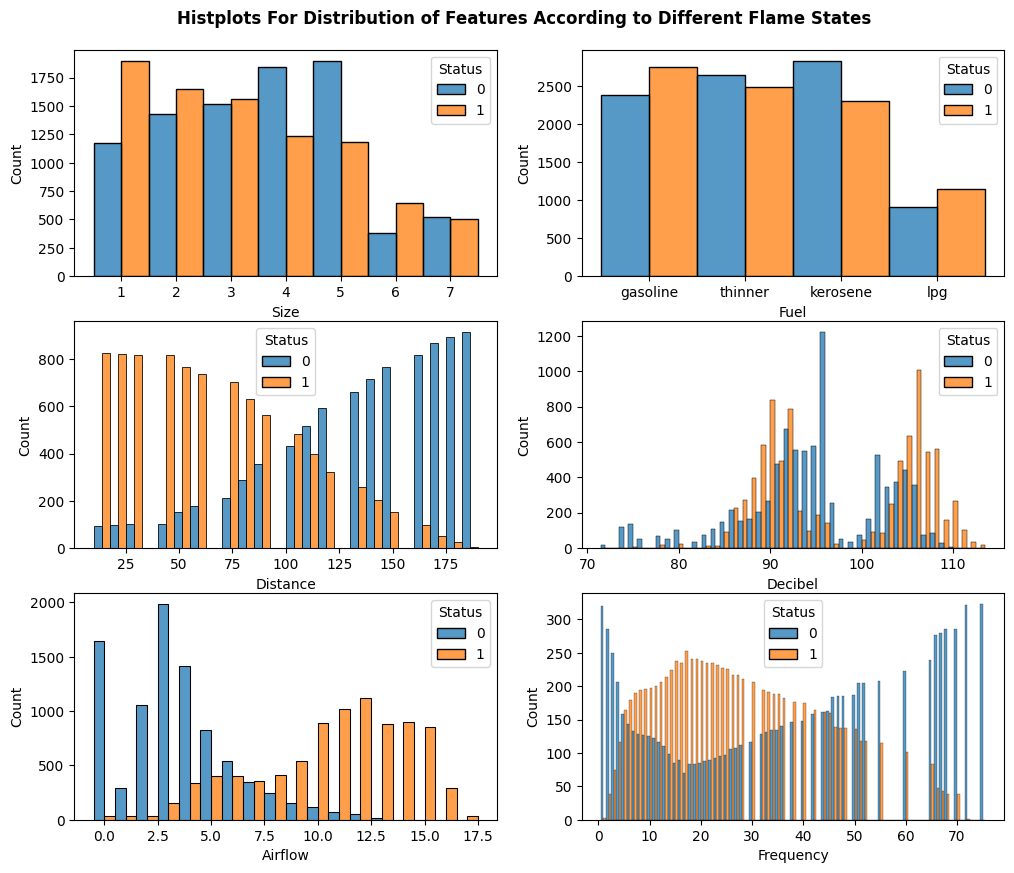

In [32]:
def show_histplots(data):
    """
    Show histplots of six features.
    
    Args:
        data (object): The data to be used for plotting.
    """
    
    fig, ax = plt.subplots(3, 2, figsize=(12, 10))
    ax = ax.flatten() # Flatten into a 1-D array
    feat_names = data.columns # Get names of features
    for i, feat in enumerate(feat_names):
        if i >= len(ax):
            break
        if feat == 'Distance':
            sns.histplot(
                data=data, x=feat, hue='Status', multiple='dodge', ax=ax[i]
            )
        else:
            sns.histplot(
                data=data, x=feat, hue='Status', multiple='dodge', discrete=True, ax=ax[i]
            )
    
    # Save and show charts
    plt.suptitle("Histplots For Distribution of Features According to Different Flame States", 
                 y=0.92, fontsize='large', fontweight='semibold')
    plt.savefig('eda/feature_distribution_hist.png', dpi=300)
    plt.show()
    plt.close()

show_histplots(df_clean)

**Analysis according to the above six charts**:
1. There are 7 values ranging from 1 to 7 in the feature **`Size`**.
   - For the `non-extinction state` (labelled as 0),
     - The frequency increases gradually first, and then reaches the maximum of about 1900 at the size of 20 cm liquid fuel cans (labelled as 5).
     - After that, the frequency increases slowly from 380.
   - For the `extinction state` (labelled as 1),
     - The frequency decreases gradually over all sizes of liquid fuel cans.
     - The maximum frequency is about 1900 when the size of the liquid fuel cans is 7 cm (labelled as 1), and the minimum frequency is about 500 for a full throttle setting of LPG fuel (labelled as 7).
2. There are 4 different fuel types in the feature **`Fuel`**.
   - For the `non-extinction state` (labelled as 0),
     - The frequencies of occurrence of `gasoline`, `thinner` and `kerosene` are very high, reaching about 2400, 2650 and 2800, respectively.
     - However, for the `LPG` fuel, its frequency of occurrence is about one-third of that of `kerosene`.
   - For the `extinction state` (labelled as 1),
     - The frequencies of occurrence of `gasoline`, `thinner` and `kerosene` represent a similar trend.
     - Similarly, the frequency of occurrence of `LPG` fuel shows a similar trend compared with the `non-extinction state`, with a value of about 1150.
3. During each experiment, the fuel container, at a 10 cm **`distance`**, was moved forward up to 190 cm by increasing the distance by 10 cm each time.
   - For the `non-extinction state` (labelled as 0),
     - The frequency of occurrence shows a growth trend similar to that of a `sine function` in $[-\pi/2, \pi/2]$.
   - For the `extinction state` (labelled as 1),
     - It shows a completely opposite trend of change, which is similar to that of a `cosine function` in $[0, \pi]$.
4. Along with the fuel container, the **`decibel`** meter was moved forward from 72 dB to 113 dB.
   - For the `non-extinction state` (labelled as 0),
     - The frequency is concentrated between 85 dB and 98 dB, and between 101 dB and 106 dB.
   - For the `extinction state` (labelled as 1),
     - The frequency is concentrated between 86 dB and 96 dB, and between 104 dB and 110 dB.
5. Along with the fuel container, the **`anemometer`** was moved forward from 0 m/s to 17 m/s.
   - For the `non-extinction state` (labelled as 0),
     - There are about 1600 performed experiments at zero wind speed.
     - Then the frequency of occurrence gradually increases from a very low of about 300 to about 2000 when the airflow is around 2.5 m/s.
     - After that, the frequency of occurrence drops until the maximum wind speed of 17 m/s.
   - For the `extinction state` (labelled as 1),
     - The frequency of occurrence gradually grows to around 1100 until the airflow reaches 12.5 m/s.
     - The frequencies of occurrence between 13 m/s and 15 m/s remain relatively stable.
     - Later, the frequency of occurrence drops.
6. Fire extinguishing experiments were conducted with 54 different **`frequency`** sound waves at each distance and flame size.
   - For the `non-extinction state` (labelled as 0),
     - The frequency of occurrence drops to about 80 when the frequency is 17 Hz during the early stage, and then rises again.
     - There are some missing values between 52 Hz and 72 Hz owing to the original setting of the experiments (**Missing values don't affect the results. Besides, it is designed for the destination of experiments**).
   - For the `extinction state` (labelled as 1),
     - It shows an opposite tendency where the frequency of occurrence grows from a really low level to over 250 when the frequency is about 17 Hz.
     - After that, the frequency of occurrence decreases until the frequency is 72 Hz.
     - There are some missing values between 52 Hz and 72 Hz owing to the original setting of the experiments (**Missing values don't affect the results. Besides, it is designed for the destination of experiments**).

Feature: 'Size', Status: 0:
[Q1]: 2.0, [median]: 4.0, [Q3]: 5.0, [mean]: 3.580774060965864, [IQR]: 3.0, [Q1-1.5×IQR]: -2.5, [Q3+1.5×IQR]: 9.5
Feature: 'Size', Status: 1:
[Q1]: 2.0, [median]: 3.0, [Q3]: 5.0, [mean]: 3.2412760566624437, [IQR]: 3.0, [Q1-1.5×IQR]: -2.5, [Q3+1.5×IQR]: 9.5

Feature: 'Distance', Status: 0:
[Q1]: 110.0, [median]: 140.0, [Q3]: 170.0, [mean]: 135.1227309053545, [IQR]: 60.0, [Q1-1.5×IQR]: 20.0, [Q3+1.5×IQR]: 260.0
Feature: 'Distance', Status: 1:
[Q1]: 30.0, [median]: 60.0, [Q3]: 90.0, [mean]: 64.56984913048485, [IQR]: 60.0, [Q1-1.5×IQR]: -60.0, [Q3+1.5×IQR]: 180.0

Feature: 'Decibel', Status: 0:
[Q1]: 91.0, [median]: 95.0, [Q3]: 102.0, [mean]: 94.72120105034821, [IQR]: 11.0, [Q1-1.5×IQR]: 74.5, [Q3+1.5×IQR]: 118.5
Feature: 'Decibel', Status: 1:
[Q1]: 90.0, [median]: 96.0, [Q3]: 106.0, [mean]: 98.05159507082806, [IQR]: 16.0, [Q1-1.5×IQR]: 66.0, [Q3+1.5×IQR]: 130.0

Feature: 'Airflow', Status: 0:
[Q1]: 1.7, [median]: 3.2, [Q3]: 4.6, [mean]: 3.388937093275488, [IQR]

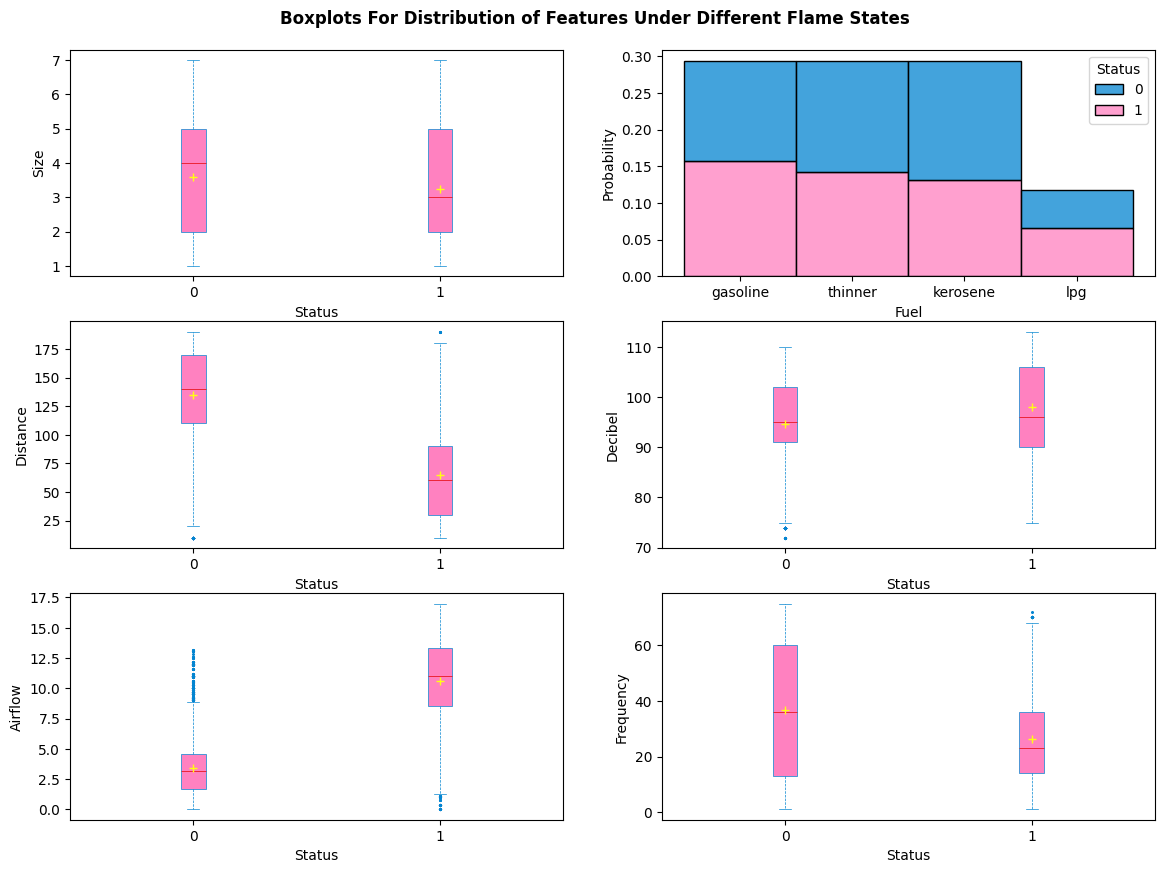

In [33]:
def show_boxplots(data):
    """
    Show boxplots of five features (Histplot for feature 'Fuel').
    
    Args:
        data (object): The data to be used for plotting.
    """
    
    fig, ax = plt.subplots(3, 2, figsize=(14, 10))
    ax = ax.flatten() # Flatten into a 1-D array
    feat_names = data.columns # Get names of features
    for i, feat in enumerate(feat_names):
        if i >= len(ax):
            break
        if feat == 'Fuel':
            sns.histplot(
                data=data, x=feat, hue='Status', stat='probability',
                palette=[sns.xkcd_rgb["cerulean"], sns.xkcd_rgb["pink"]],
                multiple='stack', discrete=True, ax=ax[i]
            )
        else:
            # Calculate values of Q1, Q3 and other related values for status '0' and '1' respectively
            for val in range(len(data['Status'].unique())):
                cur_feat = data[data['Status'] == val][feat]
                Q1 = cur_feat.quantile(0.25)
                median = cur_feat.median()
                Q3 = cur_feat.quantile(0.75)
                mean = cur_feat.mean()
                IQR = Q3 - Q1
                le = Q1 - 1.5 * IQR
                ue = Q3 + 1.5 * IQR
                print(f"Feature: '{feat}', Status: {val}:")
                print(f"[Q1]: {Q1}, [median]: {median}, [Q3]: {Q3}, [mean]: {mean}, [IQR]: {IQR}, [Q1-1.5×IQR]: {le}, [Q3+1.5×IQR]: {ue}")
            print()
            
            # Plot
            sns.boxplot(
                data=data, x='Status', y=feat, ax=ax[i], width=0.1, 
                showmeans=True, saturation=1, 
                linecolor=sns.xkcd_rgb["cerulean"], linewidth=0.5, 
                fliersize=1.2, 
                boxprops={'facecolor': sns.xkcd_rgb["pink"]},
                medianprops={'color': sns.xkcd_rgb["red"]}, 
                meanprops={'marker': '+', 'markeredgecolor': sns.xkcd_rgb["yellow"]}, 
                whiskerprops={'linestyle': '--', 'color': sns.xkcd_rgb["cerulean"]},
            )
    
    # Save and show charts
    plt.suptitle("Boxplots For Distribution of Features Under Different Flame States",
                 y=0.92, fontsize='large', fontweight='semibold')
    plt.savefig('eda/feature_distribution_boxplot.png', dpi=300)
    plt.show()
    plt.close()

show_boxplots(df_clean)

**Analysis according to the above six charts**:
- The above box plots show the distributions of these features.
  - The data in the `pink box` represents that they are located between the lower quartile and the upper quartile.
  - The `red line` in the `pink box` represents the median.
  - The `yellow plus sign` represents the mean.
  - The `blue whiskers` extend to points that lie within 1.5 IQRs of the lower and upper quartiles.
  - The `horizontal lines at the ends of the whiskers` are the lower extreme and upper extreme.
  - The `blue circles` indicate outliers.
- The box plots will display the results according to real data points.
  - If the ground truth of the lower extreme and upper extreme is out of the range of real data values, the box plots will display the lower extreme and upper extreme based on these real data points.
  - For example, the real lower extreme of feature `Size` is -2.5. But there is no data below 1, the box plot just shows a lower extreme at 1.

1. For the feature `Size`,
   
   | Status | Q1 | Median | Q3 | Mean | IQR (=Q3-Q1) | Q1-1.5×IQR | Q3+1.5×IQR | Concentrated Range |
   | ------ | -- | -- | -- | -- | -- | -- | -- | -- |
   | `0` | 2 | 4 | 5 | 3.58 | 3 | -2.5 | 9.5 | [4, 5] |
   | `1` | 2 | 3 | 5 | 3.24 | 3 | -2.5 | 9.5 | [2, 3] |

2. For the feature `Fuel`,
   - For the `non-extinction state` (labelled as 0), the `kerosene` fuel takes the highest probability.
   - For the `extinction state` (labelled as 1), the `gasoline` fuel takes the highest probability.
   - `LPG` fuel has the lowest probability in both states.

3. For the feature `Distance`,
   
   | Status | Q1 | Median | Q3 | Mean | IQR (=Q3-Q1) | Q1-1.5×IQR | Q3+1.5×IQR | Concentrated Range |
   | ------ | -- | -- | -- | -- | -- | -- | -- | -- |
   | `0` | 110 | 140 | 170 | 135.12 | 60 | 20 | 260 | Distributed uniformly |
   | `1` | 30 | 60 | 90 | 64.57 | 60 | -60 | 180 | Distributed uniformly |

4. For the feature `Decibel`,

   | Status | Q1 | Median | Q3 | Mean | IQR (=Q3-Q1) | Q1-1.5×IQR | Q3+1.5×IQR | Concentrated Range |
   | ------ | -- | -- | -- | -- | -- | -- | -- | -- |
   | `0` | 91 | 95 | 102 | 94.72 | 11 | 74.5 | 118.5 | [91, 95] |
   | `1` | 90 | 96 | 106 | 98.05 | 16 | 66 | 130 | [90, 96] |

5. For the feature `Airflow`,

   | Status | Q1 | Median | Q3 | Mean | IQR (=Q3-Q1) | Q1-1.5×IQR | Q3+1.5×IQR | Concentrated Range |
   | ------ | -- | -- | -- | -- | -- | -- | -- | -- |
   | `0` | 1.7 | 3.2 | 4.6 | 3.39 | 2.90 | -2.65 | 8.95 | [3.2, 4.6] - slightly |
   | `1` | 8.5 | 11 | 13.3 | 10.59 | 4.80 | 1.30 | 20.5 | [11, 13.3] - slightly |

6. For the feature `Frequency`,

   | Status | Q1 | Median | Q3 | Mean | IQR (=Q3-Q1) | Q1-1.5×IQR | Q3+1.5×IQR | Concentrated Range |
   | ------ | -- | -- | -- | -- | -- | -- | -- | -- |
   | `0` | 13 | 36 | 60 | 36.70 | 47 | -57.5 | 130.5 | [13, 36] - slightly |
   | `1` | 14 | 23 | 36 | 26.48 | 22 | -19 | 69 | [14, 23] |


##### **Task** 【Analysis the pearson correlation between features】
> 【**Pearson Correlation**】
> 
> It measures the linear dependence between two variables, `X` and `Y`. \
> It provides two key values:
> 1. **Correlation coefficient**
>    - It is a value between -1 and 1, inclusive.
>         
>      | Value | Definition |
>      | -- | -- |
>      | `1` | perfect positive linear correlation |
>      | `0` | no linear correlation and two variables likely do not affect each other |
>      | `-1` | perfect negative linear correlation |
>
>    - According to the first original research paper,
>   
>      | Value Range | Definition |
>      | -- | -- |
>      | `± [0.01, 0.29]` | a low level of correlation |
>      | `± [0.30, 0.70]` | a moderate correlation |
>      | `± [0.71, 0.99]` | a high level of correlation |
>      
> 2. **P-value**
>    - It is the probability that people would have found the current result if the correlation coefficient were in fact zero (null hypothesis). If this probability is lower than the conventional 5% (P<0.05), the correlation coefficient is called statistically significant.
>    - The `95% confidence interval` represents the range of values that contains the "true" correlation coefficient with 95% confidence.
>     
>      | P-value | Definition |
>      | -- | -- |
>      | `< 0.001` | strong evidence that the correlation is significant |
>      | `< 0.05` | moderate evidence that the correlation is significant |
>      | `< 0.1` | weak evidence that the correlation is significant |
>      | `> 0.1` | no evidence that the correlation is significant |
>

In [34]:
# Calculate the correlation
df_corr = df_clean.corr(method='pearson', numeric_only=True)
df_corr

,Size,Distance,Decibel,Airflow,Frequency,Status
Size,1.000000e+00,-2.437871e-15,-6.125585e-15,1.677898e-16,9.978281e-17,-0.096947
Distance,-2.437871e-15,1.000000e+00,-2.385897e-01,-7.074906e-01,-2.452947e-17,-0.644051
Decibel,-6.125585e-15,-2.385897e-01,1.000000e+00,3.769153e-01,5.617409e-01,0.203970
Airflow,1.677898e-16,-7.074906e-01,3.769153e-01,1.000000e+00,-2.120462e-01,0.760628
Frequency,9.978281e-17,-2.452947e-17,5.617409e-01,-2.120462e-01,1.000000e+00,-0.244203
Status,-9.694718e-02,-6.440506e-01,2.039698e-01,7.606279e-01,-2.442030e-01,1.000000


In [35]:
def calculate_correlation_status(data):
    """
    Calculate the 'Pearson Correlation Coefficient' and 'P-value' of each numeric variable with 'Status'.
    
    Args:
        data (object): Calculate the correlation status.
    """
    
    numerical_feats = ["Size", "Distance", "Decibel", "Airflow", "Frequency"]
    # Iterate over each feature
    for feat in numerical_feats:
        pearson_coef, p_value = stats.pearsonr(data[feat], data['Status'])
        print(f"Feature1: '{feat}' and Feature2: 'Status':")
        print(f"Pearson Correlation Coefficient is {pearson_coef} with a P-value of {p_value}.")

calculate_correlation_status(df_clean)

Feature1: 'Size' and Feature2: 'Status':
Pearson Correlation Coefficient is -0.09694717705400314 with a P-value of 1.071965712722321e-37.
Feature1: 'Distance' and Feature2: 'Status':
Pearson Correlation Coefficient is -0.6440506333423619 with a P-value of 0.0.
Feature1: 'Decibel' and Feature2: 'Status':
Pearson Correlation Coefficient is 0.2039697789085702 with a P-value of 3.5047616899415734e-163.
Feature1: 'Airflow' and Feature2: 'Status':
Pearson Correlation Coefficient is 0.7606278883242846 with a P-value of 0.0.
Feature1: 'Frequency' and Feature2: 'Status':
Pearson Correlation Coefficient is -0.24420295102083955 with a P-value of 3.4497782740982074e-235.


In [36]:
def calculate_correlation_others(data):
    """
    Calculate the 'Pearson Correlation Coefficient' and 'P-value' of each numeric variable.

    Args:
        data (object): Calculate other correlation status.
    """
    
    numerical_params = ["Size", "Distance", "Decibel", "Airflow", "Frequency"]
    # Iterate over each combination of features
    for feat1, feat2 in itertools.combinations(numerical_params, 2):
        pearson_coef, p_value = stats.pearsonr(data[feat1], data[feat2])
        print(f"Feature1: '{feat1}' and Feature2: '{feat2}':")
        print(f"Pearson Correlation Coefficient is {pearson_coef} with a P-value of {p_value}.")

calculate_correlation_others(df_clean)

Feature1: 'Size' and Feature2: 'Distance':
Pearson Correlation Coefficient is -6.071532165918825e-18 with a P-value of 1.0000000000000004.
Feature1: 'Size' and Feature2: 'Decibel':
Pearson Correlation Coefficient is 3.469446951953614e-18 with a P-value of 1.0000000000000004.
Feature1: 'Size' and Feature2: 'Airflow':
Pearson Correlation Coefficient is 1.691355389077387e-17 with a P-value of 1.0000000000000004.
Feature1: 'Size' and Feature2: 'Frequency':
Pearson Correlation Coefficient is -3.686287386450715e-18 with a P-value of 1.0000000000000004.
Feature1: 'Distance' and Feature2: 'Decibel':
Pearson Correlation Coefficient is -0.2385897494768056 with a P-value of 2.7923348143171966e-224.
Feature1: 'Distance' and Feature2: 'Airflow':
Pearson Correlation Coefficient is -0.7074905992691336 with a P-value of 0.0.
Feature1: 'Distance' and Feature2: 'Frequency':
Pearson Correlation Coefficient is 1.734723475976807e-18 with a P-value of 1.0000000000000004.
Feature1: 'Decibel' and Feature2: 'A

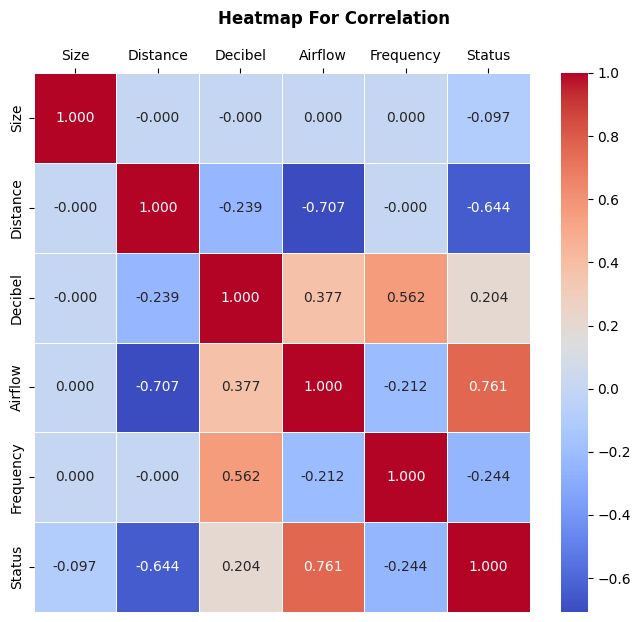

In [37]:
def show_correlation_heatmap(data):
    """
    Show a heatmap for correlation.
    
    Args:
        data (object): The data to be used for plotting.
    """
    
    plt.figure(figsize=(8, 7))
    ax = sns.heatmap(data=data, annot=True, fmt=".3f", linewidth=0.5, cbar=True, cmap="coolwarm")
    ax.xaxis.tick_top()
    plt.suptitle("Heatmap For Correlation", y=0.97, fontsize='large', fontweight='semibold')
    plt.savefig('eda/correlation_heatmap.png', dpi=300)
    plt.show()
    plt.close()

show_correlation_heatmap(df_corr)

**Analysis according to the above correlation results**:
1. Each variable and itself have a perfect positive linear correlation.
2. The `Pearson Correlation Coefficient (PCC)` between the feature `Size` and label `Status` is -0.09694717705400314, showing a low level of negative linear correlation. The p-value is 1.071965712722321e-37, showing strong evidence that the correlation is significant.
3. The `PCC` between the feature `Distance` and label `Status` is -0.6440506333423619, showing a moderate negative linear correlation. The p-value is 0.0, showing extremely strong evidence that the correlation is significant.
4. The `PCC` between the feature `Decibel` and label `Status` is 0.2039697789085702, showing a low level of positive linear correlation. The p-value is 3.5047616899415734e-163, showing strong evidence that the correlation is significant.
5. The `PCC` between the feature `Airflow` and label `Status` is 0.7606278883242846, showing a high level of positive linear correlation. The p-value is 0.0, showing extremely strong evidence that the correlation is significant.
6. The `PCC` between the feature `Frequency` and label `Status` is -0.24420295102083955, showing a low level of negative linear correlation. The p-value is 3.4497782740982074e-235, showing strong evidence that the correlation is significant.
7. The P-values between the feature `Size` and other features (excluding the label `Status`) are 1, which means **there is no evidence to prove the correlation between feature `Size` and other features (excluding the label `Status`). So this is also why I didn't analyse the lmplots for the distribution of feature `Size` and other features.** This phenomenon originates from the design and steps of the experiments in the original research papers.
8. The `PCC` between the feature `Distance` and feature `Decibel` is -0.2385897494768056, showing a low level of negative linear correlation. The p-value is 2.7923348143171966e-224, showing strong evidence that the correlation is significant.
9. The `PCC` between the feature `Distance` and feature `Airflow` is -0.7074905992691336, showing a high level of negative linear correlation. The p-value is 0.0, showing extremely strong evidence that the correlation is significant.
10. The `PCC` between the feature `Decibel` and feature `Airflow` is 0.37691532500235325, showing a moderate positive linear correlation. The p-value is 0.0, showing extremely strong evidence that the correlation is significant.
11. The `PCC` between the feature `Decibel` and feature `Frequency` is 0.5617408500515608, showing a moderate positive linear correlation. The p-value is 0.0, showing extremely strong evidence that the correlation is significant.
12. The `PCC` between the feature `Airflow` and feature `Frequency` is -0.21204619741944492, showing a low level of negative linear correlation. The p-value is 1.6903810317610316e-176, showing strong evidence that the correlation is significant.

【Conclusion】
1. In summary, features `Distance` and `Airflow` may be really significant to the results of `Status`. Other features can also influence the results of `Status`.
2. For the above results,
   - If there is a **negative correlation** between two features, it means that the feature `B` will increase if the feature `A` decreases. \
     **[Example]**: `Size`, `Distance` and `Frequency`.
   - If there is a **positive correlation** between two features, it means that the feature `B` will increase if the feature `A` increases. \
     **[Example]**: `Decibel` and `Airflow`.

##### **Task** 【Draw lmplots for numerical features】

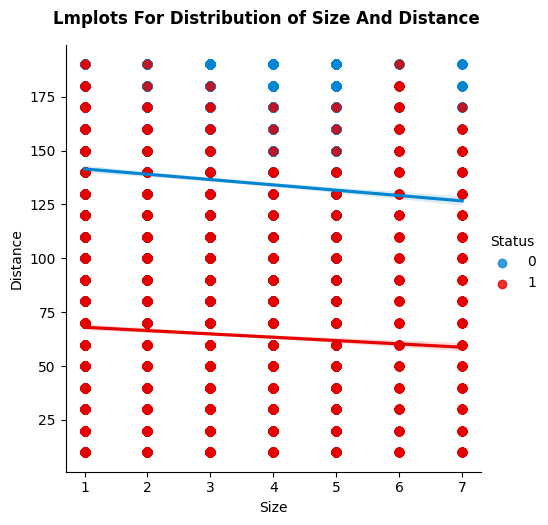

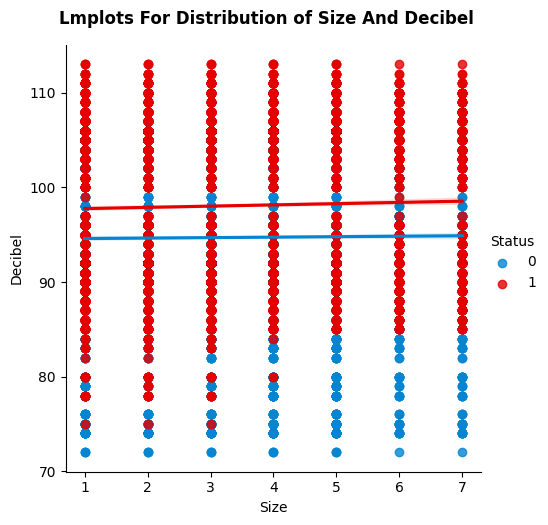

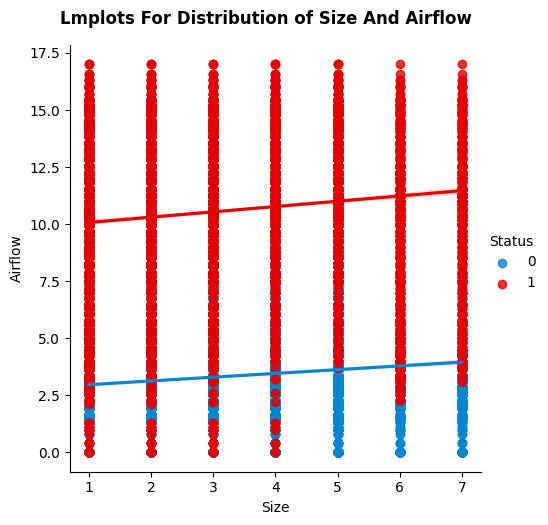

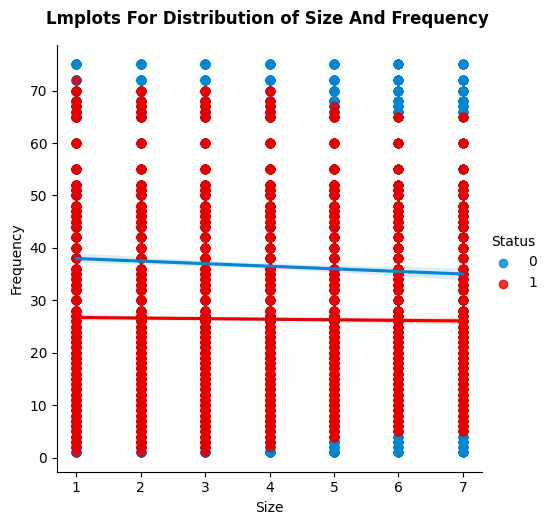

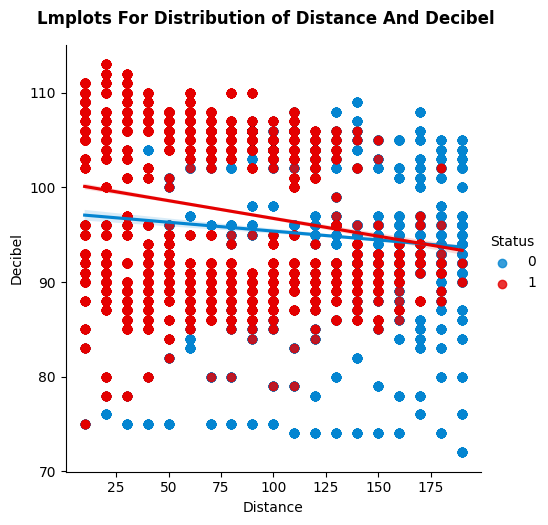

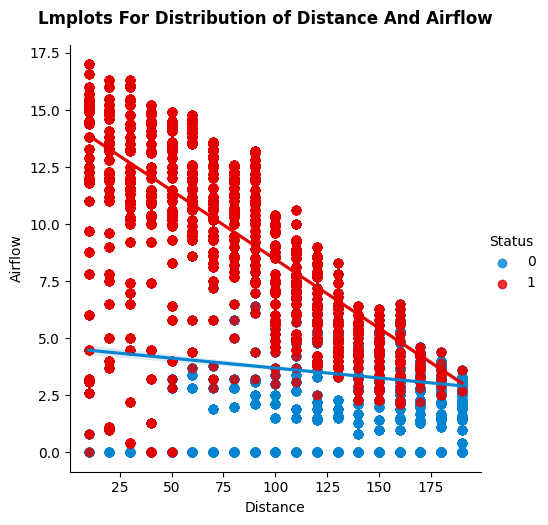

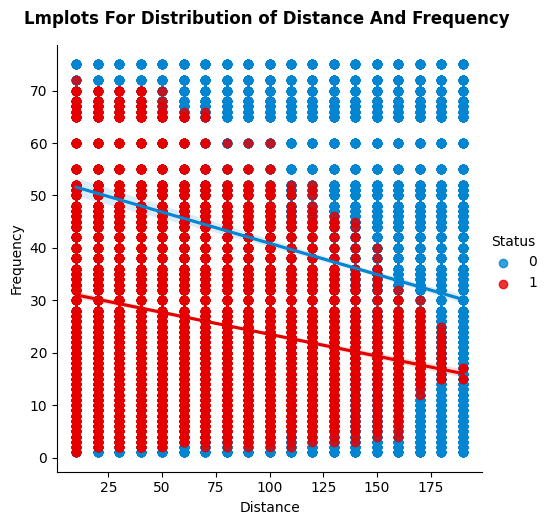

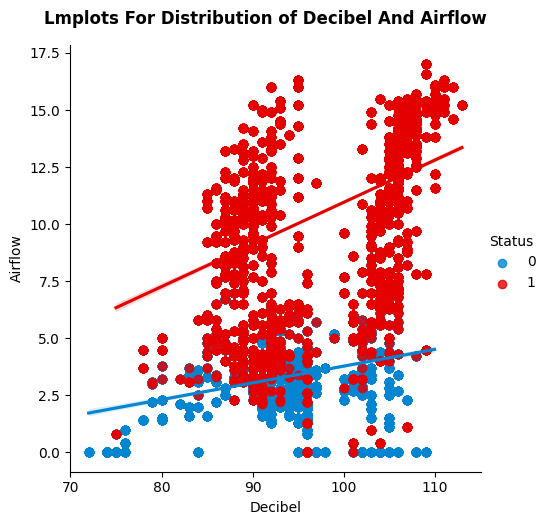

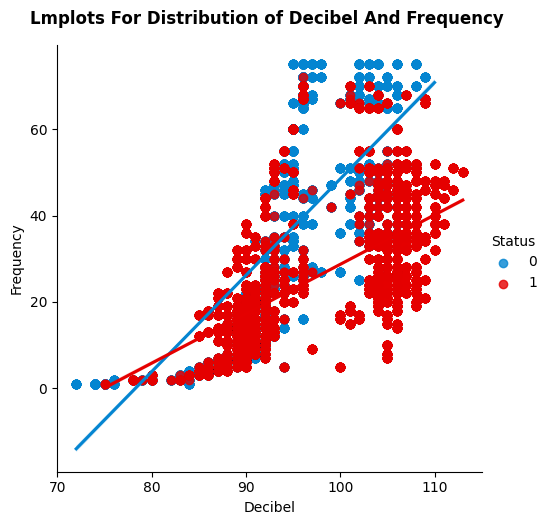

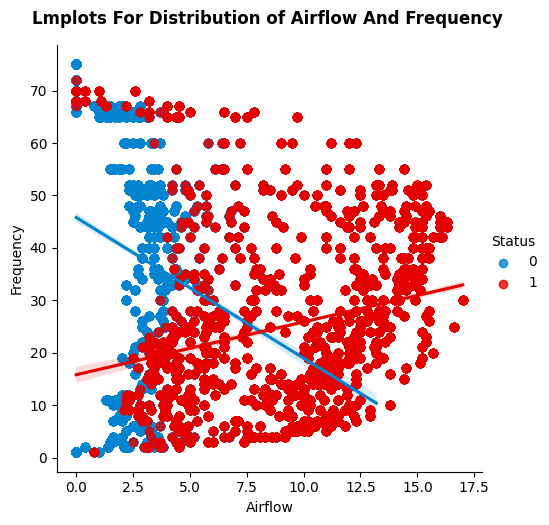

In [38]:
def show_lmplots(data):
    """
    Show lmplots for numerical features.
    
    Args:
        data (object): The data to be used for plotting.
    """
    
    # Get numerical columns
    df_numeric = data[['Size', 'Distance', 'Decibel', 'Airflow', 'Frequency', 'Status']].copy()
    feat_names = df_numeric.columns.to_list() # Get names of features
    feat_names = [x for x in feat_names if x != 'Status']
    
    # Get pair-wise features
    for feat1, feat2 in itertools.combinations(feat_names, 2):
        # Plot
        sns.lmplot(
            data=df_numeric, x=feat1, y=feat2, hue='Status', seed=20717331,
            palette=[sns.xkcd_rgb["cerulean"], sns.xkcd_rgb["red"]]
        )
        # Save and show charts
        plt.suptitle(f"Lmplots For Distribution of {feat1} And {feat2}", 
                     y=1.04, fontsize='large', fontweight='semibold')
        plt.savefig(f'eda/feature_lmplots_{feat1}_{feat2}.png', dpi=300)
        plt.show()
        plt.close()

show_lmplots(df_clean)

**Analysis according to the above lmplots**:
1. The original dataset collected data by using 5 different sizes of liquid fuel cans and 2 kinds of adjustments of LPG fuel (these 7 sizes represent different sizes of flames). Then, experiments were conducted at each distance (from the flame to the collimator output) and at 54 different frequencies, where the airflow and decibel values were measured by an anemometer and a decibel meter moving synchronously with the fuel container. **In conclusion, each size has the same amount of data, and according to lmplots, I don't analyse the lmplots of size and other variables here and just focus on analysing other lmplots.**
2. Analysing pair-wise features:
   
   | Feature 1 | Feature 2 | Characteristics | Flame extinction observation |
   | -- | -- | -- | -- |
   | `Distance` | `Airflow` | 1. For small distances like from 40 cm to 50 cm, flames can be extinguished in a low airflow of near zero. <br/> 2. For distances ranging from 50 cm to 130 cm, most flames can be extinguished when the airflow reaches over around 3 m/s. <br/> 3. For distances ranging from 130 cm to 190 cm, flames can be extinguished when the airflow reaches over about 2.5 m/s. | 1. When distances are small, high airflow (upper bound is around 17 m/s) can extinguish flames. <br/> 2. When distances grow, the upper bound of extinguishment drops gradually. <br/> 3. When distances are large, low airflow (lower bound is around 2.5 m/s) can extinguish flames. |
   | `Distance` | `Decibel` | 1. For small distances like from 0 to 60 cm, most flames can be extinguished with a low decibel of around 83 dB and a high decibel of 113 dB. <br/> 2. For middle distances ranging from 60 cm to 150 cm, most flames can be extinguished with a low decibel of around 84 dB and a high decibel of around 106 dB. However, some flames cannot be extinguished when the decibel level is between 96 dB and 100 dB. <br/> 3. For large distances ranging from 150 cm to 190 cm, most flames can be extinguished with a low decibel of above 85 dB and a high decibel of around 93 dB. | 1. When distances are small, flames can be extinguished when the decibel ranges from 83 dB to 113 at most cases. <br/> 2. When distances grow, the lower bound of the decibel for the critical point of extinction becomes higher, and the upper bound becomes lower. Some flames cannot be extinguished when the decibel level is between 96 dB and 100 dB. <br/> 3. When distances are large, most flames can be extinguished only when decibels are between 85 dB and 93 dB. |
   | `Distance` | `Frequency` | 1. For small distances ranging from 0 to 50 cm, most flames can be extinguished with a lower bound of frequency at around 1 Hz, and an upper bound at around 70 Hz. <br/> 2. For distances ranging from 50 cm to 160 cm, most flames can be extinguished with a lower bound of frequency at around 2 Hz to 3 Hz, and the upper bound gradually drops. <br/> 3. For large distances ranging from 160 cm to 190 cm, most flames can be extinguished with a growing lower bound and a decreasing upper bound. The number of flames extinguished is going to decrease significantly. | 1. When distances are not too large  (smaller than 100 cm), most flames can be extinguished with a low lower bound at around 1 Hz to 3 Hz and an upper bound at 53 Hz. <br/> 2. When distances increase, the upper bound of the frequency of flame extinction will decrease to around 30 Hz. Besides, the lower bound will increase. |
   | `Decibel` | `Airflow` | 1. For decibels ranging from 84 dB to 96 dB, most flames can be extinguished when airflow reaches higher than 2.5 m/s and lower than 16.5 m/s. <br/> 2. For decibels ranging from 102 dB to 113 dB, most flames can be extinguished when airflow reaches higher of around 4 m/s and is lower than 17 m/s. | \<Please see left.> |
   | `Decibel` | `Frequency` | 1. For decibels ranging from 84 dB to 96 dB, most flames can be extinguished when frequency reaches higher than 4 Hz and lower than 30 Hz. <br/> 2. For decibels ranging from 102 dB to 113 dB, most flames can be extinguished when the frequency reaches higher than 4 Hz and lower than 55 Hz. | \<Please see left.> |
   | `Airflow` | `Frequency` | 1. For airflow lower than 2.5 m/s, flames can be extinguished only when the frequency reaches higher than 65 Hz. <br/> 2. For airflow ranging from 2.5 m/s to 4 m/s, most flames can be extinguished when the frequency reaches higher than 2 Hz and lower than 28 Hz. <br/> 3. For airflow ranging from 4 m/s to 17.5 m/s, most flames can be extinguished when the frequency increases gradually and is lower than 55 Hz. | \<Please see left.> |

##### **Task** 【Make a conclusion of features that can influence the status of the flame】

1. According to the EDA above, it is clear that **all five features (`Size`, `Distance`, `Decibel`, `Airflow`, `Frequency`) can influence the `Status` of the flame.**
2. Specific analysis of the correlation between different features and the label can be found above.

### Step 2 · Data Preprocessing (Feature Engineering)
【Step Description】
- Transform raw data into meaningful features for modelling.
- Techniques: `normalization`, `encoding categorical variables` and `creating derived features`.

##### **Task** 【Encoding categorical variables】

In [39]:
df_clean.dtypes

Size           int64
Fuel          object
Distance       int64
Decibel        int64
Airflow      float64
Frequency      int64
Status         int64
dtype: object

- The data type of `Status` is `int64`. It can bring out a new categorical label by using `Binning` technique.
- There are some reasons using `Binning` technique:
  - Simplifies complex data.
  - Handles outliers.
  - Improves model performance for certain algorithms.
- **Here, the data type of the label field `Status` is `int64`, I transform it into a categorical type. However, the `MinMaxScaler` used later can only handle numerical data. I will select the original int `Status` to perform subsequent modelling.**

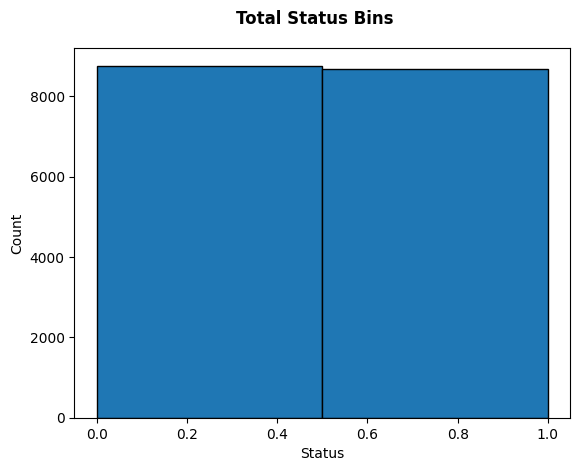

In [40]:
def show_binning_hist(data):
    """
    Show a histogram of the Binning technique.
    
    Args:
        data (object): The data to be used for plotting.
    """
    
    # Create bins
    bins = np.linspace(min(data['Status']), max(data['Status']), 3)
    # Names of groups
    group_names = ['NE', 'E']
    # Determine the bin for each status
    data['Status-binned'] = pd.cut(
        data['Status'], bins, labels=group_names, include_lowest=True
    )
    # Create a histogram
    plt.hist(data['Status'], bins=bins, edgecolor="black") # Use the same bins for consistency
    # Save and show charts
    plt.xlabel("Status")
    plt.ylabel("Count")
    plt.suptitle("Total Status Bins", y=0.96, fontsize='large', fontweight='semibold')
    plt.savefig('eda/binning_hist.png', dpi=300)
    plt.show()
    plt.close()

show_binning_hist(df_clean)

In [41]:
df_clean

,Size,Fuel,Distance,Decibel,Airflow,Frequency,Status,Status-binned
0,1,gasoline,10,96,0.0,75,0,NE
1,1,gasoline,10,96,0.0,72,1,E
2,1,gasoline,10,96,2.6,70,1,E
3,1,gasoline,10,96,3.2,68,1,E
4,1,gasoline,10,109,4.5,67,1,E
...,...,...,...,...,...,...,...,...
17437,7,lpg,190,86,2.2,5,0,NE
17438,7,lpg,190,84,2.0,4,0,NE
17439,7,lpg,190,80,1.5,3,0,NE
17440,7,lpg,190,76,0.4,2,0,NE


In [42]:
# Save in a file with setting the label of index
df_clean.to_csv('AEF_CLEAN_BINNING.csv', index_label='Id', encoding='utf-8')

##### **Task** 【Check basic information about X and y】

In [43]:
# Get six features and one label
df_model = df_clean[['Size', 'Fuel', 'Distance', 'Decibel', 'Airflow', 'Frequency', 'Status']].copy()
df_model

,Size,Fuel,Distance,Decibel,Airflow,Frequency,Status
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1
...,...,...,...,...,...,...,...
17437,7,lpg,190,86,2.2,5,0
17438,7,lpg,190,84,2.0,4,0
17439,7,lpg,190,80,1.5,3,0
17440,7,lpg,190,76,0.4,2,0


In [44]:
# Get the number of instances and features
row_num = df_model.shape[0]
col_num = df_model.shape[1]

In [45]:
row_num, col_num

(17442, 7)

In [46]:
# Get the input variables X with six features from 'Size' to 'Frequency'
X = np.array(df_model.iloc[:, :6].values)

In [47]:
X

array([[1, 'gasoline', 10, 96, 0.0, 75],
       [1, 'gasoline', 10, 96, 0.0, 72],
       [1, 'gasoline', 10, 96, 2.6, 70],
       ...,
       [7, 'lpg', 190, 80, 1.5, 3],
       [7, 'lpg', 190, 76, 0.4, 2],
       [7, 'lpg', 190, 72, 0.0, 1]], dtype=object)

In [48]:
X.shape

(17442, 6)

In [49]:
# Get the target values y
y = np.array(df_model.iloc[:, 6].values)

In [50]:
y

array([0, 1, 1, ..., 0, 0, 0])

In [51]:
y.shape

(17442,)

##### **Task** 【Feature transformation】
- As I need to **normalize the values of features into a uniform scale**, it is important to **transform the `Fuel` feature into categorical values**.

In [52]:
# Transform the 'Fuel' into categorical values
X_ = np.zeros((row_num, col_num - 1), dtype=float)
X_

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [53]:
X_.shape

(17442, 6)

- Feature `Fuel` is divided into four categories according to the following rule.
|Fuel name|value|
|:--:|:--:|
|$\text{X[:, 1]} == 'gasoline' $|1|
|$\text{X[:, 1]} == 'kerosene' $|2|
|$\text{X[:, 1]} == 'thinner' $|3|
|$\text{X[:, 1]} == 'lpg' $|4|

In [54]:
# Map the feature 'Fuel' from the object type to the int type
X2_ = np.zeros(row_num, dtype="int")
X2 = X[:, 1]
X2_[X2 == 'gasoline'] = 1
X2_[X2 == 'kerosene'] = 2
X2_[X2 == 'thinner'] = 3
X2_[X2 == 'lpg'] = 4
X_[:, 1] = X2_
X_

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 4., 0., 0., 0., 0.],
       [0., 4., 0., 0., 0., 0.],
       [0., 4., 0., 0., 0., 0.]])

In [55]:
# Other features remain unchanged
indices = [0, 2, 3, 4, 5]
for idx in indices:
    X_[:, idx] = X[:, idx]
X_

array([[  1. ,   1. ,  10. ,  96. ,   0. ,  75. ],
       [  1. ,   1. ,  10. ,  96. ,   0. ,  72. ],
       [  1. ,   1. ,  10. ,  96. ,   2.6,  70. ],
       ...,
       [  7. ,   4. , 190. ,  80. ,   1.5,   3. ],
       [  7. ,   4. , 190. ,  76. ,   0.4,   2. ],
       [  7. ,   4. , 190. ,  72. ,   0. ,   1. ]])

In [56]:
X

array([[1, 'gasoline', 10, 96, 0.0, 75],
       [1, 'gasoline', 10, 96, 0.0, 72],
       [1, 'gasoline', 10, 96, 2.6, 70],
       ...,
       [7, 'lpg', 190, 80, 1.5, 3],
       [7, 'lpg', 190, 76, 0.4, 2],
       [7, 'lpg', 190, 72, 0.0, 1]], dtype=object)

Here, it is clear that the feature `Fuel` has been transformed successfully!

##### **Task** 【Get the numbers of various values in each feature】

In [57]:
feat_val_nums = np.zeros(X_.shape[1])
feature_names = ['Size', 'Fuel', 'Distance', 'Decibel', 'Airflow', 'Frequency']
for i, feat in enumerate(feature_names):
    feat_val_nums[i] = len(df_model[feat].unique())
feat_val_nums = feat_val_nums.astype(int)
feat_val_nums

array([  7,   4,  19,  39, 127,  54])

##### **Task** 【Feature scaling】
- The values of six features are on different scales. The feature on a large scale would have a huge influence on label prediction.
- Here, **I normalise the values of different features into a uniform scale $[0, 1]$ to balance the contributions of different features to label prediction**.
- There are two methods, including [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) and [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).
- **Because it is unknown which data distribution the data belongs to, I utilised the `MinMaxScaler` here**.

In [58]:
# Scale the converted X_
scaler = MinMaxScaler() # Create an instance
scaler.fit(X_) # Fit the data
X_scaled = scaler.transform(X_) # Transform the data X_ into normalized data (a numpy array)
X_scaled

array([[0.        , 0.        , 0.        , 0.58536585, 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , 0.58536585, 0.        ,
        0.95945946],
       [0.        , 0.        , 0.        , 0.58536585, 0.15294118,
        0.93243243],
       ...,
       [1.        , 1.        , 1.        , 0.19512195, 0.08823529,
        0.02702703],
       [1.        , 1.        , 1.        , 0.09756098, 0.02352941,
        0.01351351],
       [1.        , 1.        , 1.        , 0.        , 0.        ,
        0.        ]])

### Step 3 · Data Insights
【Step Description】
- Generate actionable insights to understand trends and patterns.
- Identifying correlation and data anomalies.

【Note】
- Here, I moved code related to `identifying correlation` that should have been implemented here to `Step 1` of `Stage 2`, in order to form a complete analysis.
- I also moved code related to `identifying data anomalies` that should have been implemented here to `Step 2` of `Stage 1`, in order to form a complete data preprocessing.

## Stage 3 · Model Development

### Step 1 · Feature Engineering
【Step Description】
- Improve model performance by selecting, transforming, and creating features.

【Note】
- Here, I implemented `model evaluation methods`.
- For other `feature-engineering-related content`, please refer to `Step 2` of `Stage 2`.

##### **Task** 【Different model evaluation modes definition】
- It is clear that the two evaluation modes have different outputs, aiming to **differentiate the usage of these two evaluation methods** in the subsequent steps and **avoid confusion**.
- The following is the basic information about the two model evaluation modes.

   | Mode | Characteristics |
   | -- | -- |
   | `Train-test split strategy` | 1. Training data accounts for 80%, and testing data accounts for 20%. <br/> 2. This strategy can quickly compute a random split into training and test sets. <br/> The results of this strategy contain four parts: `X_train`, `X_test`, `y_train` and `y_test`. |
   | `Stratified k-fold cross-validation strategy` | 1. Using a stratified `k-fold cross-validator` to split the data into `k` (here, `k` = 5) subsets. Each subset is utilised for testing once. <br/> 2. In these 5 subsets, each fold will produce its own `X_train`, `X_test`, `y_train` and `y_test`. <br/> 3. In my implementation, it will return an array named `k_fold_data` containing `X_train`, `X_test`, `y_train` and `y_test` for the subsequent `K-fold Cross-validation`. |


In [59]:
def model_evaluation_method(mode):
    """
    Definition of different model evaluation methods and hyperparameter configurations.
    
    Args:
        mode (object): The mode of model evaluation.
    
    Returns:
        X_train, X_test, y_train, y_test: Divided training data, testing data, training labels and testing labels for Train-test split.
        k_fold_data: An array containing X_train, X_test, y_train and y_test for k-fold cross-validation.
    """
    
    # 1. Randomly split the data X and y into training and test sets with the ratio 4:1
    if mode == 'train-test':
        print("Current evaluation mode is [Train-test split].")

        # Split data (Using the scaled data X_scaled)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=20717331)
        
        print(f"X_train:\n {X_train}\ny_train:\n {y_train}\n")
        print(f"X_test:\n {X_test}\ny_test:\n {y_test}\n")
        
        return X_train, X_test, y_train, y_test
    # 2. Manual k-fold cross-validation
    elif mode == 'cross-validation':
        print("Current evaluation mode is [K-fold Cross-validation].")
        
        # Stratified k-Fold cross-validator definition
        skf = StratifiedKFold(n_splits=5, random_state=20717331, shuffle=True)
        print(f"StratifiedKFold: \n{skf}\n")

        # Store training data and testing data for each fold
        k_fold_data = np.zeros(skf.get_n_splits(X_scaled, y), dtype=object)
        
        # Get training data and test data of each fold (Using the scaled data X_scaled)
        for i, (train_index, test_index) in enumerate(skf.split(X_scaled, y)):
            print(f"Fold {i}:")
            print(f"  Train: index={train_index}")
            print(f"  Test:  index={test_index}")
            X_train = X_scaled[train_index]
            y_train = y[train_index]
            X_test = X_scaled[test_index]
            y_test = y[test_index]
            
            # Construct and store the current data for later usage
            k_fold_data[i] = {
                'X_train': X_train,
                'y_train': y_train,
                'X_test': X_test,
                'y_test': y_test
            }
        
        print(f"\nThe number of folds:\n{len(k_fold_data)}\nThe k_fold_data:\n{k_fold_data}")
        
        return k_fold_data

In [60]:
# Perform the evaluation by the Train-test strategy
X_train, X_test, y_train, y_test = model_evaluation_method('train-test')
train_num = y_train.shape[0]
test_num = y_test.shape[0]
print(f"The number of training data: {train_num}.\nThe number of testing data: {test_num}.")

Current evaluation mode is [Train-test split].
X_train:
 [[0.16666667 0.         0.22222222 0.43902439 0.60588235 0.12162162]
 [0.66666667 0.         0.61111111 0.7804878  0.33529412 0.27027027]
 [0.66666667 0.66666667 0.66666667 0.56097561 0.2        0.7972973 ]
 ...
 [0.16666667 0.         0.         0.43902439 0.64705882 0.05405405]
 [0.         0.         0.94444444 0.3902439  0.21176471 0.18918919]
 [0.33333333 0.33333333 0.27777778 0.75609756 0.25882353 0.86486486]]
y_train:
 [1 1 0 ... 1 0 1]

X_test:
 [[0.         0.         0.22222222 0.46341463 0.65882353 0.09459459]
 [0.         0.66666667 0.11111111 0.92682927 0.94705882 0.55405405]
 [0.66666667 0.33333333 0.83333333 0.6097561  0.         1.        ]
 ...
 [0.16666667 0.         0.72222222 0.36585366 0.26470588 0.06756757]
 [0.16666667 0.66666667 0.         0.95121951 0.94117647 0.58108108]
 [0.16666667 0.66666667 0.94444444 0.51219512 0.21176471 0.31081081]]
y_test:
 [1 1 0 ... 1 1 0]

The number of training data: 13953.
T

In [61]:
# Perform the evaluation by the k-fold Cross-validation strategy
k_fold_data = model_evaluation_method('cross-validation')

Current evaluation mode is [K-fold Cross-validation].
StratifiedKFold: 
StratifiedKFold(n_splits=5, random_state=20717331, shuffle=True)

Fold 0:
  Train: index=[    0     1     3 ... 17437 17438 17441]
  Test:  index=[    2     8    23 ... 17430 17439 17440]
Fold 1:
  Train: index=[    0     2     3 ... 17439 17440 17441]
  Test:  index=[    1    12    14 ... 17421 17433 17438]
Fold 2:
  Train: index=[    0     1     2 ... 17438 17439 17440]
  Test:  index=[    5    10    11 ... 17434 17436 17441]
Fold 3:
  Train: index=[    1     2     3 ... 17439 17440 17441]
  Test:  index=[    0     4    17 ... 17432 17435 17437]
Fold 4:
  Train: index=[    0     1     2 ... 17439 17440 17441]
  Test:  index=[    3     6     7 ... 17413 17425 17428]

The number of folds:
5
The k_fold_data:
[{'X_train': array([[0.        , 0.        , 0.        , 0.58536585, 0.        ,
         1.        ],
        [0.        , 0.        , 0.        , 0.58536585, 0.        ,
         0.95945946],
        [0.      

### Step 2 · Model Training
【Step Description】
- Train machine learning models using algorithms such as `K-Nearest-Neighbors`, `Decision Tree`, `Random Forest`, etc.
- Used tools: `Scikit-learn`, `TensorFlow`, `Scikeras`, `Numpy` and `Pandas`.

##### **Task** 【**SOTA Model (Stacking method)**: Model definition, train and evaluation】
- **In the first referenced research paper [1], I have tried my best to find the open-source code for it. However, I cannot find it. As a result, I re-implemented the SOTA model in this research paper.** Details are shown as follows.
- This method aims to integrate `ANN (Artificial Neural Network)`, `K-NN (K-Nearest-Neighbours)` and `RF (Random Forest)` into one model using the `StackingClassifier` to reproduce the SOTA model in the first referenced research paper.
- **This method prefers to use the `Train-test split strategy`**.
- In the function `ann_clf`, there is no code for compiling, because `SciKeras` will apply all of the compilation parameters, including instantiating losses, metrics and optimizers. However, another method of compiling is implementing the code after the sentence ```model.summary()``` shown as follows:

    ```
    model.compile(loss=tf.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])
    ```

【Note】
- **Because the SOTA model is built up by three ML models, it requires lots of time to train and evaluate. In my experiment, it takes about 20 minutes to finish the training and evaluation. As a result, I comment on the running code. If you have an interest, you can run it.**

In [62]:
# Create the directory
os.makedirs('./model', exist_ok=True)

In [63]:
def ann_clf(meta, n_features_in, hidden_units, output_units):
    """
    Define a custom model.

    Args:
        meta (dict): A special argument that will be handed a dict containing input metadata.
        n_features_in (int): The number of input features.
        hidden_units (int): The number of neurons in the hidden layer.
        output_units (int): The number of neurons in the output layer.
    
    Returns:
        model: A defined Sequential Class style ANN model.
    """
    
    print(f"Meta:\n{meta}")
    print(f"Some parameters:\nn_features_in: {n_features_in}; hidden_units: {hidden_units}, output_units: {output_units}\n")

    # Define a model with a sequential style
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_features_in, )),
        tf.keras.layers.Dense(hidden_units, activation='relu'),
        tf.keras.layers.Dense(output_units, activation="relu")
    ])
    # Show summary info about the model
    model.summary()
    
    return model

In [64]:
def ann_model():
    """
    Define a self-implemented ANN model.

    Returns:
        ann: The defined ANNClassifier.
    """
    
    # Define an encapsulated ANNClassifier to be able to integrate with other sklearn-related models 
    ALPHA = 0.0001
    ann = KerasClassifier(
        # Attributes of Scikeras-related
        model=ann_clf,
        optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA), # For model compilation
        loss=tf.losses.BinaryCrossentropy(), # For model compilation
        metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)], # For model compilation
        random_state=20717331,
        batch_size=32, # Number of samples per gradient update
        
        # Attributes of Keras-related
        n_features_in=6,
        hidden_units=100,
        output_units=1,
        epochs=200, # Training epochs
        verbose=1
    )
    
    # Validate whether the trained ANNClassifier is a classifier in sklearn
    print(f"Is trained ANNClassifier a valid classifier in sklearn? {is_classifier(ann)}")

    return ann

In [65]:
# Get an ANN model
ann = ann_model()

Is trained ANNClassifier a valid classifier in sklearn? True


In [66]:
def stacking_model():
    """
    The construction of the StackingClassifier.

    Returns:
        stacking: A defined StackingClassifier.
    """
    
    # Base estimators which will be stacked together
    K = 5
    N = 10
    estimators = [
        ('ann', ann),
        ('knn', KNeighborsClassifier(n_neighbors=K)),
        ('rf', RandomForestClassifier(n_estimators=N, random_state=20717331))
    ]
    # Create the StackingClassifier
    stacking = StackingClassifier(
        estimators=estimators, final_estimator=LogisticRegression(random_state=20717331)
    )
    
    return stacking

In [67]:
def stacking(X_train, y_train, X_test, y_test):
    """
    Training the stacking model.

    Args:
        X_train, y_train, X_test, y_test (ndarray): The training data and labels, as well as testing data and labels.
    
    Returns:
        sota_result: A dictionary containing the model's name, duration, model and score.
    """
    
    # Timing
    start = time.perf_counter()
    
    # Define the model
    stacking = stacking_model()
    # Fit the model
    stacking.fit(X_train, y_train)

    # Predict the class labels of test data
    y_pred = stacking.predict(X_test)
    y_pred

    # Compare the ground-truth and predicted class labels
    pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

    # Compute the accuracy score as an evaluation of the trained StackingClassifier
    score = accuracy_score(y_test, y_pred)
    score

    # Display time
    duration = time.perf_counter() - start
    print(f"\nConsuming {duration} seconds.")
    
    # Store results
    sota_result = {
        'name': stacking.__class__.__name__,
        'duration': duration,
        'model': stacking,
        'score': score
    }
    
    return sota_result

**If you have an interest, you can uncomment it to run.**

In [68]:
# # Train the SOTA model
# sota_result = stacking(X_train, y_train, X_test, y_test)
# sota_result

##### **Task** 【Functions for saving and loading models】

In [69]:
def save_models(name, mode, model):
    """
    Save the best models from different ML models.
    
    Args:
        name (object): The name of the best model to be saved.
        mode (object): The mode of evaluation ('tt' or 'cv').
        model (object): The best model to be saved.
    """
    
    with open(f"model/{name}_{mode}_model.pkl", 'wb') as f:
        pickle.dump(model, f)
        print(f"Successfully saved the {name} model!\n")

In [70]:
def load_models(name, mode):
    """
    Load the best models from different ML models.
    
    Args:
        name (object): The name of the best model to be saved.
        mode (object): The mode of evaluation ('tt' or 'cv').
    
    Returns:
        model: The best model that was saved before, according to the model name.
    """
    
    with open(f"model/{name}_{mode}_model.pkl", 'rb') as f:
        model = pickle.load(f)
        print(f"Successfully loaded the {name} model!")
    return model

##### **Task** 【Save the SOTA model】

In [71]:
def save_sota(sota_result):
    """
    Save the SOTA model.
    
    Args:
        sota_result (dict): 
    """
    
    # Save the SOTA model
    model = sota_result['model']
    save_models('SOTA', 'tt', model)

**If you have an interest, you can uncomment it to run.**

In [72]:
# # Save the SOTA
# save_sota(sota_result)

##### **Task** 【Load the SOTA model】

In [73]:
def load_sota():
    """
    Load the SOTA model.
    
    Returns:
        sota: The SOTA model that was saved before.
    """
    
    sota = load_models('SOTA', 'tt')
    return sota

**If you have an interest, you can uncomment it to run.**

In [74]:
# # Load the SOTA
# stacking = load_sota()
# stacking

**Analysis according to the SOTA model**:
1. Here, the SOTA model has been successfully saved and loaded!
2. All hyperparameters follow the settings in the original research papers. To be specific,

   | Hyperparameter | Value in the original research paper [1] | Value implemented here | Remark |
   | -- | -- | -- | -- |
   | `n_features_in` | 6 | 6 | / |
   | `hidden_units` | 100 | 100 | / |
   | `output_units` | 2 | 1 | **I have tried my best to implement the custom ANN with two neurons in the output layer.** This is a binary classification problem, requiring me to use one-hot input to the ANN. However, the stacking method (StackingClassifier) contains three different models, requiring a 1-D category label. It means that the types of the two inputs are inconsistent. **Now, the implemented method is using one neuron in the output layer instead.** |
   | `activation function` | `ReLU` | `ReLU` | / |
   | `optimization function` | `Adam` | `Adam` | / |
   | `epochs` | 200 | 200 | / |
   | `learning_rate` | 0.0001 | 0.0001 | / |

3. [**IMPORTANT!**] The **accuracy score** of the reproduced SOTA model is **0.9724849527085124**, which is only 0.2% different from **0.9706** in the first research paper.

##### **Task** 【Model and hyperparameter configuration definition】
- I put each ML model related to the classification tasks in a grid search process, respectively, to perform the Grid Search, aiming to find the best hyperparameters and the best model.
- Here, **I compared two methods**:
  - The first method is **implementing the `manual grid search (manual GS, abbreviations used in the following tables)` together with the `Train-test split (TTP, abbreviations used in the following tables) strategy`**.
  - The second method is using `GridSearchCV` provided by Scikit-learn, which is used together with the `manual K-Fold Cross-validation strategy`. **Because the `GridSearchCV` provided by Scikit-learn uses the k-fold cross-validation, I put it together with the `manual k-fold cross-validation (k-CV, abbreviations used in the following tables) strategy`.**
- Here, I list all models that I implemented, trained, predicted and evaluated in the project. To be specific,

   | Model | Calling method | 1. manual GS + TTP | 2. GridSearchCV + k-CV | Types of variable hyperparameters | Variable hyperparameters |
   | -- | -- | -- | -- | -- | -- |
   | `KNeighborsClassifier` | Call the api from the Scikit-learn | ✔ | ✔ | 4 | `weights`, `n_neighbors`, `algorithm` and `p` |
   | `RadiusNeighborsClassifier` | Call the api from the Scikit-learn | ✔ | ✔ | 4 | `radius`, `weights`, `algorithm` and `p` |
   | `DecisionTreeClassifier` + `BaggingClassifier` | Call the api from the Scikit-learn | ✔ | ✔ | 4 | `estimator__criterion`, `estimator__splitter`, `estimator__max_depth` and `n_estimators` * |
   | `DecisionTreeClassifier` | Call the api from the Scikit-learn | ✔ | ✔ | 3 | `criterion`, `splitter` and `max_depth` |
   | `RandomForestClassifier` | Call the api from the Scikit-learn | ✔ | ✔ | 3 | `n_estimators`, `criterion` and `max_depth` |
   | `KNeighborsClassifier` | Self-implemented without calling the api from the Scikit-learn | ✔ | ❌ | 0 | / |

- *: Hyperparameter names prefixed with `estimator__` represent that these hyperparameters belong to `DecisionTreeClassifier`.
- For considering the overall duration of the project, I set `K` as 2 for the `K-fold Cross-validation`. **Before setting `K` as 2, I tried the default value of 5, showing that the overall duration becomes much longer. This phenomenon can influence users' experience.**
- In addition to these 6 implemented models, **I tried to implement the `ID3` and `C4.5 K-NN`, but because the dataset used in the project contains data having floats, these two models were not implemented.**
- For the `KNeighborsClassifier` (whose `UUID` is `knn-knc`), I tried values of the hyperparameter `n_neighbors` as 3, 4, 5, 6 and 7. However, sometimes the classifier cannot find appropriate neighbours according to different folds in the GridSearchCV. The warning shows below:

  ```
  D:\softwares\Anaconda3\envs\COMP4131gpu\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
  ```
  \
  **I have checked that there is no missing value in the preprocessed dataset.** As a result, I tried values 4, 5, 6 and 7. **However, sometimes, it may occur. Because it does not influence the final results of models, please omit this warning.**

In [75]:
def model_definition():
    """
    Define models to be trained and hyperparameter configurations for grid search.

    Returns:
        hp_knc, hp_rnc, hp_dt_bc, hp_dt, hp_rf: Hyperparameter configurations for different ML models.
        model_list: A list containing all models to be trained.
    """
    
    # Initialise dictionaries to store possible values of hyperparameters
    # 1-1. KNeighborsClassifier
    hp_knc = {
        'uuid': 'knn-knc',
        'grid': [
            {
                'weights': [
                    'uniform', 'distance'
                ],
                'n_neighbors': [
                    4, 5, 6, 7
                ],
                'algorithm': [
                    'auto', 'ball_tree', 'kd_tree', 'brute'
                ],
                'p': [
                    2
                ]
            }
        ]
    }
    # 1-2. RadiusNeighborsClassifier
    hp_rnc = {
        'uuid': 'knn-rnc',
        'grid': [
            {
                'radius': [
                    1.0
                ],
                'weights': [
                    'uniform'
                ],
                'algorithm': [
                    'auto'
                ],
                'p': [
                    2
                ]
            }
        ]
    }
    # 2-1. DecisionTreeClassifier + BaggingClassifier
    hp_dt_bc = {
        'uuid': 'dt-bc',
        'grid': [
            {
                # Parameters for DecisionTreeClassifier
                'estimator__criterion': [
                    'gini', 'entropy', 'log_loss'
                ],
                'estimator__splitter': [
                    'best', 'random'
                ],
                'estimator__max_depth': [
                    2, 3, 4
                ],
                # Parameters for BaggingClassifier
                'n_estimators': [
                    90, 100, 110
                ]
            }
        ]
    }
    # 2-2. DecisionTreeClassifier
    hp_dt = {
        'uuid': 'dt',
        'grid': [
            {
                'criterion': [
                    'gini', 'entropy', 'log_loss'
                ],
                'splitter': [
                    'best', 'random'
                ],
                'max_depth': [
                    2, 3, 4
                ]
            }
        ]
    }
    # 3. RandomForestClassifier
    hp_rf = {
        'uuid': 'rf',
        'grid': [
            {
                'n_estimators': [
                    90, 100, 110
                ],
                'criterion': [
                    'gini', 'entropy', 'log_loss'
                ],
                'max_depth': [
                    2, 3, 4
                ]
            }
        ]
    }
    
    # Initialise a list storing all used ML models
    model_list = [
        # Model 1-1
        KNeighborsClassifier(),
        # Model 1-2
        RadiusNeighborsClassifier(),
        # Model 2-1
        BaggingClassifier(estimator=DecisionTreeClassifier(random_state=20717331), random_state=20717331),
        # Model 2-2
        DecisionTreeClassifier(random_state=20717331),
        # Model 3
        RandomForestClassifier(random_state=20717331)
    ]
    
    return hp_knc, hp_rnc, hp_dt_bc, hp_dt, hp_rf, model_list

In [76]:
grid_1, grid_2, grid_3, grid_4, grid_5, model_list = model_definition()
for i, grid in enumerate([grid_1, grid_2, grid_3, grid_4, grid_5]):
    print(f"Grid {i + 1}:\n{grid}\n")

Grid 1:
{'uuid': 'knn-knc', 'grid': [{'weights': ['uniform', 'distance'], 'n_neighbors': [4, 5, 6, 7], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p': [2]}]}

Grid 2:
{'uuid': 'knn-rnc', 'grid': [{'radius': [1.0], 'weights': ['uniform'], 'algorithm': ['auto'], 'p': [2]}]}

Grid 3:
{'uuid': 'dt-bc', 'grid': [{'estimator__criterion': ['gini', 'entropy', 'log_loss'], 'estimator__splitter': ['best', 'random'], 'estimator__max_depth': [2, 3, 4], 'n_estimators': [90, 100, 110]}]}

Grid 4:
{'uuid': 'dt', 'grid': [{'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_depth': [2, 3, 4]}]}

Grid 5:
{'uuid': 'rf', 'grid': [{'n_estimators': [90, 100, 110], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [2, 3, 4]}]}



##### **Task** 【`Manual grid search` together with the `Train-test split strategy`: Model training】

In [77]:
def grid_search_tt(data, X_train, y_train, X_test, y_test):
    """
    The Grid Search for finding the optimal model and parameters using the Train-test split strategy.

    Args:
        data (dict): A dictionary containing hyperparameters of the trained model.
        X_train, y_train, X_test, y_test: The training data and labels, as well as the testing data and labels.
    
    Returns:
        train_result: Results containing the best model, parameters and score.
    """
    
    # Initialisation
    uuid = data['uuid']
    grid_list = data['grid']
    print(f"UUID:\n{uuid}")

    # Timing
    start = time.perf_counter()
    
    # Initialisation
    best_model = None
    best_param = None
    best_score = -np.inf
        
    # Grid of parameters is the first item in the list
    param_grid = grid_list[0]
    print(f"\nGrid of parameters:\n{param_grid}\n")
    
    # Perform Grid Search according to different situations (denoted by 'uuid')
    # 1. K-NN
    if uuid == 'knn-knc':
        # Construct the grid search manually
        weights_vals = param_grid['weights']
        n_neighbors_vals = param_grid['n_neighbors']
        algorithm_vals = param_grid['algorithm']
        p_vals = param_grid['p']

        # Traverse each combination of hyperparameter configurations
        for param_val in itertools.product(weights_vals, n_neighbors_vals, algorithm_vals, p_vals):
            # Get values of hyperparameters in the current combination
            weights = param_val[0]
            n_neighbors = param_val[1]
            algorithm = param_val[2]
            p = param_val[3]
            
            # Define the KNeighborsClassifier
            knc = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, p=p)
            
            # Fit the model
            knc.fit(X_train, y_train)
            
            # Get the best model, score and parameters
            y_pred = knc.predict(X_test)
            cur_score = accuracy_score(y_test, y_pred)
            if best_score < cur_score: # Judge according to the accuracy score
                best_model = knc
                best_param = param_val
                best_score = cur_score
    
    # 2. K-NN (RadiusNeighborsClassifier)
    elif uuid == 'knn-rnc':
        # Construct the grid search manually
        radius_vals = param_grid['radius']
        weights_vals = param_grid['weights']
        algorithm_vals = param_grid['algorithm']
        p_vals = param_grid['p']
        
        # Traverse each combination of hyperparameter configurations
        for param_val in itertools.product(radius_vals, weights_vals, algorithm_vals, p_vals):
            # Get values of hyperparameters in the current combination
            radius = param_val[0]
            weights = param_val[1]
            algorithm = param_val[2]
            p = param_val[3]
            
            # Define the RadiusNeighborsClassifier
            rnc = RadiusNeighborsClassifier(radius=radius, weights=weights, algorithm=algorithm, p=p)
            
            # Fit the model
            rnc.fit(X_train, y_train)
            
            # Get the best model, score and parameters
            y_pred = rnc.predict(X_test)
            cur_score = accuracy_score(y_test, y_pred)
            if best_score < cur_score: # Judge according to the accuracy score
                best_model = rnc
                best_param = param_val
                best_score = cur_score
    
    # 3. DT + bagging
    elif uuid == 'dt-bc':
        # Construct the grid search manually
        criterion_vals = param_grid['estimator__criterion']
        splitter_vals = param_grid['estimator__splitter']
        max_depth_vals = param_grid['estimator__max_depth']
        n_estimators_vals = param_grid['n_estimators']

        # Traverse each combination of hyperparameter configurations
        for param_val in itertools.product(criterion_vals, splitter_vals, max_depth_vals, n_estimators_vals):
            # Get values of hyperparameters in the current combination
            criterion = param_val[0]
            splitter = param_val[1]
            max_depth = param_val[2]
            n_estimators = param_val[3]
            
            # Define the DecisionTreeClassifier
            dtc = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, random_state=20717331)
            # Define the BaggingClassifier
            bc = BaggingClassifier(estimator=dtc, n_estimators=n_estimators, random_state=20717331)
            
            # Fit the model
            bc.fit(X_train, y_train)
            
            # Get the best model, score and parameters
            y_pred = bc.predict(X_test)
            cur_score = accuracy_score(y_test, y_pred)
            if best_score < cur_score: # Judge according to the accuracy score
                best_model = bc
                best_param = param_val
                best_score = cur_score
    
    # 4. DT
    elif uuid == 'dt':
        # Construct the grid search manually
        criterion_vals = param_grid['criterion']
        splitter_vals = param_grid['splitter']
        max_depth_vals = param_grid['max_depth']

        # Traverse each combination of hyperparameter configurations
        for param_val in itertools.product(criterion_vals, splitter_vals, max_depth_vals):
            # Get values of hyperparameters in the current combination
            criterion = param_val[0]
            splitter = param_val[1]
            max_depth = param_val[2]
            
            # Define the DecisionTreeClassifier
            dtc = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, random_state=20717331)
            
            # Fit the model
            dtc.fit(X_train, y_train)
            
            # Get the best model, score and parameters
            y_pred = dtc.predict(X_test)
            cur_score = accuracy_score(y_test, y_pred)
            if best_score < cur_score: # Judge according to the accuracy score
                best_model = dtc
                best_param = param_val
                best_score = cur_score
    
    # 5. RF
    elif uuid == 'rf':
        # Construct the grid search manually
        n_estimators_vals = param_grid['n_estimators']
        criterion_vals = param_grid['criterion']
        max_depth_vals = param_grid['max_depth']
        
        # Traverse each combination of hyperparameter configurations
        for param_val in itertools.product(n_estimators_vals, criterion_vals, max_depth_vals):
            # Get values of hyperparameters in the current combination
            n_estimators = param_val[0]
            criterion = param_val[1]
            max_depth = param_val[2]
            
            # Define the RandomForestClassifier
            rfc = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, random_state=20717331)
            
            # Fit the model
            rfc.fit(X_train, y_train)
            
            # Get the best model, score and parameters
            y_pred = rfc.predict(X_test)
            cur_score = accuracy_score(y_test, y_pred)
            if best_score < cur_score: # Judge according to the accuracy score
                best_model = rfc
                best_param = param_val
                best_score = cur_score
    
    print(f"\nBest model:\n{best_model}")
    print(f"Best parameters:\n{best_param}")
    print(f"Best score:\n{best_score}")

    # Display time
    duration = time.perf_counter() - start
    print(f"\nConsuming {duration} seconds.")
    
    # Store training results using the Train-test split strategy
    train_result = {
        'name': best_model.__class__.__name__,
        'duration': duration,
        'best_model': best_model,
        'best_score': best_score,
        'best_param': best_param,
    }
    
    return train_result

In [78]:
# Traverse each model to perform the grid search
train_result_1 = grid_search_tt(grid_1, X_train, y_train, X_test, y_test)
print(f"\nThe result of training [KNeighborsClassifier]:\n{train_result_1}")

UUID:
knn-knc

Grid of parameters:
{'weights': ['uniform', 'distance'], 'n_neighbors': [4, 5, 6, 7], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p': [2]}


Best model:
KNeighborsClassifier(weights='distance')
Best parameters:
('distance', 5, 'auto', 2)
Best score:
0.9710518773287475

Consuming 6.943815900000118 seconds.

The result of training [KNeighborsClassifier]:
{'name': 'KNeighborsClassifier', 'duration': 6.943815900000118, 'best_model': KNeighborsClassifier(weights='distance'), 'best_score': 0.9710518773287475, 'best_param': ('distance', 5, 'auto', 2)}


In [79]:
# Traverse each model to perform the grid search
train_result_2 = grid_search_tt(grid_2, X_train, y_train, X_test, y_test)
print(f"\nThe result of training [RadiusNeighborsClassifier]:\n{train_result_2}")

UUID:
knn-rnc

Grid of parameters:
{'radius': [1.0], 'weights': ['uniform'], 'algorithm': ['auto'], 'p': [2]}


Best model:
RadiusNeighborsClassifier()
Best parameters:
(1.0, 'uniform', 'auto', 2)
Best score:
0.8718830610490111

Consuming 2.5201597000004767 seconds.

The result of training [RadiusNeighborsClassifier]:
{'name': 'RadiusNeighborsClassifier', 'duration': 2.5201597000004767, 'best_model': RadiusNeighborsClassifier(), 'best_score': 0.8718830610490111, 'best_param': (1.0, 'uniform', 'auto', 2)}


In [80]:
# Traverse each model to perform the grid search
train_result_3 = grid_search_tt(grid_3, X_train, y_train, X_test, y_test)
print(f"\nThe result of training [DecisionTreeClassifier combined with BaggingClassifier]:\n{train_result_3}")

UUID:
dt-bc

Grid of parameters:
{'estimator__criterion': ['gini', 'entropy', 'log_loss'], 'estimator__splitter': ['best', 'random'], 'estimator__max_depth': [2, 3, 4], 'n_estimators': [90, 100, 110]}


Best model:
BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                   random_state=20717331),
                  n_estimators=100, random_state=20717331)
Best parameters:
('gini', 'best', 4, 100)
Best score:
0.9134422470621955

Consuming 45.75208670000029 seconds.

The result of training [DecisionTreeClassifier combined with BaggingClassifier]:
{'name': 'BaggingClassifier', 'duration': 45.75208670000029, 'best_model': BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                   random_state=20717331),
                  n_estimators=100, random_state=20717331), 'best_score': 0.9134422470621955, 'best_param': ('gini', 'best', 4, 100)}


In [81]:
# Traverse each model to perform the grid search
train_result_4 = grid_search_tt(grid_4, X_train, y_train, X_test, y_test)
print(f"\nThe result of training [DecisionTreeClassifier]:\n{train_result_4}")

UUID:
dt

Grid of parameters:
{'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_depth': [2, 3, 4]}


Best model:
DecisionTreeClassifier(max_depth=4, random_state=20717331)
Best parameters:
('gini', 'best', 4)
Best score:
0.8985382631126397

Consuming 0.1893305000003238 seconds.

The result of training [DecisionTreeClassifier]:
{'name': 'DecisionTreeClassifier', 'duration': 0.1893305000003238, 'best_model': DecisionTreeClassifier(max_depth=4, random_state=20717331), 'best_score': 0.8985382631126397, 'best_param': ('gini', 'best', 4)}


In [82]:
# Traverse each model to perform the grid search
train_result_5 = grid_search_tt(grid_5, X_train, y_train, X_test, y_test)
print(f"\nThe result of training [RandomForestClassifier]:\n{train_result_5}")

UUID:
rf

Grid of parameters:
{'n_estimators': [90, 100, 110], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [2, 3, 4]}


Best model:
RandomForestClassifier(max_depth=4, n_estimators=110, random_state=20717331)
Best parameters:
(110, 'gini', 4)
Best score:
0.8985382631126397

Consuming 14.75276280000071 seconds.

The result of training [RandomForestClassifier]:
{'name': 'RandomForestClassifier', 'duration': 14.75276280000071, 'best_model': RandomForestClassifier(max_depth=4, n_estimators=110, random_state=20717331), 'best_score': 0.8985382631126397, 'best_param': (110, 'gini', 4)}


##### **Task** 【`GridSearchCV` together with the `manual k-fold cross-validation strategy`: Model training】

In [83]:
def grid_search_cv(data, model, k_fold_data):
    """
    The Grid Search for finding the optimal model and parameters using the manual k-fold cross-validation strategy.

    Args:
        data (dict): A dictionary containing hyperparameters of the trained model.
        model (object): The model to be trained.
        k_fold_data (dict): A dictionary containing data and labels for K-fold Cross-validation.
    
    Returns:
        fold_result: Results containing consumption time, the best model, score and parameters.
    """
    
    # Initialisation
    uuid = data['uuid']
    grid_list = data['grid']
    print(f"UUID:\n{uuid}")
    fold_result = np.zeros(len(k_fold_data), dtype=object) # Store results in each fold
    
    # Perform Grid Search according to different situations
    # 1. K-NN, K-NN (RadiusNeighborsClassifier), DT + bagging, DT and RF
    if (uuid == 'knn-knc') or (uuid == 'knn-rnc') or (uuid == 'dt-bc') or (uuid == 'dt') or (uuid == 'rf'):
        # Timing
        cnt_time = 0
        
        # Grid of parameters is the first item in the list
        param_grid = grid_list[0]
        print(f"\nGrid of parameters:\n{param_grid}\n")
        
        # Construct the GridSearchCV
        grid_clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring=None, cv=2)
        
        # Traverse each training data and labels to fit the model
        for i, fold_data in enumerate(k_fold_data):
            # Timing
            start = time.perf_counter()

            # Initialisation
            best_model = None
            best_param = None
            best_score = -np.inf
            
            # Get the data and labels from the dictionary
            X_train = fold_data['X_train']
            y_train = fold_data['y_train']
            X_test = fold_data['X_test']
            y_test = fold_data['y_test']
            
            # Fit the model
            grid_clf.fit(X_train, y_train)
    
            # Get the best model, score and parameters
            if grid_clf.best_score_ > best_score:
                best_model = grid_clf.best_estimator_
                best_score = grid_clf.best_score_
                best_param = grid_clf.best_params_
            
            # Update consuming time
            duration = time.perf_counter() - start
            cnt_time += duration
            print(f"Current fold {i + 1} consumes {duration} seconds in training.")

            # Store the results of the current fold
            fold_result[i] = {
                'name': best_model.__class__.__name__,
                'duration': duration,
                'best_model': best_model,
                'best_score': best_score,
                'best_param': best_param,
                'X_test': X_test,
                'y_test': y_test
            }
            
        # Display time
        print(f"Consuming {cnt_time} seconds during the whole procedure.")

    # Other models
    else:
        print(f"Other models are not available now.")
    
    return fold_result

In [84]:
# Traverse each model to perform the grid search
fold_result_1 = grid_search_cv(grid_1, model_list[0], k_fold_data)

UUID:
knn-knc

Grid of parameters:
{'weights': ['uniform', 'distance'], 'n_neighbors': [4, 5, 6, 7], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p': [2]}



D:\softwares\Anaconda3\envs\COMP4131gpu\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Current fold 1 consumes 23.2206913 seconds in training.
Current fold 2 consumes 22.56246529999953 seconds in training.
Current fold 3 consumes 22.813991299999543 seconds in training.
Current fold 4 consumes 22.557978699999694 seconds in training.
Current fold 5 consumes 23.263129500000105 seconds in training.
Consuming 114.41825609999887 seconds during the whole procedure.


In [85]:
# Traverse each model to perform the grid search
fold_result_2 = grid_search_cv(grid_2, model_list[1], k_fold_data)

UUID:
knn-rnc

Grid of parameters:
{'radius': [1.0], 'weights': ['uniform'], 'algorithm': ['auto'], 'p': [2]}

Current fold 1 consumes 6.931145400000787 seconds in training.
Current fold 2 consumes 6.8879329000001235 seconds in training.
Current fold 3 consumes 6.939203500000076 seconds in training.
Current fold 4 consumes 6.81421440000031 seconds in training.
Current fold 5 consumes 6.642395200000465 seconds in training.
Consuming 34.21489140000176 seconds during the whole procedure.


In [86]:
# Traverse each model to perform the grid search
fold_result_3 = grid_search_cv(grid_3, model_list[2], k_fold_data)

UUID:
dt-bc

Grid of parameters:
{'estimator__criterion': ['gini', 'entropy', 'log_loss'], 'estimator__splitter': ['best', 'random'], 'estimator__max_depth': [2, 3, 4], 'n_estimators': [90, 100, 110]}

Current fold 1 consumes 60.30988949999937 seconds in training.
Current fold 2 consumes 59.218437900000026 seconds in training.
Current fold 3 consumes 61.00443539999924 seconds in training.
Current fold 4 consumes 61.88742730000013 seconds in training.
Current fold 5 consumes 61.00613109999995 seconds in training.
Consuming 303.4263211999987 seconds during the whole procedure.


In [87]:
# Traverse each model to perform the grid search
fold_result_4 = grid_search_cv(grid_4, model_list[3], k_fold_data)

UUID:
dt

Grid of parameters:
{'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_depth': [2, 3, 4]}

Current fold 1 consumes 0.2783964999998716 seconds in training.
Current fold 2 consumes 0.24896809999972902 seconds in training.
Current fold 3 consumes 0.2761745999996492 seconds in training.
Current fold 4 consumes 0.24535999999989144 seconds in training.
Current fold 5 consumes 0.2720288000000437 seconds in training.
Consuming 1.320927999999185 seconds during the whole procedure.


In [88]:
# Traverse each model to perform the grid search
fold_result_5 = grid_search_cv(grid_5, model_list[4], k_fold_data)

UUID:
rf

Grid of parameters:
{'n_estimators': [90, 100, 110], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [2, 3, 4]}

Current fold 1 consumes 20.25133199999982 seconds in training.
Current fold 2 consumes 20.480393200000435 seconds in training.
Current fold 3 consumes 20.095042799999646 seconds in training.
Current fold 4 consumes 19.9393543999995 seconds in training.
Current fold 5 consumes 20.052678999999443 seconds in training.
Consuming 100.81880139999885 seconds during the whole procedure.


##### **Task** 【`KNeighborsClassifier`: Model self-definition】
- Because some models are not provided by Scikit-learn, I have to implement them by myself. Besides, these models **use fixed hyperparameters**. I will train and predict them in the `current step`, and evaluate them in the `next step`.

【Note】
- Here, **I tried to use the `self-implemented K-NN`**. However, because there are 13953 training data and 3489 testing data, the process needs 13953 × 3489 times to finish the program, **consuming about 8 minutes**. As a result, **for considering the whole duration of the project, I implemented and evaluated it here but commented on the running code.**

In [89]:
def self_defined_kNN(class_num, n_neighbors):
    """
    Predict the labels of test data by implementing the k-Nearest-Neighbors algorithm.

    Args:
        class_num (int): The number of classes.
        n_neighbors (int): The number of neighbours.

    Returns:
        y_pred: The predictions of the testing data using the implemented k-Nearest-Neighbors algorithm.
    """
    
    # Timing
    start = time.perf_counter()
    
    # Initialisation
    y_pred = np.zeros_like(y_test, dtype=int)

    # Traverse each sample in the test data
    for i in range(test_num):
        dists = np.zeros(train_num)
        
        # Traverse each sample in the train data
        for j in range(train_num):
            # Calculate the Euclidean distance
            dists[j] = np.linalg.norm(X_train[j, :] - X_test[i, :])
        
        # Get the K nearest neighbours
        top_K_idx = np.argpartition(dists, n_neighbors - 1)
        
        # Get the number of occurrences of these K nearest neighbours' labels
        label_counts = np.zeros(class_num, dtype=int)
        for j in range(n_neighbors):
              label_counts[y_train[top_K_idx[j]]] += 1
        
        # Get the label with the maximum number of occurrences as the prediction of the current test sample
        y_pred[i] = np.argmax(label_counts)
    
    # Show the predictions
    print(f"Predictions of the test data: {y_pred}")
    
    # Display time
    duration = time.perf_counter() - start
    print(f"\nConsuming {duration} seconds.")
    
    return y_pred, duration

**If you have an interest, you can uncomment it to run.**

In [90]:
# # Train the implemented K Nearest Neighbors algorithm (Please refer to the above description)
# class_num = 2
# n_neighbors = 5
# y_pred_self_defined_knn, duration_self_defined_knn = self_defined_kNN(class_num, n_neighbors)
# y_pred_self_defined_knn, duration_self_defined_knn

### Step 3 · Model Evaluation
【Step Description】
- Assess the model's performance using metrics. \
  E.g., `confusion matrix`, `accuracy`, `precision`, `recall`, `F1-score` and `ROC Curve`.
- Perform two evaluation methods to validate the model's robustness.

##### **Task** 【Create a directory for storing evaluation-related files】

In [91]:
os.makedirs('./evaluation', exist_ok=True)

##### **Task** 【Define two functions for visualisation】

In [92]:
def show_confusion_matrix(data, model, model_name, fold):
    """
    Confusion matrix visualisation.

    Args:
        data (dict): A dictionary containing hyperparameters of the trained model.
        model (object): The model to be trained.
        model_name (object): The name of the model to be evaluated.
        fold (int): The index of the current fold.
    """
    
    # Show the Confusion Matrix
    if model == '':
        disp = ConfusionMatrixDisplay(confusion_matrix=data)
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=data, display_labels=model.classes_)
    disp.plot(cmap="Blues")
    # Save and show charts
    if fold == -1: # Train-test split strategy
        plt.suptitle(f"Confusion_Matrix_{model_name}_Train_Test",
                     y=0.97, fontsize='large', fontweight='semibold')
        plt.savefig(f'evaluation/confusion_matrix_{model_name}_Train_Test.png', dpi=300)
    else: # K-fold Cross-validation strategy
        plt.suptitle(f"Confusion_Matrix_{model_name}_Fold{fold}",
                     y=0.97, fontsize='large', fontweight='semibold')
        plt.savefig(f'evaluation/confusion_matrix_{model_name}_Fold{fold}.png', dpi=300)
    plt.show()
    plt.close()

In [93]:
def show_roc_curve(X_test, y_test, model_or_pred, model_name, fold, mode):
    """
    ROC Curve visualisation.

    Args:
        X_test (ndarray): The testing data.
        y_test (ndarray): The testing labels.
        model_or_pred (object): The model to be trained (for most models) or 
                                the predictions of testing data (for self-implemented K-NN).
        model_name (object): The name of the model to be evaluated.
        fold (int): The index of the current fold.
        mode (int): 1 represents the function caller passes in the model parameter. 
                    2 represents the function caller passes in the y_pred parameter.
    """
    
    # Show the ROC Curve
    if mode == 1: # Display from the provided estimator
        RocCurveDisplay.from_estimator(model_or_pred, X_test, y_test)
    elif mode == 2: # Display from the provided predictions
        RocCurveDisplay.from_predictions(y_test, model_or_pred)
    # Save and show charts
    if fold == -1: # Train-test split strategy
        plt.suptitle(f"ROC_Curve_{model_name}_Train_Test",
                     y=0.97, fontsize='large', fontweight='semibold')
        plt.savefig(f'evaluation/roc_curve_{model_name}_Train_Test.png', dpi=300)
    else: # k-fold cross-validation strategy
        plt.suptitle(f"ROC_Curve_{model_name}_Fold{fold}",
                     y=0.97, fontsize='large', fontweight='semibold')
        plt.savefig(f'evaluation/roc_curve_{model_name}_Fold{fold}.png', dpi=300)
    plt.show()
    plt.close()

##### **Task** 【Prediction and Evaluation: using `Train-test split strategy`】

In [94]:
def model_predict_evaluate_tt(train_result):
    """
    Prediction and evaluation using the Train-test split strategy.

    Args:
        train_result (ndarray): An array containing the model's name, consuming time,
                                the best model, score and parameters.
    
    Returns:
        df_metric: A dataframe containing all metric values using the train-test split strategy.
    """
    
    # Get the best model, score and parameters
    model_name = train_result['name']
    duration = train_result['duration']
    best_model = train_result['best_model']
    best_score = train_result['best_score']
    best_param = train_result['best_param']
    
    # Predict the labels of test data
    y_pred = best_model.predict(X_test)
    print(f"\nPredictions of the label y:\n{y_pred}")
    
    # Compare the ground-truth and predicted class labels
    df_pred = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    print(f"\nDataframe of predictions:\n{df_pred}")
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    show_confusion_matrix(cm, best_model, model_name, -1)
    
    # Calculate the accuracy score
    acc_score = accuracy_score(y_test, y_pred)
    print(f"Accuracy score:\n{acc_score}\n")
    
    # Calculate the precision score
    prec_score = precision_score(y_test, y_pred)
    print(f"Precision score:\n{prec_score}\n")
    
    # Calculate the recall score
    rec_score = recall_score(y_test, y_pred)
    print(f"Recall score:\n{rec_score}\n")
    
    # Calculate the F1-score
    f_score = f1_score(y_test, y_pred)
    print(f"F1 score:\n{f_score}\n")
    
    # Display the ROC curve
    show_roc_curve(X_test, y_test, best_model, model_name, -1, 1)
    
    # Construct a dict and then convert it into a dataframe
    train_evaluate = {
        'name': [model_name],
        'duration': [duration],
        'acc_score': [acc_score],
        'prec_score': [prec_score],
        'rec_score': [rec_score],
        'f1_score': [f_score]
    }
    print(f"The final metric values:\n{train_evaluate}")
    df_metric = pd.DataFrame(train_evaluate, columns=['name', 'duration', 'acc_score', 'prec_score', 'rec_score', 'f1_score'])
    print(f"\nDataframe of final metric values:\n{df_metric}")
    
    return df_metric


Predictions of the label y:
[1 1 0 ... 1 1 0]

Dataframe of predictions:
      y_test  y_pred
0          1       1
1          1       1
2          0       0
3          0       0
4          0       0
...      ...     ...
3484       1       1
3485       0       0
3486       1       1
3487       1       1
3488       0       0

[3489 rows x 2 columns]


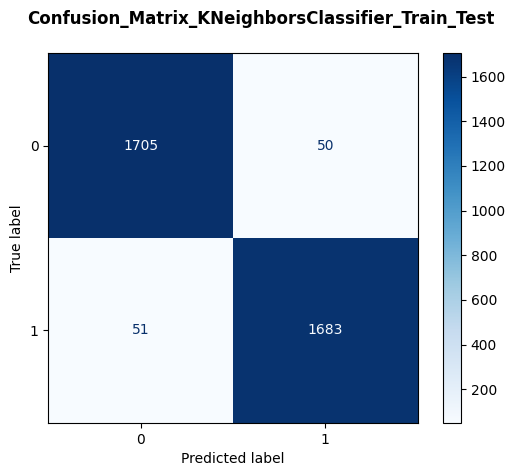

Accuracy score:
0.9710518773287475

Precision score:
0.9711482977495672

Recall score:
0.9705882352941176

F1 score:
0.97086818575137



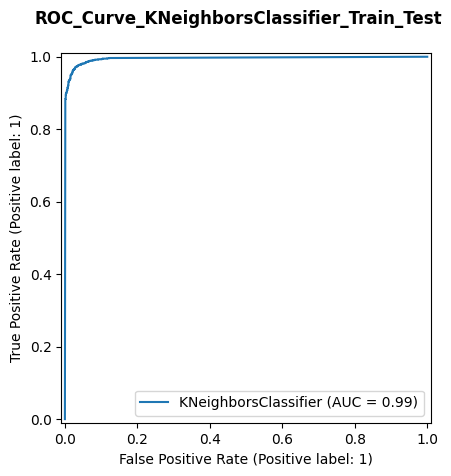

The final metric values:
{'name': ['KNeighborsClassifier'], 'duration': [6.943815900000118], 'acc_score': [0.9710518773287475], 'prec_score': [np.float64(0.9711482977495672)], 'rec_score': [np.float64(0.9705882352941176)], 'f1_score': [np.float64(0.97086818575137)]}

Dataframe of final metric values:
                   name  duration  acc_score  prec_score  rec_score  f1_score
0  KNeighborsClassifier  6.943816   0.971052    0.971148   0.970588  0.970868


In [95]:
# 1. KNeighborsClassifier
df_metric_train_test_1 = model_predict_evaluate_tt(train_result_1)

In [96]:
# Show each metric value for Train-test split
df_metric_train_test_1

,name,duration,acc_score,prec_score,rec_score,f1_score
0,KNeighborsClassifier,6.943816,0.971052,0.971148,0.970588,0.970868



Predictions of the label y:
[1 1 0 ... 0 1 0]

Dataframe of predictions:
      y_test  y_pred
0          1       1
1          1       1
2          0       0
3          0       0
4          0       0
...      ...     ...
3484       1       1
3485       0       0
3486       1       0
3487       1       1
3488       0       0

[3489 rows x 2 columns]


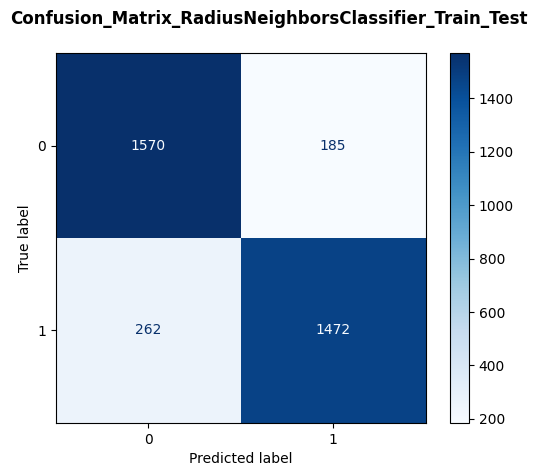

Accuracy score:
0.8718830610490111

Precision score:
0.8883524441762221

Recall score:
0.8489042675893888

F1 score:
0.8681804777351814



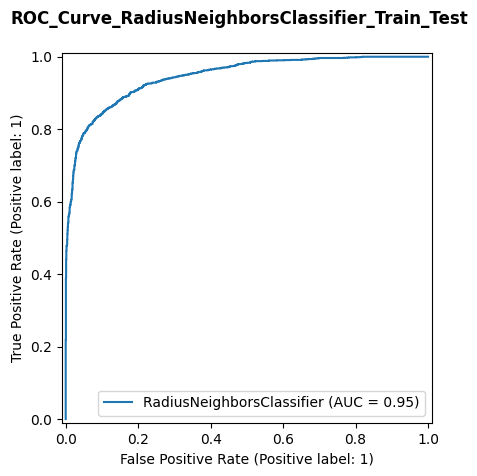

The final metric values:
{'name': ['RadiusNeighborsClassifier'], 'duration': [2.5201597000004767], 'acc_score': [0.8718830610490111], 'prec_score': [np.float64(0.8883524441762221)], 'rec_score': [np.float64(0.8489042675893888)], 'f1_score': [np.float64(0.8681804777351814)]}

Dataframe of final metric values:
                        name  duration  acc_score  prec_score  rec_score  \
0  RadiusNeighborsClassifier   2.52016   0.871883    0.888352   0.848904   

   f1_score  
0   0.86818  


In [97]:
# 2. RadiusNeighborsClassifier
df_metric_train_test_2 = model_predict_evaluate_tt(train_result_2)

In [98]:
# Show each metric value for Train-test split
df_metric_train_test_2

,name,duration,acc_score,prec_score,rec_score,f1_score
0,RadiusNeighborsClassifier,2.52016,0.871883,0.888352,0.848904,0.86818



Predictions of the label y:
[1 1 0 ... 1 1 0]

Dataframe of predictions:
      y_test  y_pred
0          1       1
1          1       1
2          0       0
3          0       0
4          0       0
...      ...     ...
3484       1       1
3485       0       0
3486       1       1
3487       1       1
3488       0       0

[3489 rows x 2 columns]


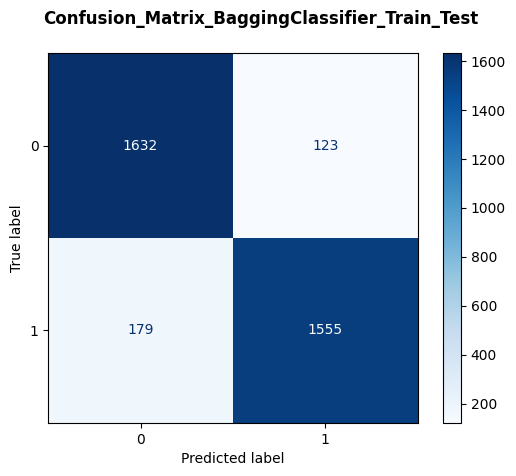

Accuracy score:
0.9134422470621955

Precision score:
0.9266984505363528

Recall score:
0.8967704728950404

F1 score:
0.9114888628370457



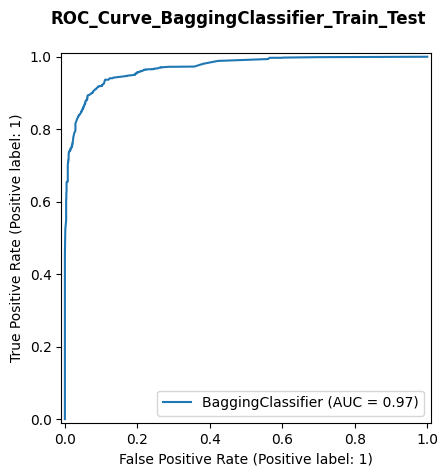

The final metric values:
{'name': ['BaggingClassifier'], 'duration': [45.75208670000029], 'acc_score': [0.9134422470621955], 'prec_score': [np.float64(0.9266984505363528)], 'rec_score': [np.float64(0.8967704728950404)], 'f1_score': [np.float64(0.9114888628370457)]}

Dataframe of final metric values:
                name   duration  acc_score  prec_score  rec_score  f1_score
0  BaggingClassifier  45.752087   0.913442    0.926698    0.89677  0.911489


In [99]:
# 3. BaggingClassifier combined with DecisionTreeClassifier
df_metric_train_test_3 = model_predict_evaluate_tt(train_result_3)

In [100]:
# Show each metric value for Train-test split
df_metric_train_test_3

,name,duration,acc_score,prec_score,rec_score,f1_score
0,BaggingClassifier,45.752087,0.913442,0.926698,0.89677,0.911489



Predictions of the label y:
[1 1 0 ... 1 1 0]

Dataframe of predictions:
      y_test  y_pred
0          1       1
1          1       1
2          0       0
3          0       0
4          0       0
...      ...     ...
3484       1       1
3485       0       0
3486       1       1
3487       1       1
3488       0       0

[3489 rows x 2 columns]


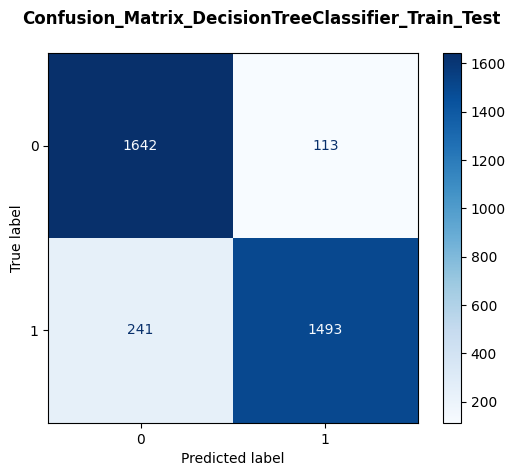

Accuracy score:
0.8985382631126397

Precision score:
0.9296388542963886

Recall score:
0.8610149942329873

F1 score:
0.8940119760479042



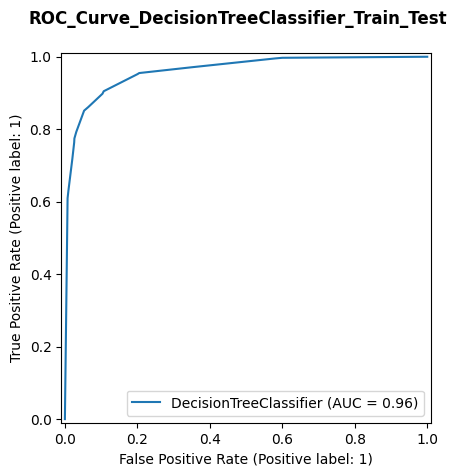

The final metric values:
{'name': ['DecisionTreeClassifier'], 'duration': [0.1893305000003238], 'acc_score': [0.8985382631126397], 'prec_score': [np.float64(0.9296388542963886)], 'rec_score': [np.float64(0.8610149942329873)], 'f1_score': [np.float64(0.8940119760479042)]}

Dataframe of final metric values:
                     name  duration  acc_score  prec_score  rec_score  \
0  DecisionTreeClassifier  0.189331   0.898538    0.929639   0.861015   

   f1_score  
0  0.894012  


In [101]:
# 4. DecisionTreeClassifier
df_metric_train_test_4 = model_predict_evaluate_tt(train_result_4)

In [102]:
# Show each metric value for Train-test split
df_metric_train_test_4

,name,duration,acc_score,prec_score,rec_score,f1_score
0,DecisionTreeClassifier,0.189331,0.898538,0.929639,0.861015,0.894012



Predictions of the label y:
[1 1 0 ... 0 1 0]

Dataframe of predictions:
      y_test  y_pred
0          1       1
1          1       1
2          0       0
3          0       0
4          0       0
...      ...     ...
3484       1       1
3485       0       0
3486       1       0
3487       1       1
3488       0       0

[3489 rows x 2 columns]


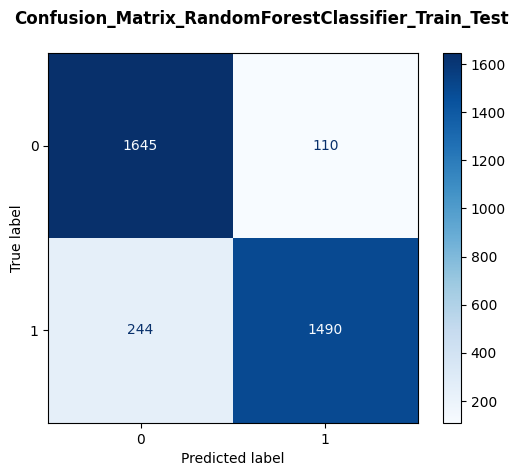

Accuracy score:
0.8985382631126397

Precision score:
0.93125

Recall score:
0.8592848904267589

F1 score:
0.8938212357528494



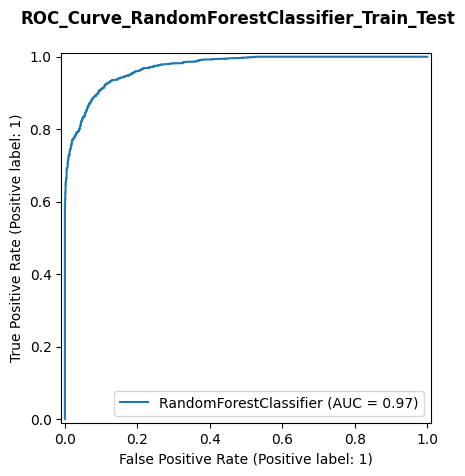

The final metric values:
{'name': ['RandomForestClassifier'], 'duration': [14.75276280000071], 'acc_score': [0.8985382631126397], 'prec_score': [np.float64(0.93125)], 'rec_score': [np.float64(0.8592848904267589)], 'f1_score': [np.float64(0.8938212357528494)]}

Dataframe of final metric values:
                     name   duration  acc_score  prec_score  rec_score  \
0  RandomForestClassifier  14.752763   0.898538     0.93125   0.859285   

   f1_score  
0  0.893821  


In [103]:
# 5. RandomForestClassifier
df_metric_train_test_5 = model_predict_evaluate_tt(train_result_5)

In [104]:
# Show each metric value for Train-test split
df_metric_train_test_5

,name,duration,acc_score,prec_score,rec_score,f1_score
0,RandomForestClassifier,14.752763,0.898538,0.93125,0.859285,0.893821


##### **Task** 【Prediction and Evaluation: using `k-fold cross-validation strategy`】
- Because there are several folds, I will **calculate the mean and variance of these metrics, respectively, after obtaining them as their final mean and variance.**

In [105]:
def model_predict_evaluate_cv(fold_result):
    """
    Prediction and evaluation using the K-fold Cross-validation strategy.

    Args:
        fold_result (ndarray): An array containing the model's name, consuming time, 
                               the best model, score, parameters, 
                               testing data and testing labels.
    
    Returns:
        df_metric: A dataframe containing all metric values using the k-fold cross-validation strategy.
        df_result: A dataframe containing the mean and variance of all metric values 
                   during the k-fold procedure.
    """
    
    # Construct arrays to store metrics for evaluation
    arr_name = np.zeros(len(fold_result), dtype=object)
    arr_acc_score = np.zeros(len(fold_result), dtype=float)
    arr_prec_score = np.zeros_like(arr_acc_score, dtype=float)
    arr_rec_score = np.zeros_like(arr_acc_score, dtype=float)
    arr_f1_score = np.zeros_like(arr_acc_score, dtype=float)
    arr_duration = np.zeros_like(arr_acc_score, dtype=float)
    
    # Traverse each fold to predict and evaluate
    for i, fold_data in enumerate(fold_result):
        print(f"Fold {i + 1}:")
        
        # Get the best model, score and parameters
        model_name = fold_data['name']
        duration = fold_data['duration']
        best_model = fold_data['best_model']
        best_score = fold_data['best_score']
        best_param = fold_data['best_param']
        
        # Get the testing data and labels
        X_test = fold_data['X_test']
        y_test = fold_data['y_test']
        
        # Predict the labels of test data
        y_pred = best_model.predict(X_test)
        print(f"Predictions of the label y:\n{y_pred}")
        
        # Compare the ground-truth and predicted class labels
        df_pred = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
        print(f"\nDataframe of predictions:\n{df_pred}")
        
        # Calculate the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        show_confusion_matrix(cm, best_model, model_name, i + 1)
        
        # Calculate the accuracy score
        acc_score = accuracy_score(y_test, y_pred)
        print(f"Accuracy score:\n{acc_score}\n")
        
        # Calculate the precision score
        prec_score = precision_score(y_test, y_pred)
        print(f"Precision score:\n{prec_score}\n")
        
        # Calculate the recall score
        rec_score = recall_score(y_test, y_pred)
        print(f"Recall score:\n{rec_score}\n")
        
        # Calculate the F1-score
        f_score = f1_score(y_test, y_pred)
        print(f"F1 score:\n{f_score}\n")
        
        # Display the ROC curve
        show_roc_curve(X_test, y_test, best_model, model_name, i + 1, 1)
        
        # Store evaluation metrics in each list
        arr_name[i] = best_model.__class__.__name__
        arr_duration[i] = duration
        arr_acc_score[i] = acc_score
        arr_prec_score[i] = prec_score
        arr_rec_score[i] = rec_score
        arr_f1_score[i] = f_score
    
    # Construct a dict and then convert it into a dataframe
    fold_evaluate = {
        'name': arr_name,
        'duration': arr_duration,
        'acc_score': arr_acc_score,
        'prec_score': arr_prec_score,
        'rec_score': arr_rec_score,
        'f1_score': arr_f1_score
    }
    print(f"The final metric values:\n{fold_evaluate}")
    df_metric = pd.DataFrame(fold_evaluate, columns=['name', 'duration', 'acc_score', 'prec_score', 'rec_score', 'f1_score'])
    print(f"\nDataframe of final metric values:\n{df_metric}")
    
    # Calculate the mean and variance of evaluation metrics
    mean = df_metric.mean(numeric_only=True)
    variance = df_metric.var(numeric_only=True)
    
    # Construct two dataframes
    df_mean = pd.DataFrame(mean, columns=['mean'])
    df_variance = pd.DataFrame(variance, columns=['variance'])
    
    # Concat two dataframes
    df_result = pd.concat([df_mean, df_variance], axis=1)
    
    return df_metric, df_result

Fold 1:
Predictions of the label y:
[1 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       1
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3484       0       0
3485       0       0
3486       0       0
3487       0       0
3488       0       0

[3489 rows x 2 columns]


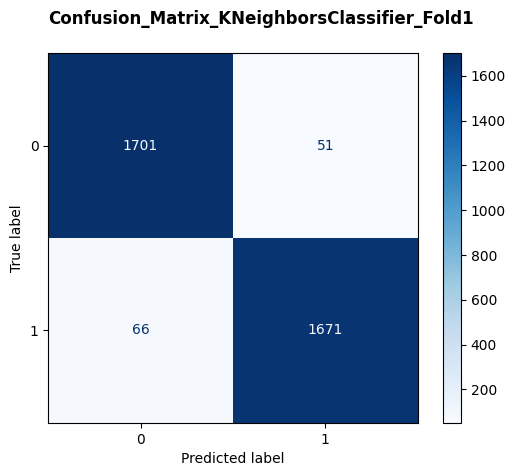

Accuracy score:
0.9664660361134996

Precision score:
0.9703832752613241

Recall score:
0.9620034542314335

F1 score:
0.9661751951431049



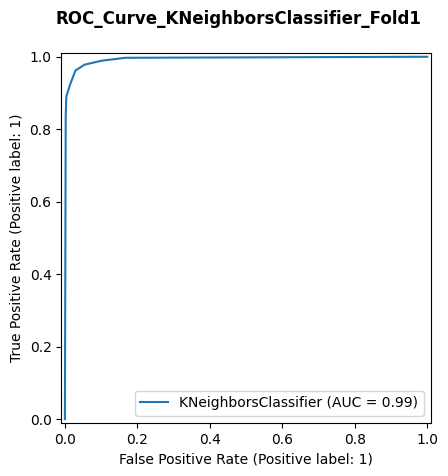

Fold 2:
Predictions of the label y:
[0 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       0
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3484       0       0
3485       0       0
3486       0       0
3487       0       0
3488       0       0

[3489 rows x 2 columns]


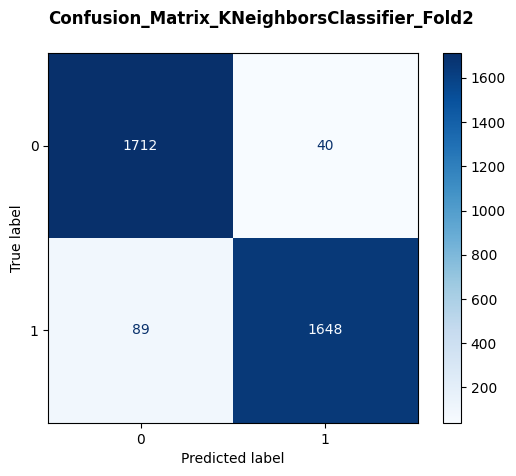

Accuracy score:
0.9630266552020637

Precision score:
0.976303317535545

Recall score:
0.948762233736327

F1 score:
0.9623357664233577



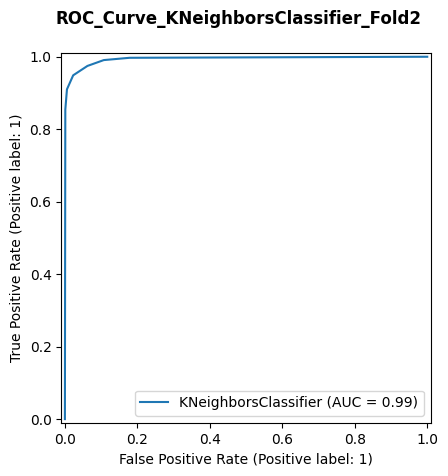

Fold 3:
Predictions of the label y:
[1 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       1
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3483       0       0
3484       0       0
3485       0       0
3486       0       0
3487       0       0

[3488 rows x 2 columns]


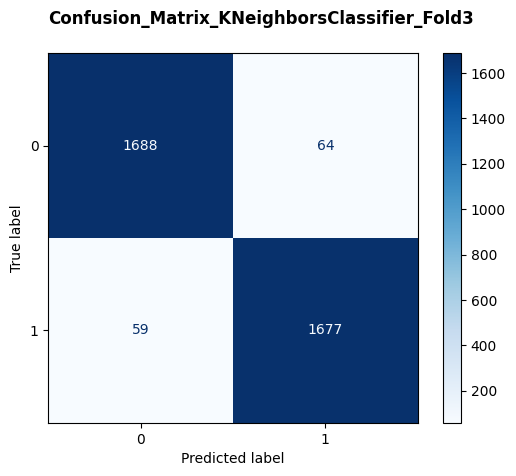

Accuracy score:
0.9647362385321101

Precision score:
0.9632395175186674

Recall score:
0.9660138248847926

F1 score:
0.9646246764452114



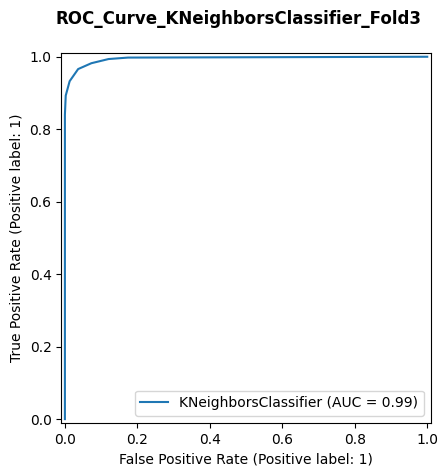

Fold 4:
Predictions of the label y:
[0 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          0       0
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3483       0       0
3484       0       0
3485       0       0
3486       0       0
3487       0       0

[3488 rows x 2 columns]


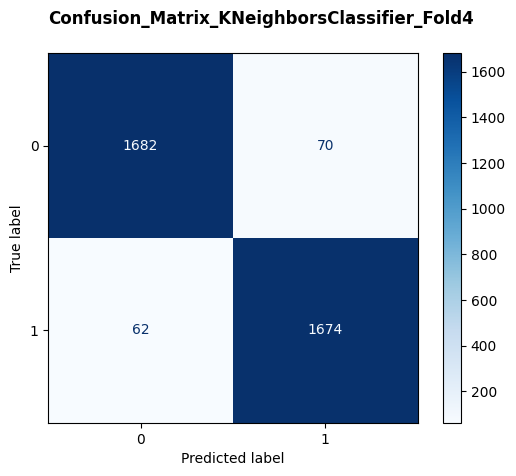

Accuracy score:
0.9621559633027523

Precision score:
0.9598623853211009

Recall score:
0.9642857142857143

F1 score:
0.9620689655172414



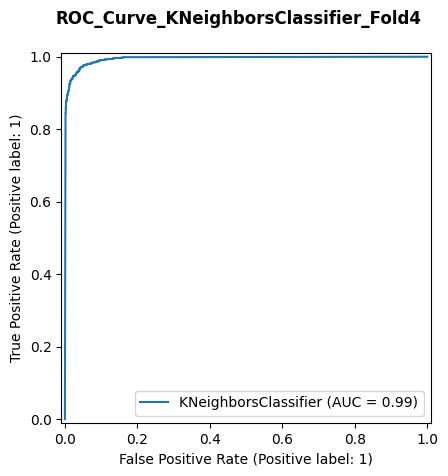

Fold 5:
Predictions of the label y:
[1 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       1
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3483       0       0
3484       0       0
3485       0       0
3486       0       0
3487       0       0

[3488 rows x 2 columns]


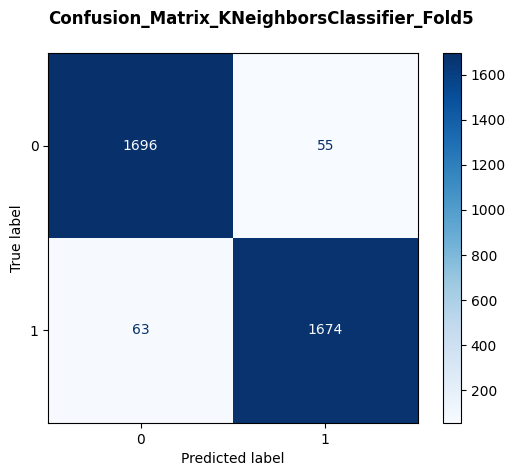

Accuracy score:
0.9661697247706422

Precision score:
0.9681897050318103

Recall score:
0.9637305699481865

F1 score:
0.9659549913444894



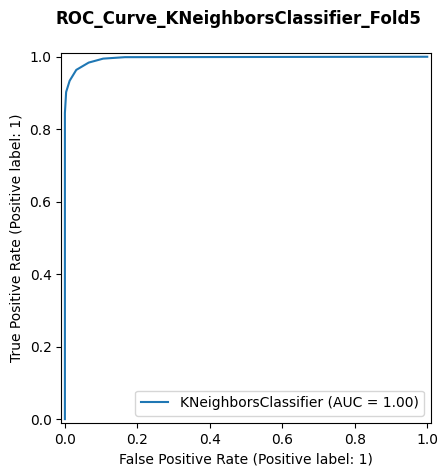

The final metric values:
{'name': array(['KNeighborsClassifier', 'KNeighborsClassifier',
       'KNeighborsClassifier', 'KNeighborsClassifier',
       'KNeighborsClassifier'], dtype=object), 'duration': array([23.2206913, 22.5624653, 22.8139913, 22.5579787, 23.2631295]), 'acc_score': array([0.96646604, 0.96302666, 0.96473624, 0.96215596, 0.96616972]), 'prec_score': array([0.97038328, 0.97630332, 0.96323952, 0.95986239, 0.96818971]), 'rec_score': array([0.96200345, 0.94876223, 0.96601382, 0.96428571, 0.96373057]), 'f1_score': array([0.9661752 , 0.96233577, 0.96462468, 0.96206897, 0.96595499])}

Dataframe of final metric values:
                   name   duration  acc_score  prec_score  rec_score  f1_score
0  KNeighborsClassifier  23.220691   0.966466    0.970383   0.962003  0.966175
1  KNeighborsClassifier  22.562465   0.963027    0.976303   0.948762  0.962336
2  KNeighborsClassifier  22.813991   0.964736    0.963240   0.966014  0.964625
3  KNeighborsClassifier  22.557979   0.962156    

In [106]:
# 1. KNeighborsClassifier
df_metric_k_fold_1, df_result_k_fold_1 = model_predict_evaluate_cv(fold_result_1)

In [107]:
# Show each metric value for K folds
df_metric_k_fold_1

,name,duration,acc_score,prec_score,rec_score,f1_score
0,KNeighborsClassifier,23.220691,0.966466,0.970383,0.962003,0.966175
1,KNeighborsClassifier,22.562465,0.963027,0.976303,0.948762,0.962336
2,KNeighborsClassifier,22.813991,0.964736,0.963240,0.966014,0.964625
3,KNeighborsClassifier,22.557979,0.962156,0.959862,0.964286,0.962069
4,KNeighborsClassifier,23.263130,0.966170,0.968190,0.963731,0.965955


In [108]:
# Show the calculated mean and variance as the final result of the current K-fold Cross-validation performance
df_result_k_fold_1

,mean,variance
duration,22.883651,0.117919
acc_score,0.964511,0.000004
prec_score,0.967596,0.000041
rec_score,0.960959,0.000049
f1_score,0.964232,0.000004


Fold 1:
Predictions of the label y:
[1 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       1
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3484       0       0
3485       0       0
3486       0       0
3487       0       0
3488       0       0

[3489 rows x 2 columns]


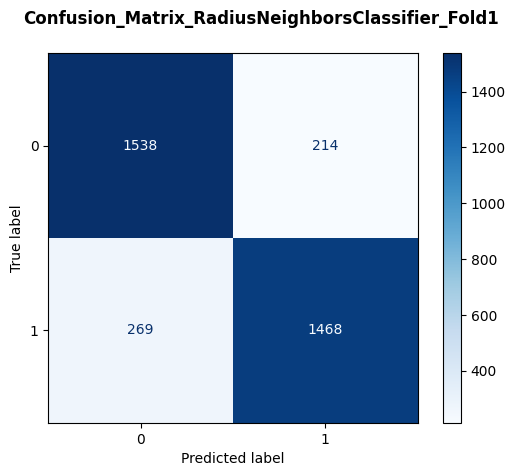

Accuracy score:
0.8615649183147034

Precision score:
0.8727705112960761

Recall score:
0.8451352907311457

F1 score:
0.8587306229891781



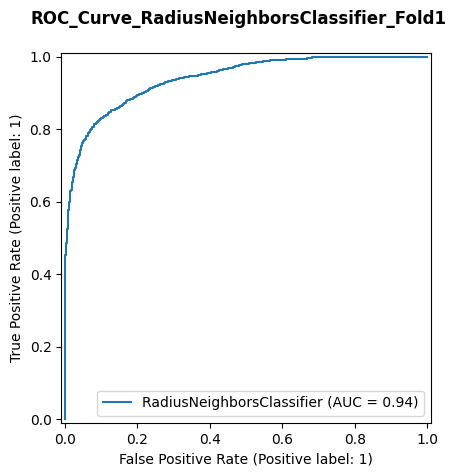

Fold 2:
Predictions of the label y:
[0 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       0
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3484       0       0
3485       0       0
3486       0       0
3487       0       0
3488       0       0

[3489 rows x 2 columns]


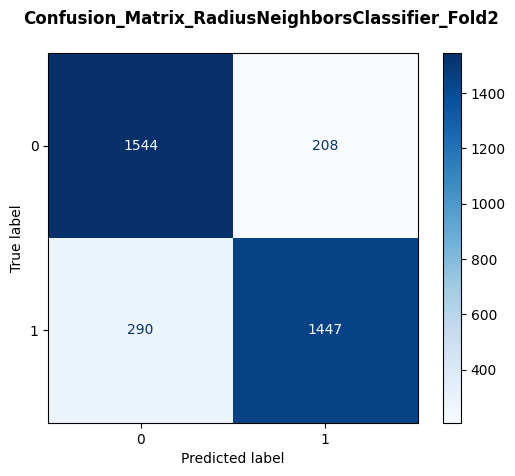

Accuracy score:
0.8572656921754084

Precision score:
0.8743202416918429

Recall score:
0.8330454807138745

F1 score:
0.8531839622641509



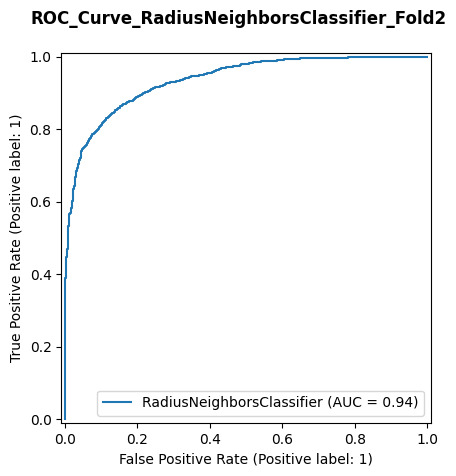

Fold 3:
Predictions of the label y:
[1 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       1
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3483       0       0
3484       0       0
3485       0       0
3486       0       0
3487       0       0

[3488 rows x 2 columns]


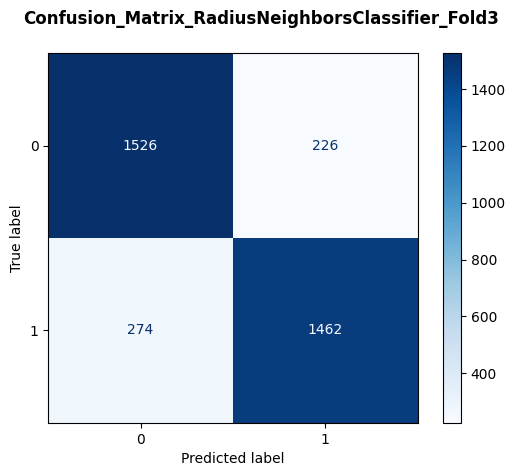

Accuracy score:
0.856651376146789

Precision score:
0.8661137440758294

Recall score:
0.8421658986175116

F1 score:
0.8539719626168224



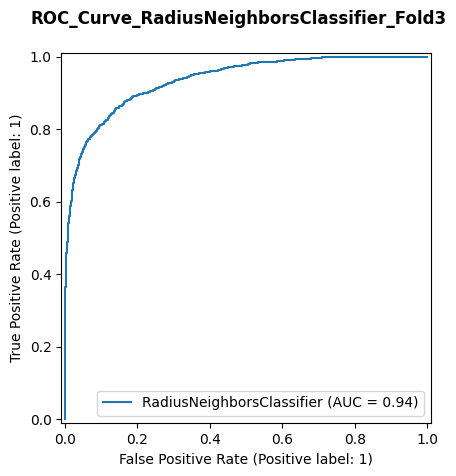

Fold 4:
Predictions of the label y:
[0 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          0       0
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3483       0       0
3484       0       0
3485       0       0
3486       0       0
3487       0       0

[3488 rows x 2 columns]


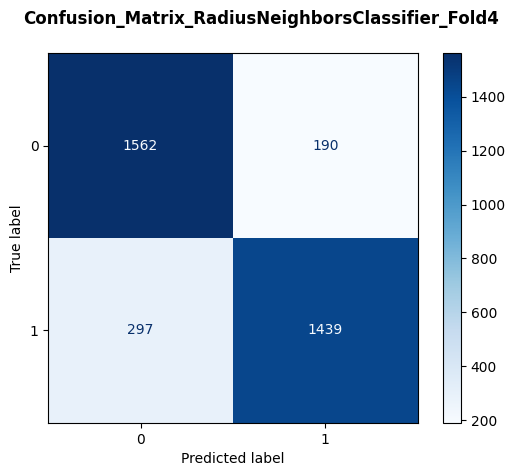

Accuracy score:
0.8603784403669725

Precision score:
0.8833640270104358

Recall score:
0.8289170506912442

F1 score:
0.8552748885586924



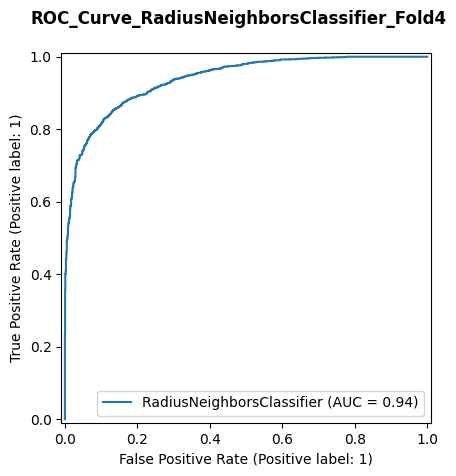

Fold 5:
Predictions of the label y:
[1 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       1
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3483       0       0
3484       0       0
3485       0       0
3486       0       0
3487       0       0

[3488 rows x 2 columns]


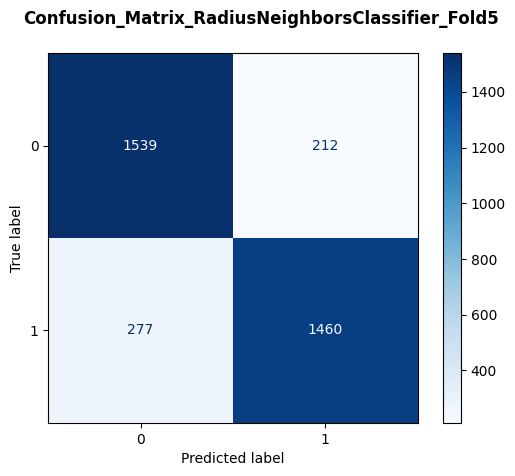

Accuracy score:
0.8598050458715596

Precision score:
0.8732057416267942

Recall score:
0.8405296488198043

F1 score:
0.8565561748313288



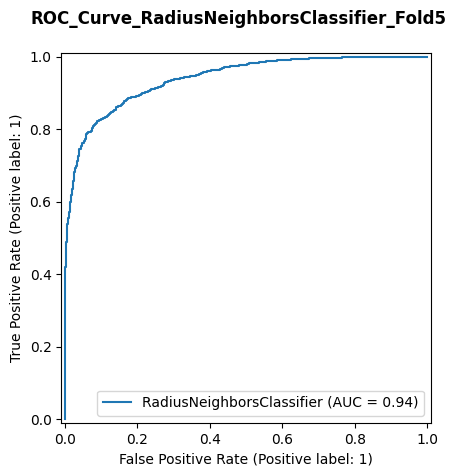

The final metric values:
{'name': array(['RadiusNeighborsClassifier', 'RadiusNeighborsClassifier',
       'RadiusNeighborsClassifier', 'RadiusNeighborsClassifier',
       'RadiusNeighborsClassifier'], dtype=object), 'duration': array([6.9311454, 6.8879329, 6.9392035, 6.8142144, 6.6423952]), 'acc_score': array([0.86156492, 0.85726569, 0.85665138, 0.86037844, 0.85980505]), 'prec_score': array([0.87277051, 0.87432024, 0.86611374, 0.88336403, 0.87320574]), 'rec_score': array([0.84513529, 0.83304548, 0.8421659 , 0.82891705, 0.84052965]), 'f1_score': array([0.85873062, 0.85318396, 0.85397196, 0.85527489, 0.85655617])}

Dataframe of final metric values:
                        name  duration  acc_score  prec_score  rec_score  \
0  RadiusNeighborsClassifier  6.931145   0.861565    0.872771   0.845135   
1  RadiusNeighborsClassifier  6.887933   0.857266    0.874320   0.833045   
2  RadiusNeighborsClassifier  6.939204   0.856651    0.866114   0.842166   
3  RadiusNeighborsClassifier  6.814214   

In [109]:
# 2. RadiusNeighborsClassifier
df_metric_k_fold_2, df_result_k_fold_2 = model_predict_evaluate_cv(fold_result_2)

In [110]:
# Show each metric value for K folds
df_metric_k_fold_2

,name,duration,acc_score,prec_score,rec_score,f1_score
0,RadiusNeighborsClassifier,6.931145,0.861565,0.872771,0.845135,0.858731
1,RadiusNeighborsClassifier,6.887933,0.857266,0.874320,0.833045,0.853184
2,RadiusNeighborsClassifier,6.939204,0.856651,0.866114,0.842166,0.853972
3,RadiusNeighborsClassifier,6.814214,0.860378,0.883364,0.828917,0.855275
4,RadiusNeighborsClassifier,6.642395,0.859805,0.873206,0.840530,0.856556


In [111]:
# Show the calculated mean and variance as the final result of the current K-fold Cross-validation performance
df_result_k_fold_2

,mean,variance
duration,6.842978,0.015029
acc_score,0.859133,0.000004
prec_score,0.873955,0.000038
rec_score,0.837959,0.000045
f1_score,0.855544,0.000005


Fold 1:
Predictions of the label y:
[1 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       1
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3484       0       0
3485       0       0
3486       0       0
3487       0       0
3488       0       0

[3489 rows x 2 columns]


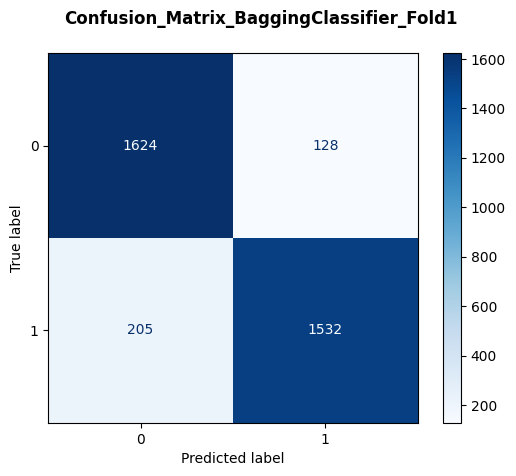

Accuracy score:
0.9045571797076526

Precision score:
0.9228915662650602

Recall score:
0.8819804260218768

F1 score:
0.9019723285251693



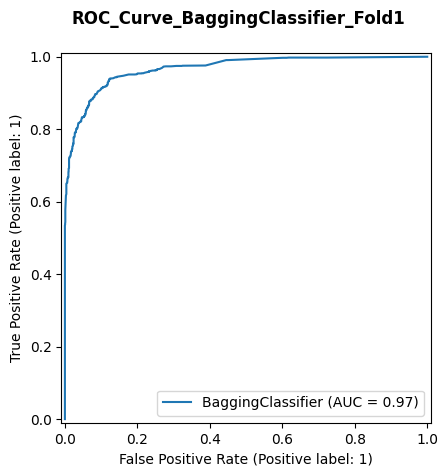

Fold 2:
Predictions of the label y:
[0 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       0
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3484       0       0
3485       0       0
3486       0       0
3487       0       0
3488       0       0

[3489 rows x 2 columns]


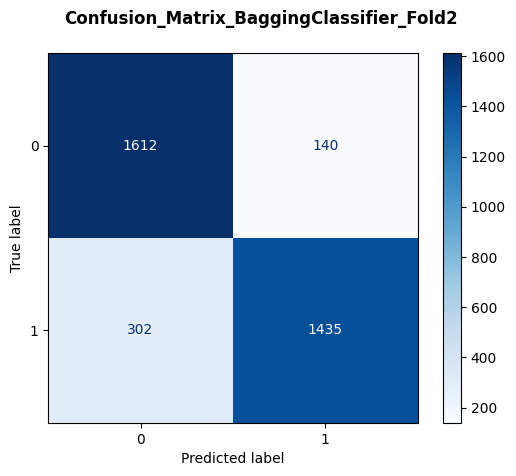

Accuracy score:
0.8733161364287761

Precision score:
0.9111111111111111

Recall score:
0.8261370178468624

F1 score:
0.8665458937198067



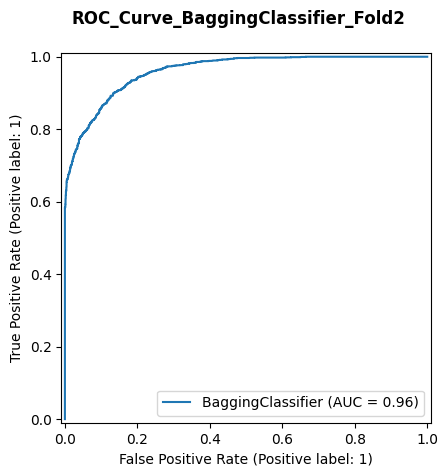

Fold 3:
Predictions of the label y:
[1 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       1
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3483       0       0
3484       0       0
3485       0       0
3486       0       0
3487       0       0

[3488 rows x 2 columns]


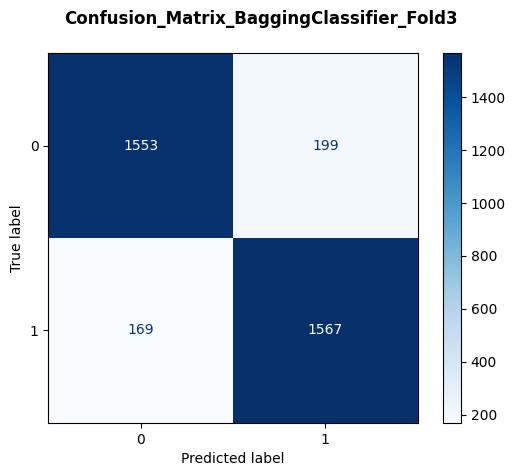

Accuracy score:
0.8944954128440367

Precision score:
0.8873159682899208

Recall score:
0.9026497695852534

F1 score:
0.8949171901770417



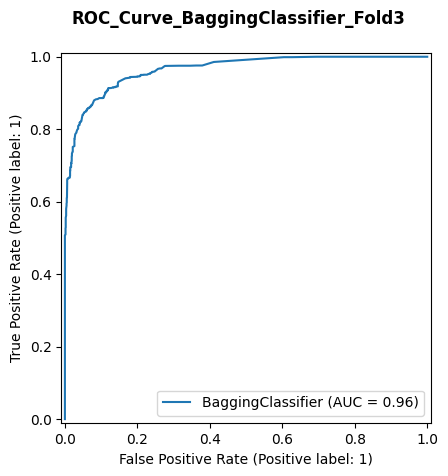

Fold 4:
Predictions of the label y:
[0 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          0       0
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3483       0       0
3484       0       0
3485       0       0
3486       0       0
3487       0       0

[3488 rows x 2 columns]


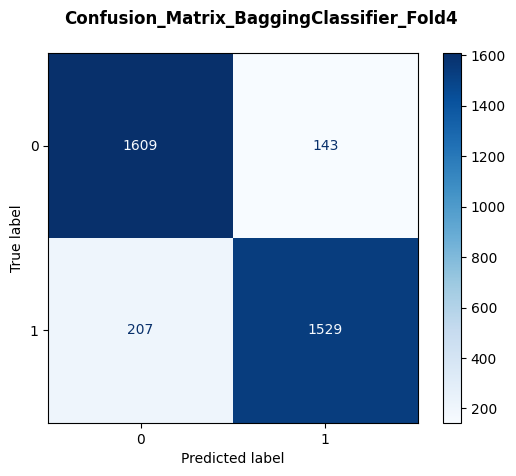

Accuracy score:
0.8996559633027523

Precision score:
0.9144736842105263

Recall score:
0.8807603686635944

F1 score:
0.8973004694835681



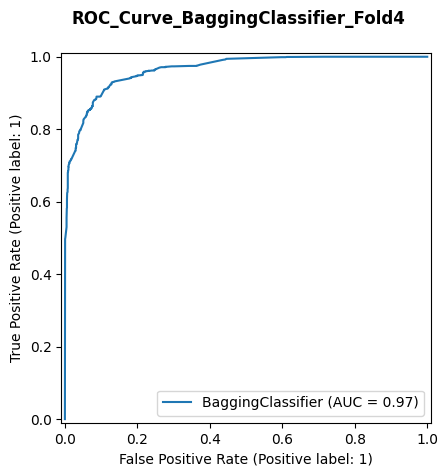

Fold 5:
Predictions of the label y:
[0 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       0
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3483       0       0
3484       0       0
3485       0       0
3486       0       0
3487       0       0

[3488 rows x 2 columns]


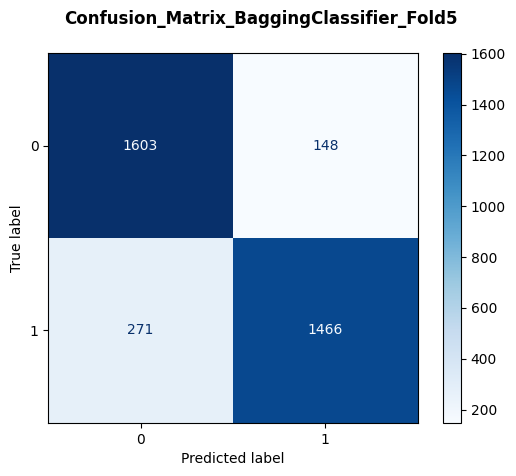

Accuracy score:
0.8798738532110092

Precision score:
0.9083023543990086

Recall score:
0.8439838802533103

F1 score:
0.8749626977021785



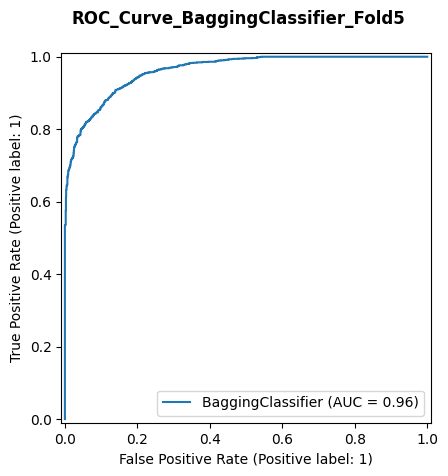

The final metric values:
{'name': array(['BaggingClassifier', 'BaggingClassifier', 'BaggingClassifier',
       'BaggingClassifier', 'BaggingClassifier'], dtype=object), 'duration': array([60.3098895, 59.2184379, 61.0044354, 61.8874273, 61.0061311]), 'acc_score': array([0.90455718, 0.87331614, 0.89449541, 0.89965596, 0.87987385]), 'prec_score': array([0.92289157, 0.91111111, 0.88731597, 0.91447368, 0.90830235]), 'rec_score': array([0.88198043, 0.82613702, 0.90264977, 0.88076037, 0.84398388]), 'f1_score': array([0.90197233, 0.86654589, 0.89491719, 0.89730047, 0.8749627 ])}

Dataframe of final metric values:
                name   duration  acc_score  prec_score  rec_score  f1_score
0  BaggingClassifier  60.309889   0.904557    0.922892   0.881980  0.901972
1  BaggingClassifier  59.218438   0.873316    0.911111   0.826137  0.866546
2  BaggingClassifier  61.004435   0.894495    0.887316   0.902650  0.894917
3  BaggingClassifier  61.887427   0.899656    0.914474   0.880760  0.897300
4  Bagg

In [112]:
# 3. BaggingClassifier combined with DecisionTreeClassifier
df_metric_k_fold_3, df_result_k_fold_3 = model_predict_evaluate_cv(fold_result_3)

In [113]:
# Show each metric value for K folds
df_metric_k_fold_3

,name,duration,acc_score,prec_score,rec_score,f1_score
0,BaggingClassifier,60.309889,0.904557,0.922892,0.881980,0.901972
1,BaggingClassifier,59.218438,0.873316,0.911111,0.826137,0.866546
2,BaggingClassifier,61.004435,0.894495,0.887316,0.902650,0.894917
3,BaggingClassifier,61.887427,0.899656,0.914474,0.880760,0.897300
4,BaggingClassifier,61.006131,0.879874,0.908302,0.843984,0.874963


In [114]:
# Show the calculated mean and variance as the final result of the current K-fold Cross-validation performance
df_result_k_fold_3

,mean,variance
duration,60.685264,0.985627
acc_score,0.890380,0.000176
prec_score,0.908819,0.000174
rec_score,0.867102,0.000971
f1_score,0.887140,0.000239


Fold 1:
Predictions of the label y:
[1 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       1
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3484       0       0
3485       0       0
3486       0       0
3487       0       0
3488       0       0

[3489 rows x 2 columns]


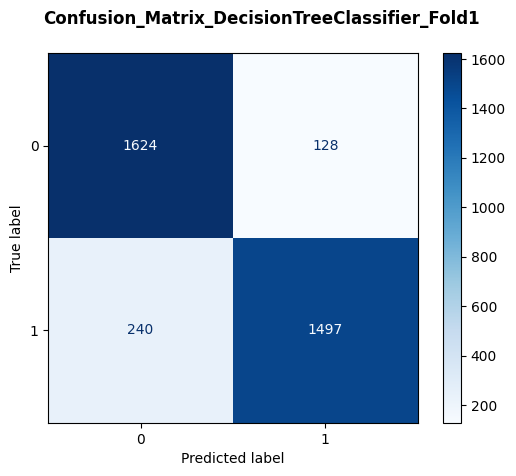

Accuracy score:
0.8945256520492978

Precision score:
0.9212307692307692

Recall score:
0.8618307426597582

F1 score:
0.8905413444378346



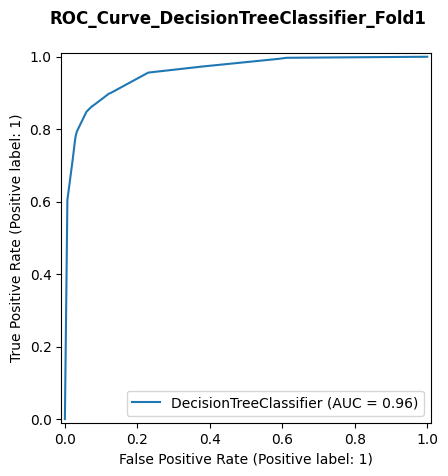

Fold 2:
Predictions of the label y:
[0 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       0
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3484       0       0
3485       0       0
3486       0       0
3487       0       0
3488       0       0

[3489 rows x 2 columns]


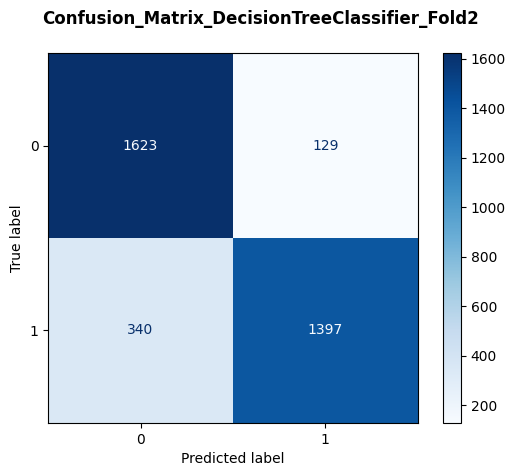

Accuracy score:
0.8655775293780453

Precision score:
0.9154652686762779

Recall score:
0.8042602187679908

F1 score:
0.8562672387373582



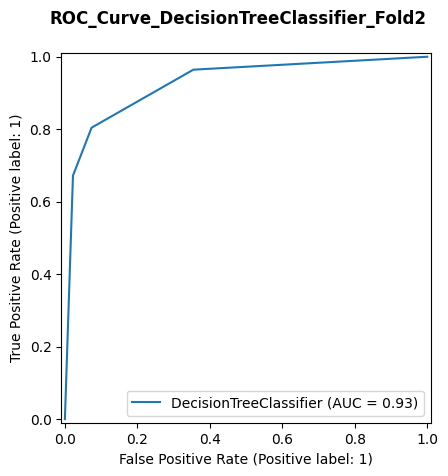

Fold 3:
Predictions of the label y:
[1 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       1
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3483       0       0
3484       0       0
3485       0       0
3486       0       0
3487       0       0

[3488 rows x 2 columns]


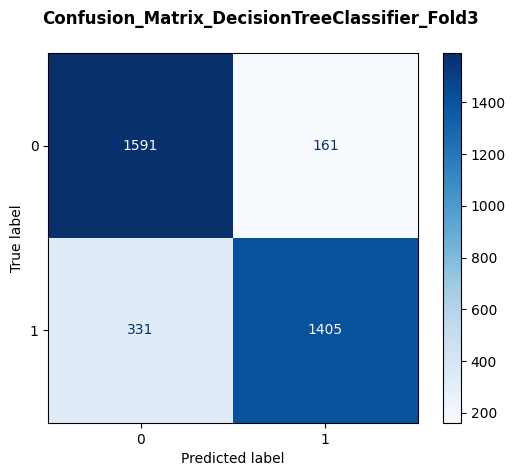

Accuracy score:
0.8589449541284404

Precision score:
0.8971902937420179

Recall score:
0.809331797235023

F1 score:
0.850999394306481



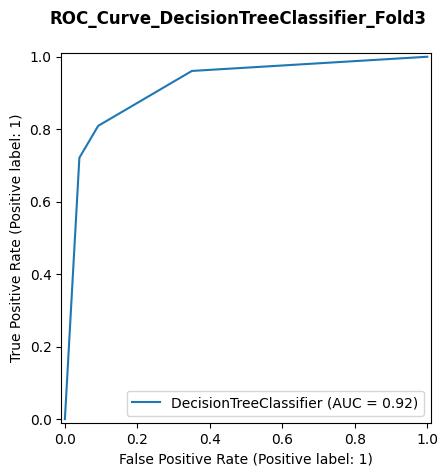

Fold 4:
Predictions of the label y:
[0 0 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          0       0
1          1       0
2          1       1
3          1       1
4          1       1
...      ...     ...
3483       0       0
3484       0       0
3485       0       0
3486       0       0
3487       0       0

[3488 rows x 2 columns]


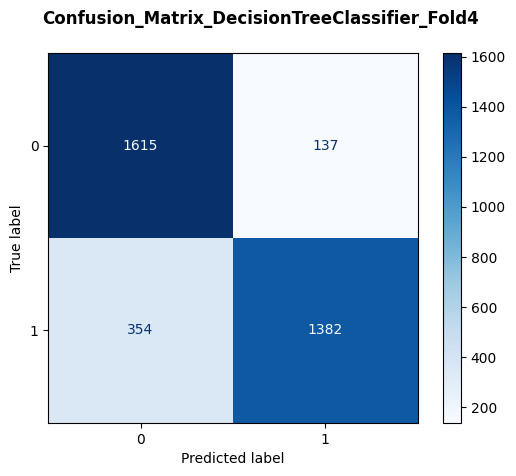

Accuracy score:
0.8592316513761468

Precision score:
0.9098090849242922

Recall score:
0.7960829493087558

F1 score:
0.8491551459293395



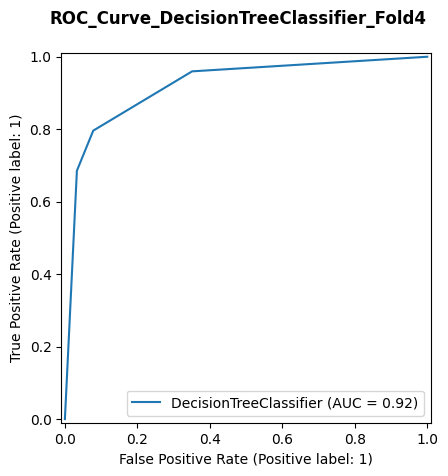

Fold 5:
Predictions of the label y:
[0 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       0
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3483       0       0
3484       0       0
3485       0       0
3486       0       0
3487       0       0

[3488 rows x 2 columns]


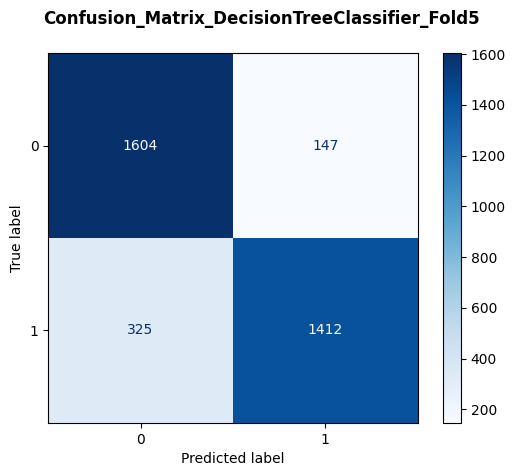

Accuracy score:
0.8646788990825688

Precision score:
0.9057087876844131

Recall score:
0.8128957973517559

F1 score:
0.8567961165048543



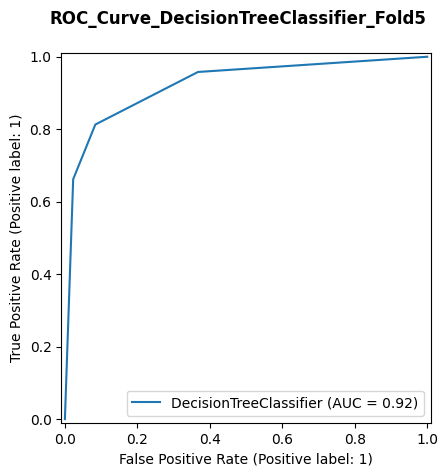

The final metric values:
{'name': array(['DecisionTreeClassifier', 'DecisionTreeClassifier',
       'DecisionTreeClassifier', 'DecisionTreeClassifier',
       'DecisionTreeClassifier'], dtype=object), 'duration': array([0.2783965, 0.2489681, 0.2761746, 0.24536  , 0.2720288]), 'acc_score': array([0.89452565, 0.86557753, 0.85894495, 0.85923165, 0.8646789 ]), 'prec_score': array([0.92123077, 0.91546527, 0.89719029, 0.90980908, 0.90570879]), 'rec_score': array([0.86183074, 0.80426022, 0.8093318 , 0.79608295, 0.8128958 ]), 'f1_score': array([0.89054134, 0.85626724, 0.85099939, 0.84915515, 0.85679612])}

Dataframe of final metric values:
                     name  duration  acc_score  prec_score  rec_score  \
0  DecisionTreeClassifier  0.278396   0.894526    0.921231   0.861831   
1  DecisionTreeClassifier  0.248968   0.865578    0.915465   0.804260   
2  DecisionTreeClassifier  0.276175   0.858945    0.897190   0.809332   
3  DecisionTreeClassifier  0.245360   0.859232    0.909809   0.79608

In [115]:
# 4. DecisionTreeClassifier
df_metric_k_fold_4, df_result_k_fold_4 = model_predict_evaluate_cv(fold_result_4)

In [116]:
# Show each metric value for K folds
df_metric_k_fold_4

,name,duration,acc_score,prec_score,rec_score,f1_score
0,DecisionTreeClassifier,0.278396,0.894526,0.921231,0.861831,0.890541
1,DecisionTreeClassifier,0.248968,0.865578,0.915465,0.804260,0.856267
2,DecisionTreeClassifier,0.276175,0.858945,0.897190,0.809332,0.850999
3,DecisionTreeClassifier,0.245360,0.859232,0.909809,0.796083,0.849155
4,DecisionTreeClassifier,0.272029,0.864679,0.905709,0.812896,0.856796


In [117]:
# Show the calculated mean and variance as the final result of the current K-fold Cross-validation performance
df_result_k_fold_4

,mean,variance
duration,0.264186,0.000248
acc_score,0.868592,0.000219
prec_score,0.909881,0.000085
rec_score,0.816880,0.000671
f1_score,0.860752,0.000288


Fold 1:
Predictions of the label y:
[0 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       0
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3484       0       0
3485       0       0
3486       0       0
3487       0       0
3488       0       0

[3489 rows x 2 columns]


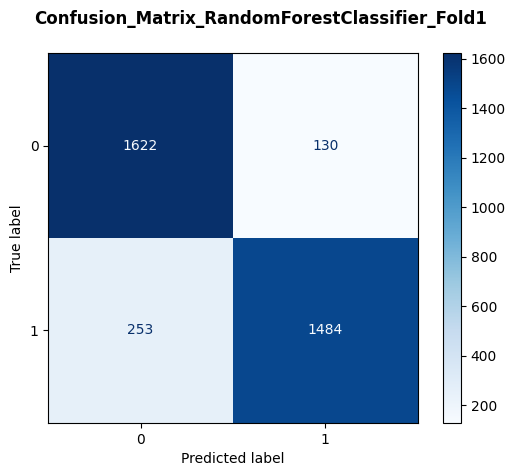

Accuracy score:
0.8902264259100029

Precision score:
0.919454770755886

Recall score:
0.8543465745538285

F1 score:
0.8857057594747837



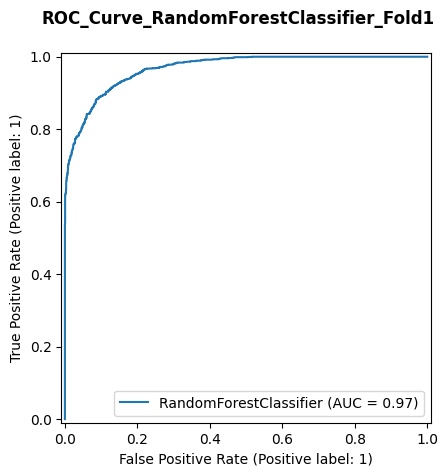

Fold 2:
Predictions of the label y:
[0 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       0
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3484       0       0
3485       0       0
3486       0       0
3487       0       0
3488       0       0

[3489 rows x 2 columns]


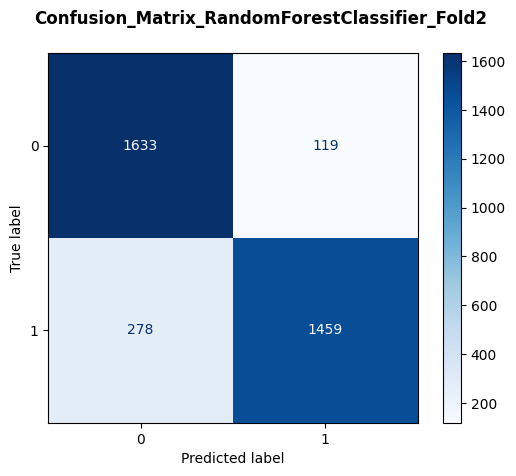

Accuracy score:
0.886213814846661

Precision score:
0.9245880861850444

Recall score:
0.8399539435808866

F1 score:
0.8802413273001508



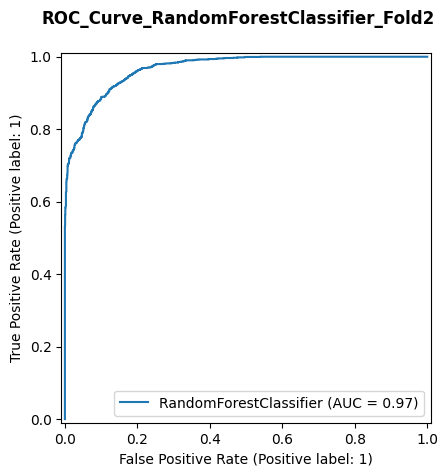

Fold 3:
Predictions of the label y:
[1 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       1
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3483       0       0
3484       0       0
3485       0       0
3486       0       0
3487       0       0

[3488 rows x 2 columns]


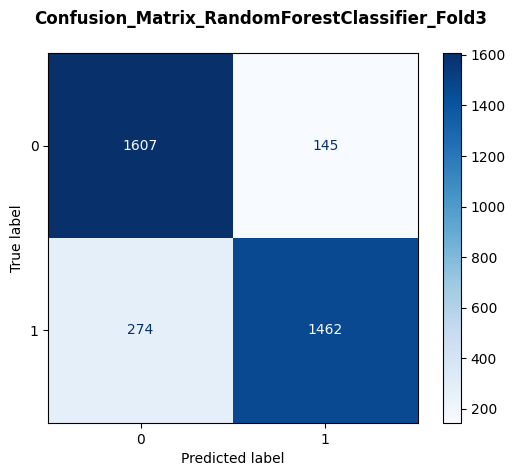

Accuracy score:
0.8798738532110092

Precision score:
0.909769757311761

Recall score:
0.8421658986175116

F1 score:
0.8746634759198325



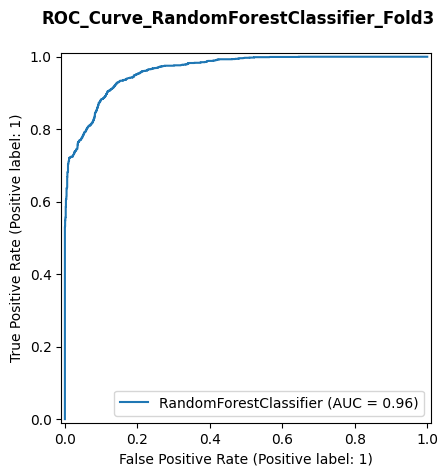

Fold 4:
Predictions of the label y:
[0 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          0       0
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3483       0       0
3484       0       0
3485       0       0
3486       0       0
3487       0       0

[3488 rows x 2 columns]


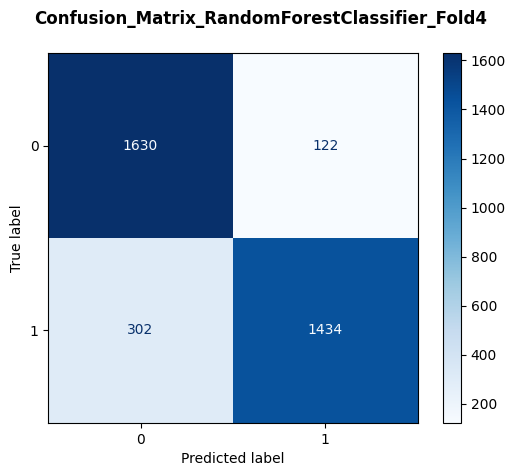

Accuracy score:
0.8784403669724771

Precision score:
0.9215938303341902

Recall score:
0.826036866359447

F1 score:
0.8712029161603888



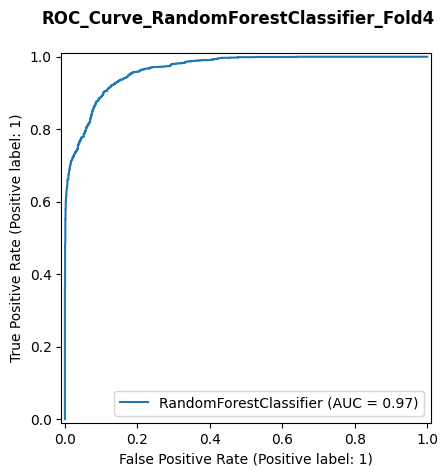

Fold 5:
Predictions of the label y:
[0 1 1 ... 0 0 0]

Dataframe of predictions:
      y_test  y_pred
0          1       0
1          1       1
2          1       1
3          1       1
4          1       1
...      ...     ...
3483       0       0
3484       0       0
3485       0       0
3486       0       0
3487       0       0

[3488 rows x 2 columns]


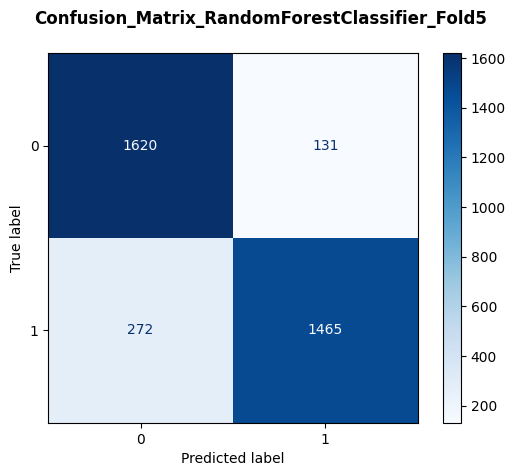

Accuracy score:
0.8844610091743119

Precision score:
0.9179197994987469

Recall score:
0.8434081750143926

F1 score:
0.8790879087908791



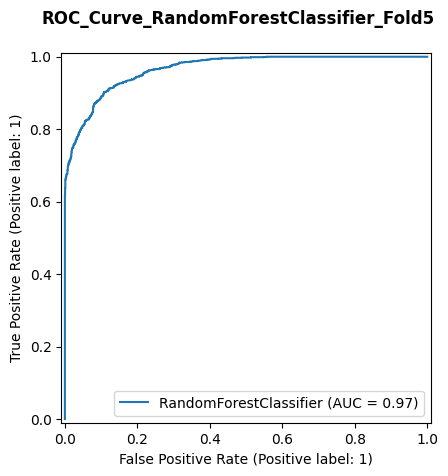

The final metric values:
{'name': array(['RandomForestClassifier', 'RandomForestClassifier',
       'RandomForestClassifier', 'RandomForestClassifier',
       'RandomForestClassifier'], dtype=object), 'duration': array([20.251332 , 20.4803932, 20.0950428, 19.9393544, 20.052679 ]), 'acc_score': array([0.89022643, 0.88621381, 0.87987385, 0.87844037, 0.88446101]), 'prec_score': array([0.91945477, 0.92458809, 0.90976976, 0.92159383, 0.9179198 ]), 'rec_score': array([0.85434657, 0.83995394, 0.8421659 , 0.82603687, 0.84340818]), 'f1_score': array([0.88570576, 0.88024133, 0.87466348, 0.87120292, 0.87908791])}

Dataframe of final metric values:
                     name   duration  acc_score  prec_score  rec_score  \
0  RandomForestClassifier  20.251332   0.890226    0.919455   0.854347   
1  RandomForestClassifier  20.480393   0.886214    0.924588   0.839954   
2  RandomForestClassifier  20.095043   0.879874    0.909770   0.842166   
3  RandomForestClassifier  19.939354   0.878440    0.921594

In [118]:
# 5. RandomForestClassifier
df_metric_k_fold_5, df_result_k_fold_5 = model_predict_evaluate_cv(fold_result_5)

In [119]:
# Show each metric value for K folds
df_metric_k_fold_5

,name,duration,acc_score,prec_score,rec_score,f1_score
0,RandomForestClassifier,20.251332,0.890226,0.919455,0.854347,0.885706
1,RandomForestClassifier,20.480393,0.886214,0.924588,0.839954,0.880241
2,RandomForestClassifier,20.095043,0.879874,0.909770,0.842166,0.874663
3,RandomForestClassifier,19.939354,0.878440,0.921594,0.826037,0.871203
4,RandomForestClassifier,20.052679,0.884461,0.917920,0.843408,0.879088


In [120]:
# Show the calculated mean and variance as the final result of the current K-fold Cross-validation performance
df_result_k_fold_5

,mean,variance
duration,20.163760,0.043836
acc_score,0.883843,0.000023
prec_score,0.918665,0.000031
rec_score,0.841182,0.000103
f1_score,0.878180,0.000031


##### **Task** 【Evaluation (for `self-implemented k-Nearest-Neighbors` algorithm): `Train-test split strategy`】
【Note】
- Here, **I tried to use the `self-implemented k-NN`**. However, because there are 13953 training data and 3489 testing data, the process needs 13953 × 3489 times to finish the program, **consuming about 8 minutes**. As a result, **for considering the whole duration of the project, I implemented it here but commented on the running code.**
- The evaluation result of the `self-implemented k-NN` has been experimented with an accuracy score of **96.68%**.
- **Owing to the duration of this model, I primarily save models and related info about the other five implemented models.**

In [121]:
def model_predict_evaluate_knn(y_pred, duration):
    """
    Prediction and evaluation using the Train-test split strategy.

    Args:
        y_pred (ndarray): The predicted labels of the testing data.
        duration (float): The duration of training the self-defined K-NN.
    
    Returns:
        df_metric: A dataframe containing all metric values using the train-test split strategy.
    """
    
    # Compare the ground-truth and predicted class labels
    df_pred = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    print(f"\nDataframe of predictions:\n{df_pred}")

    # Get the model name
    model_name = 'Self-implemented-k-NN'
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    show_confusion_matrix(cm, '', model_name, -1)
    
    # Calculate the accuracy score
    acc_score = accuracy_score(y_test, y_pred)
    print(f"Accuracy score:\n{acc_score}\n")
    
    # Calculate the precision score
    prec_score = precision_score(y_test, y_pred)
    print(f"Precision score:\n{prec_score}\n")
    
    # Calculate the recall score
    rec_score = recall_score(y_test, y_pred)
    print(f"Recall score:\n{rec_score}\n")
    
    # Calculate the F1-score
    f_score = f1_score(y_test, y_pred)
    print(f"F1 score:\n{f_score}\n")
    
    # Display the ROC curve
    show_roc_curve(X_test, y_test, y_pred, model_name, -1, 2)
    
    # Construct a dict and then convert it into a dataframe
    train_evaluate = {
        'name': [model_name],
        'duration': [duration],
        'acc_score': [acc_score],
        'prec_score': [prec_score],
        'rec_score': [rec_score],
        'f1_score': [f_score]
    }
    print(f"The final metric values:\n{train_evaluate}")
    df_metric = pd.DataFrame(train_evaluate, columns=['name', 'acc_score', 'prec_score', 'rec_score', 'f1_score'])
    print(f"\nDataframe of final metric values:\n{df_metric}")
    
    return df_metric

**If you have an interest, you can uncomment them to run.**

In [122]:
# df_metric_train_test_kNN = model_predict_evaluate_knn(y_pred_self_defined_knn, duration_self_defined_knn)

In [123]:
# # Show each metric value for the Train-test split
# df_metric_train_test_kNN

### Step 4 · Model Registry
【Step Description】
- Version control and management of models to ensure traceability (Save trained models and related files).

##### **Task** 【Combine all dataframes containing evaluation results (`Train-test split strategy`) and save】

In [124]:
# axis=0: concat two tables vertically
df_metric_combined_tt = pd.concat([df_metric_train_test_1, df_metric_train_test_2], axis=0).reset_index(drop=True)
for df in [df_metric_train_test_3, df_metric_train_test_4, df_metric_train_test_5]:
    df_metric_combined_tt = pd.concat([df_metric_combined_tt, df], axis=0).reset_index(drop=True)
df_metric_combined_tt

,name,duration,acc_score,prec_score,rec_score,f1_score
0,KNeighborsClassifier,6.943816,0.971052,0.971148,0.970588,0.970868
1,RadiusNeighborsClassifier,2.520160,0.871883,0.888352,0.848904,0.868180
2,BaggingClassifier,45.752087,0.913442,0.926698,0.896770,0.911489
3,DecisionTreeClassifier,0.189331,0.898538,0.929639,0.861015,0.894012
4,RandomForestClassifier,14.752763,0.898538,0.931250,0.859285,0.893821


In [125]:
# Save in a file
df_metric_combined_tt.to_csv('AEF_COMBINED_METRIC_TT.csv', index_label='id', encoding='utf-8')

##### **Task** 【Combine all dataframes containing evaluation results (`k-fold cross-validation strategy`) and save】

In [126]:
# axis=0: concat two tables vertically
df_metric_combined_cv = pd.concat([df_metric_k_fold_1, df_metric_k_fold_2], axis=0).reset_index(drop=True)
for df in [df_metric_k_fold_3, df_metric_k_fold_4, df_metric_k_fold_5]:
    df_metric_combined_cv = pd.concat([df_metric_combined_cv, df], axis=0).reset_index(drop=True)
df_metric_combined_cv

,name,duration,acc_score,prec_score,rec_score,f1_score
0,KNeighborsClassifier,23.220691,0.966466,0.970383,0.962003,0.966175
1,KNeighborsClassifier,22.562465,0.963027,0.976303,0.948762,0.962336
2,KNeighborsClassifier,22.813991,0.964736,0.963240,0.966014,0.964625
3,KNeighborsClassifier,22.557979,0.962156,0.959862,0.964286,0.962069
4,KNeighborsClassifier,23.263130,0.966170,0.968190,0.963731,0.965955
5,RadiusNeighborsClassifier,6.931145,0.861565,0.872771,0.845135,0.858731
6,RadiusNeighborsClassifier,6.887933,0.857266,0.874320,0.833045,0.853184
7,RadiusNeighborsClassifier,6.939204,0.856651,0.866114,0.842166,0.853972
8,RadiusNeighborsClassifier,6.814214,0.860378,0.883364,0.828917,0.855275
9,RadiusNeighborsClassifier,6.642395,0.859805,0.873206,0.840530,0.856556


In [127]:
# Save in a file
df_metric_combined_cv.to_csv('AEF_COMBINED_METRIC_CV_DETAILS.csv', index_label='id', encoding='utf-8')

In [128]:
# Calculate the mean and variance according to the concatenated dataframe
df_result_combined_cv = df_metric_combined_cv.groupby(['name']).mean().reset_index()
df_result_combined_cv

,name,duration,acc_score,prec_score,rec_score,f1_score
0,BaggingClassifier,60.685264,0.890380,0.908819,0.867102,0.887140
1,DecisionTreeClassifier,0.264186,0.868592,0.909881,0.816880,0.860752
2,KNeighborsClassifier,22.883651,0.964511,0.967596,0.960959,0.964232
3,RadiusNeighborsClassifier,6.842978,0.859133,0.873955,0.837959,0.855544
4,RandomForestClassifier,20.163760,0.883843,0.918665,0.841182,0.878180


In [129]:
# Save in a file
df_result_combined_cv.to_csv('AEF_COMBINED_METRIC_CV.csv', index_label='id', encoding='utf-8')

##### **Task** 【Save models (`Train-test split strategy`)】

In [130]:
# Save models
for result in [train_result_1, train_result_2, train_result_3, train_result_4, train_result_5]:
    # Get the best model from each train_result_i
    name = result['name']
    best_model = result['best_model']
    best_score = result['best_score']
    print(f"The best model:\n{best_model}\nIts score: {best_score}\n")
    
    # Save the model
    save_models(name, 'tt', best_model)

The best model:
KNeighborsClassifier(weights='distance')
Its score: 0.9710518773287475

Successfully saved the KNeighborsClassifier model!

The best model:
RadiusNeighborsClassifier()
Its score: 0.8718830610490111

Successfully saved the RadiusNeighborsClassifier model!

The best model:
BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                   random_state=20717331),
                  n_estimators=100, random_state=20717331)
Its score: 0.9134422470621955

Successfully saved the BaggingClassifier model!

The best model:
DecisionTreeClassifier(max_depth=4, random_state=20717331)
Its score: 0.8985382631126397

Successfully saved the DecisionTreeClassifier model!

The best model:
RandomForestClassifier(max_depth=4, n_estimators=110, random_state=20717331)
Its score: 0.8985382631126397

Successfully saved the RandomForestClassifier model!



In [131]:
# Load models
for result in [train_result_1, train_result_2, train_result_3, train_result_4, train_result_5]:
    name = result['name']
    
    # Load the model
    model = load_models(name, 'tt')
    print(f"The best model of {name} saved before:\n{model}\n")

Successfully loaded the KNeighborsClassifier model!
The best model of KNeighborsClassifier saved before:
KNeighborsClassifier(weights='distance')

Successfully loaded the RadiusNeighborsClassifier model!
The best model of RadiusNeighborsClassifier saved before:
RadiusNeighborsClassifier()

Successfully loaded the BaggingClassifier model!
The best model of BaggingClassifier saved before:
BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                   random_state=20717331),
                  n_estimators=100, random_state=20717331)

Successfully loaded the DecisionTreeClassifier model!
The best model of DecisionTreeClassifier saved before:
DecisionTreeClassifier(max_depth=4, random_state=20717331)

Successfully loaded the RandomForestClassifier model!
The best model of RandomForestClassifier saved before:
RandomForestClassifier(max_depth=4, n_estimators=110, random_state=20717331)



##### **Task** 【Save models (`K-fold Cross-validation strategy`)】

In [132]:
# Traverse each fold and choose the best model according to the score
for result in [fold_result_1, fold_result_2, fold_result_3, fold_result_4, fold_result_5]:
    best_score = -np.inf
    best_model = None
    name = result[0]['name']

    # Get the best model
    for i, fold in enumerate(result):
        cur_model = fold['best_model']
        cur_score = fold['best_score']
        
        if cur_score > best_score:
            best_model = cur_model
            best_score = cur_score

    print(f"The best model:\n{best_model}\nIts score: {best_score}\n")

    # Save the model
    save_models(name, 'cv', best_model)

The best model:
KNeighborsClassifier(algorithm='brute', n_neighbors=7)
Its score: 0.8213415508098036

Successfully saved the KNeighborsClassifier model!

The best model:
RadiusNeighborsClassifier()
Its score: 0.8449190196359466

Successfully saved the RadiusNeighborsClassifier model!

The best model:
BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                   random_state=20717331),
                  n_estimators=90, random_state=20717331)
Its score: 0.8787444460369787

Successfully saved the BaggingClassifier model!

The best model:
DecisionTreeClassifier(max_depth=4, random_state=20717331)
Its score: 0.8707789100294151

Successfully saved the DecisionTreeClassifier model!

The best model:
RandomForestClassifier(max_depth=4, random_state=20717331)
Its score: 0.8759495485165544

Successfully saved the RandomForestClassifier model!



In [133]:
# Load models
for result in [fold_result_1, fold_result_2, fold_result_3, fold_result_4, fold_result_5]:
    name = result[0]['name']
    
    # Load the model
    model = load_models(name, 'cv')
    print(f"The best model of {name} saved before:\n{model}\n")

Successfully loaded the KNeighborsClassifier model!
The best model of KNeighborsClassifier saved before:
KNeighborsClassifier(algorithm='brute', n_neighbors=7)

Successfully loaded the RadiusNeighborsClassifier model!
The best model of RadiusNeighborsClassifier saved before:
RadiusNeighborsClassifier()

Successfully loaded the BaggingClassifier model!
The best model of BaggingClassifier saved before:
BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                   random_state=20717331),
                  n_estimators=90, random_state=20717331)

Successfully loaded the DecisionTreeClassifier model!
The best model of DecisionTreeClassifier saved before:
DecisionTreeClassifier(max_depth=4, random_state=20717331)

Successfully loaded the RandomForestClassifier model!
The best model of RandomForestClassifier saved before:
RandomForestClassifier(max_depth=4, random_state=20717331)



## Stage 4 · Machine Learning Engineering

### Step 1 · Model Development
【Step Description】
- Deploy models as APIs, microservices, or edge devices.
- Deployment types: `Batch`, `real-time` and `on-device`.

【Note】
- Because the project focuses on data preprocessing, modelling and analysis, I don't implement this step.

### Step 2 · Model Serving
【Step Description】
- Serve predictions to applications or dashboards.
- Infrastructure tools: `Kubernetes`, `Docker` and `AWS Lambda`.

【Note】
- Because the project focuses on data preprocessing, modelling and analysis, I don't implement this step.

### Step 3 · Model Monitoring
【Step Description】
- Track model performance in production (accuracy drift, latency).
- Monitor data for changes that can affect model performance.

【Note】
- Because the project focuses on data preprocessing, modelling and analysis, I don't implement this step.

## Stage 5 · Insights Activation

### Step 1 · Influence Business Decisions
【Step Description】
- Use insights to generate reports, dashboards, and alerts.
- Example: `Dashboards` showing real-time KPIs for decision-making.

【Note】
- Because the project focuses on data preprocessing, modelling and analysis, I don't implement this step.

### Step 2 · Influence Consumer Decisions
【Step Description】
- Personalize recommendations, offers, and experiences.
- Example: Reducing customer churn or increasing user engagement.

【Note】
- Because the project focuses on data preprocessing, modelling and analysis, I don't implement this step.

### Step 3 · Serve Other Applications/Services
【Step Description】
- Integrate insights with external systems.
- Example: `customer service platforms` and `fraud detection`.

【Note】
- Because the project focuses on data preprocessing, modelling and analysis, I don't implement this step.

**The project has successfully completed data modelling and analysis. For other insights, please refer to the report.**

## References
### Other References: 
> [1] The pandas development team. pandas-dev/pandas: Pandas [Computer software]. https://doi.org/10.5281/zenodo.3509134. \
> [2] Van Rossum, G., & Drake Jr, F. L. (1995). Python tutorial (Vol. 620). Amsterdam, The Netherlands: Centrum voor Wiskunde en Informatica. \
> [3] Garcia Badaracco, A. SciKeras [Computer software]. https://github.com/adriangb/scikeras. \
> [4] Abadi, M., Agarwal, A., Barham, P., Brevdo, E., Chen, Z., Citro, C., Corrado, G. S., Davis, A., Dean, J., Devin, M., Ghemawat, S., Goodfellow, I., Harp, A., Irving, G., Isard, M., Jozefowicz, R., Jia, Y., Kaiser, L., Kudlur, M., Levenberg, J., Mané, D., Schuster, M., Monga, R., Moore, S., Murray, D., Olah, C., Shlens, J., Steiner, B., Sutskever, I., Talwar, K., Tucker, P., Vanhoucke, V., Vasudevan, V., Viégas, F., Vinyals, O., Warden, P., Wattenberg, M., Wicke, M., Yu, Y., & Zheng, X. (2015). TensorFlow, Large-scale machine learning on heterogeneous systems [Computer software]. https://doi.org/10.5281/zenodo.4724125. \
> [5] Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825–2830. https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html. \
> [6] Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90–95. https://doi.org/10.1109/MCSE.2007.55. \
> [7] Virtanen, P., Gommers, R., Oliphant, T. E., Haberland, M., Reddy, T., Cournapeau, D., ... & Van Mulbregt, P. (2020). SciPy 1.0: fundamental algorithms for scientific computing in Python. Nature methods, 17(3), 261-272. \
> [8] Waskom, M. L. (2021). Seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021. \
> [9] Skewness. (2025, April 18). In Wikipedia. https://en.wikipedia.org/wiki/Skewness. \
> [10] Kurtosis. (2025, April 14). In Wikipedia. https://en.wikipedia.org/wiki/Kurtosis. \
> [11] Interquartile range. (2025, February 27). In Wikipedia. https://en.wikipedia.org/wiki/Interquartile_range. \
> [12] Munroe, R. (n.d.). The 954 most common RGB monitor colors, as defined by several hundred thousand participants in the xkcd color name survey. xkcd. https://xkcd.com/color/rgb/. \
> [13] geeksforgeeks. (2025, April 7). Pandas.cut() method in Python. https://www.geeksforgeeks.org/pandas-cut-method-in-python/. \
> [14] MedCalc Software Ltd. (n.d.). Correlation coefficient. https://www.medcalc.org/manual/correlation.php#:~:text=The%20P-value%20is%20the,coefficient%20is%20called%20statistically%20significant.